In [1]:
import json
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

# --- Constants ---
JOINT_NAMES: Tuple[str, ...] = (
    "Pelvis", "Right Hip", "Right Knee", "Right Ankle",
    "Left Hip", "Left Knee", "Left Ankle",
    "Spine (Lumbar)", "Thorax (Chest)", "Neck (C7)", "Head",
    "Left Shoulder", "Left Elbow", "Left Wrist",
    "Right Shoulder", "Right Elbow", "Right Wrist",
)

SKELETON_EDGES: Tuple[Tuple[int, int], ...] = (
    (0, 1), (1, 2), (2, 3),       # right leg
    (0, 4), (4, 5), (5, 6),       # left leg
    (0, 7), (7, 8), (8, 9), (9, 10),  # spine to head
    (8, 11), (11, 12), (12, 13),  # left arm
    (8, 14), (14, 15), (15, 16),  # right arm
)

# --- Helper functions ---
def load_keypoints(path: Path) -> np.ndarray:
    """Load keypoints from JSON into a numpy array of shape (frames, joints, 3)."""
    data = json.loads(path.read_text())
    array = np.asarray(data, dtype=float)
    if array.ndim != 3 or array.shape[1:] != (len(JOINT_NAMES), 3):
        raise ValueError(f"Unexpected keypoint shape {array.shape}, expected (frames, {len(JOINT_NAMES)}, 3)")
    return array

def compute_bounds(keypoints: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Get min and max values for the 3D bounding box."""
    points = keypoints.reshape(-1, 3)
    return points.min(axis=0), points.max(axis=0)

def create_animation(keypoints: np.ndarray, fps: int = 20, elev: float = 20.0, azim: float = -60.0):
    """Create a matplotlib 3D animation of the skeleton."""
    frames, joints, _ = keypoints.shape
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    scatter = ax.scatter([], [], [], c="tab:blue", s=40)
    lines: List = []
    for _ in SKELETON_EDGES:
        (line,) = ax.plot([], [], [], c="tab:orange", lw=2)
        lines.append(line)
    title = ax.set_title("", pad=20)

    # set bounding box
    min_vals, max_vals = compute_bounds(keypoints)
    span = max(max_vals - min_vals)
    center = (max_vals + min_vals) / 2.0
    if span == 0:
        span = 1.0
    limit = span / 2.0
    ax.set_xlim(center[0] - limit, center[0] + limit)
    ax.set_ylim(center[1] - limit, center[1] + limit)
    ax.set_zlim(center[2] - limit, center[2] + limit)
    ax.set_box_aspect((1, 1, 1))
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    def update(frame_index: int):
        coords = keypoints[frame_index]
        xs, ys, zs = coords[:, 0], coords[:, 1], coords[:, 2]
        scatter._offsets3d = (xs, ys, zs)
        for line, (i, j) in zip(lines, SKELETON_EDGES):
            line.set_data([xs[i], xs[j]], [ys[i], ys[j]])
            line.set_3d_properties([zs[i], zs[j]])
        title.set_text(f"Frame {frame_index + 1}/{frames}")
        return [scatter, *lines, title]

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=frames,
        interval=1000 / fps,
        blit=False,
        repeat=True,
    )
    return fig, anim

In [3]:
import json
from pathlib import Path

summary_path = Path("/home/jtb3sud/G-PARC/demos/tennis/metadata/build_summary.json")
with open(summary_path, "r") as f:
    build_summary = json.load(f)

print(json.dumps(build_summary, indent=2)[:1000])  # preview


{
  "source_rows": 6370,
  "serves_written": 6364,
  "rows_skipped": 6
}


In [4]:
import pandas as pd

meta_df = pd.read_csv("/home/jtb3sud/G-PARC/demos/tennis/metadata/metadata.csv")
print(meta_df.shape)
print(meta_df.columns.tolist())
meta_df.head()


(6364, 54)
['match_id', 'SetNo', 'P1GamesWon', 'P2GamesWon', 'GameNo', 'PointNumber', 'PointWinner', 'PointServer', 'Speed_KMH', 'P1Score', 'P2Score', 'P1Ace', 'P2Ace', 'P1Winner', 'P2Winner', 'P1DoubleFault', 'P2DoubleFault', 'ServeIndicator', 'ServeNumber', 'RallyCount', 'ServeWidth', 'ServeDepth', 'ReturnDepth', 'player1', 'player2', 'server', 'n_frames', 'serve_id', 'keypoints_path', 'n_keypoint_frames', 'left_elbow_angles_path', 'right_elbow_angles_path', 'left_shoulder_angles_path', 'right_shoulder_angles_path', 'left_hip_angles_path', 'right_hip_angles_path', 'left_knee_angles_path', 'right_knee_angles_path', 'left_elbow_angular_velocity_path', 'left_elbow_angular_acceleration_path', 'right_elbow_angular_velocity_path', 'right_elbow_angular_acceleration_path', 'left_shoulder_angular_velocity_path', 'left_shoulder_angular_acceleration_path', 'right_shoulder_angular_velocity_path', 'right_shoulder_angular_acceleration_path', 'left_hip_angular_velocity_path', 'left_hip_angular_acce

,match_id,SetNo,P1GamesWon,P2GamesWon,GameNo,PointNumber,PointWinner,PointServer,Speed_KMH,P1Score,...,right_shoulder_angular_velocity_path,right_shoulder_angular_acceleration_path,left_hip_angular_velocity_path,left_hip_angular_acceleration_path,right_hip_angular_velocity_path,right_hip_angular_acceleration_path,left_knee_angular_velocity_path,left_knee_angular_acceleration_path,right_knee_angular_velocity_path,right_knee_angular_acceleration_path
0,2024-usopen-1101,1,0,0,1,1,1,1,180,15,...,angles/right_shoulder_angular_velocity/2024-us...,angles/right_shoulder_angular_acceleration/202...,angles/left_hip_angular_velocity/2024-usopen-1...,angles/left_hip_angular_acceleration/2024-usop...,angles/right_hip_angular_velocity/2024-usopen-...,angles/right_hip_angular_acceleration/2024-uso...,angles/left_knee_angular_velocity/2024-usopen-...,angles/left_knee_angular_acceleration/2024-uso...,angles/right_knee_angular_velocity/2024-usopen...,angles/right_knee_angular_acceleration/2024-us...
1,2024-usopen-1101,1,0,0,1,5,1,1,146,30,...,angles/right_shoulder_angular_velocity/2024-us...,angles/right_shoulder_angular_acceleration/202...,angles/left_hip_angular_velocity/2024-usopen-1...,angles/left_hip_angular_acceleration/2024-usop...,angles/right_hip_angular_velocity/2024-usopen-...,angles/right_hip_angular_acceleration/2024-uso...,angles/left_knee_angular_velocity/2024-usopen-...,angles/left_knee_angular_acceleration/2024-uso...,angles/right_knee_angular_velocity/2024-usopen...,angles/right_knee_angular_acceleration/2024-us...
2,2024-usopen-1101,1,0,1,2,14,2,2,185,0,...,angles/right_shoulder_angular_velocity/2024-us...,angles/right_shoulder_angular_acceleration/202...,angles/left_hip_angular_velocity/2024-usopen-1...,angles/left_hip_angular_acceleration/2024-usop...,angles/right_hip_angular_velocity/2024-usopen-...,angles/right_hip_angular_acceleration/2024-uso...,angles/left_knee_angular_velocity/2024-usopen-...,angles/left_knee_angular_acceleration/2024-uso...,angles/right_knee_angular_velocity/2024-usopen...,angles/right_knee_angular_acceleration/2024-us...
3,2024-usopen-1101,1,0,1,2,15,1,2,165,15,...,angles/right_shoulder_angular_velocity/2024-us...,angles/right_shoulder_angular_acceleration/202...,angles/left_hip_angular_velocity/2024-usopen-1...,angles/left_hip_angular_acceleration/2024-usop...,angles/right_hip_angular_velocity/2024-usopen-...,angles/right_hip_angular_acceleration/2024-uso...,angles/left_knee_angular_velocity/2024-usopen-...,angles/left_knee_angular_acceleration/2024-uso...,angles/right_knee_angular_velocity/2024-usopen...,angles/right_knee_angular_acceleration/2024-us...
4,2024-usopen-1101,1,0,2,2,17,2,2,152,0,...,angles/right_shoulder_angular_velocity/2024-us...,angles/right_shoulder_angular_acceleration/202...,angles/left_hip_angular_velocity/2024-usopen-1...,angles/left_hip_angular_acceleration/2024-usop...,angles/right_hip_angular_velocity/2024-usopen-...,angles/right_hip_angular_acceleration/2024-uso...,angles/left_knee_angular_velocity/2024-usopen-...,angles/left_knee_angular_acceleration/2024-uso...,angles/right_knee_angular_velocity/2024-usopen...,angles/right_knee_angular_acceleration/2024-us...


In [5]:
# number of serves according to metadata CSV
print("Metadata rows:", len(meta_df))

# number of keypoint JSON files
keypoints_dir = Path("/home/jtb3sud/G-PARC/demos/tennis/keypoints")
json_files = list(keypoints_dir.glob("*.json"))
print("Keypoint JSON files:", len(json_files))


Metadata rows: 6364
Keypoint JSON files: 6364


In [6]:
# Serve IDs in metadata
metadata_ids = set(meta_df["serve_id"])

# Serve IDs from filenames
file_ids = set(f.stem for f in json_files)

print("Only in metadata:", len(metadata_ids - file_ids))
print("Only in keypoint files:", len(file_ids - metadata_ids))


Only in metadata: 0
Only in keypoint files: 0


In [7]:
# Pick a random keypoint file and check it exists in metadata
example_file = json_files[0]
example_id = example_file.stem

print("Example serve_id:", example_id)

row = meta_df.loc[meta_df["serve_id"] == example_id]
display(row.T)


Example serve_id: 2024-usopen-1402_pt0097_srv2


,2575
match_id,2024-usopen-1402
SetNo,3
P1GamesWon,0
P2GamesWon,1
GameNo,2
PointNumber,97
PointWinner,1
PointServer,1
Speed_KMH,135
P1Score,15


In [12]:
import json
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd

# --- Constants ---
JOINT_NAMES: Tuple[str, ...] = (
    "Pelvis", "Right Hip", "Right Knee", "Right Ankle",
    "Left Hip", "Left Knee", "Left Ankle",
    "Spine (Lumbar)", "Thorax (Chest)", "Neck (C7)", "Head",
    "Left Shoulder", "Left Elbow", "Left Wrist",
    "Right Shoulder", "Right Elbow", "Right Wrist",
)

SKELETON_EDGES: Tuple[Tuple[int, int], ...] = (
    (0, 1), (1, 2), (2, 3),       # right leg
    (0, 4), (4, 5), (5, 6),       # left leg
    (0, 7), (7, 8), (8, 9), (9, 10),  # spine to head
    (8, 11), (11, 12), (12, 13),  # left arm
    (8, 14), (14, 15), (15, 16),  # right arm
)

# --- Functions ---
def load_keypoints(path: Path) -> np.ndarray:
    data = json.loads(path.read_text())
    array = np.asarray(data, dtype=float)
    if array.ndim != 3 or array.shape[1:] != (len(JOINT_NAMES), 3):
        raise ValueError(f"Unexpected keypoint shape {array.shape}")
    return array

def compute_bounds(keypoints: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    points = keypoints.reshape(-1, 3)
    return points.min(axis=0), points.max(axis=0)

def create_animation(keypoints: np.ndarray, fps: int = 20, elev: float = 20, azim: float = -60):
    frames, joints, _ = keypoints.shape
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    scatter = ax.scatter([], [], [], c="tab:blue", s=40)
    lines: List = []
    for _ in SKELETON_EDGES:
        (line,) = ax.plot([], [], [], c="tab:orange", lw=2)
        lines.append(line)
    title = ax.set_title("", pad=20)

    min_vals, max_vals = compute_bounds(keypoints)
    span = max(max_vals - min_vals)
    center = (max_vals + min_vals) / 2.0
    limit = span/2 if span>0 else 1.0
    ax.set_xlim(center[0]-limit, center[0]+limit)
    ax.set_ylim(center[1]-limit, center[1]+limit)
    ax.set_zlim(center[2]-limit, center[2]+limit)
    ax.set_box_aspect((1,1,1))
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

    def update(frame_index: int):
        coords = keypoints[frame_index]
        xs, ys, zs = coords[:,0], coords[:,1], coords[:,2]
        scatter._offsets3d = (xs, ys, zs)
        for line, (i,j) in zip(lines, SKELETON_EDGES):
            line.set_data([xs[i], xs[j]], [ys[i], ys[j]])
            line.set_3d_properties([zs[i], zs[j]])
        title.set_text(f"Frame {frame_index+1}/{frames}")
        return [scatter, *lines, title]

    anim = animation.FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False, repeat=True)
    return fig, anim

def save_pose_gif(keypoints: np.ndarray, output_path: Path, fps: int = 20):
    fig, anim = create_animation(keypoints, fps=fps)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    writer = animation.PillowWriter(fps=fps)
    anim.save(str(output_path), writer=writer)
    print(f"Saved skeleton GIF to {output_path}")
    plt.close(fig)  # close the figure to avoid displaying it inline

def plot_physical_features(meta_row: pd.Series):
    """Plot joint angles and velocities if paths exist in metadata."""
    plt.rcParams.update({'figure.figsize': (12,4)})
    features = [
        "left_elbow_angles_path", "right_elbow_angles_path",
        "left_shoulder_angles_path", "right_shoulder_angles_path",
        "left_hip_angles_path", "right_hip_angles_path",
        "left_knee_angles_path", "right_knee_angles_path"
    ]
    
    for f in features:
        path = meta_row[f].values[0] if f in meta_row else None
        if path and Path(path).exists():
            data = pd.read_csv(path)
            plt.plot(data, label=f.replace("_path",""))
    
    # optional: serve speed overlay if available
    if "Speed_KMH" in meta_row:
        plt.axhline(meta_row["Speed_KMH"].values[0], color='red', linestyle='--', label='Serve Speed KMH')
    
    plt.title("Physical Features over Time")
    plt.xlabel("Frame")
    plt.ylabel("Angle / Velocity")
    plt.legend()
    plt.show()

def visualize_serve(serve_id: str, meta_df: pd.DataFrame, gif_path: Path, fps: int = 20):
    """Save skeleton GIF and plot physical features separately."""
    row = meta_df.loc[meta_df["serve_id"] == serve_id]
    if row.empty:
        print(f"Serve {serve_id} not found in metadata.")
        return
    
    # Load keypoints
    keypoints_file = Path(row["keypoints_path"].values[0])
    keypoints = load_keypoints(keypoints_file)
    
    # Save GIF
    save_pose_gif(keypoints, gif_path, fps=fps)
    
    # Plot features
    plot_physical_features(row)


In [13]:
import json
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union
from collections import defaultdict
import re
from datetime import datetime
from tqdm import tqdm

class TennisServeSpeedProcessor:
    """
    Process tennis serve data for serve speed prediction task.
    
    Each serve becomes ONE Data object containing:
    - Complete temporal sequence of joint positions/angles/velocities
    - Target: serve speed (km/h)
    - Rich contextual metadata
    
    Task: Given entire serve motion sequence → Predict serve speed
    """
    
    def __init__(self, base_dir: Union[str, Path]):
        self.base_dir = Path(base_dir)
        self.metadata_path = self.base_dir / "metadata" / "metadata.csv"
        self.keypoints_dir = self.base_dir / "keypoints"
        self.angles_dir = self.base_dir / "angles"
        
        # Tennis skeleton structure (17 joints)
        self.joint_names = [
            "Pelvis", "Right Hip", "Right Knee", "Right Ankle",
            "Left Hip", "Left Knee", "Left Ankle", 
            "Spine (Lumbar)", "Thorax (Chest)", "Neck (C7)", "Head",
            "Left Shoulder", "Left Elbow", "Left Wrist",
            "Right Shoulder", "Right Elbow", "Right Wrist"
        ]
        
        # Skeletal connectivity for graph structure
        self.skeleton_edges = [
            (0, 1), (1, 2), (2, 3),        # right leg
            (0, 4), (4, 5), (5, 6),        # left leg  
            (0, 7), (7, 8), (8, 9), (9, 10),  # spine to head
            (8, 11), (11, 12), (12, 13),   # left arm
            (8, 14), (14, 15), (15, 16),   # right arm
        ]
        
        # Joint-to-angle mapping for feature assignment
        self.joint_to_angles = {
            11: 'left_shoulder_angles',   # Left Shoulder
            14: 'right_shoulder_angles',  # Right Shoulder  
            12: 'left_elbow_angles',      # Left Elbow
            15: 'right_elbow_angles',     # Right Elbow
            4: 'left_hip_angles',         # Left Hip
            1: 'right_hip_angles',        # Right Hip
            5: 'left_knee_angles',        # Left Knee
            2: 'right_knee_angles'        # Right Knee
        }
        
        self.serve_info = {}
        
    def load_metadata(self) -> pd.DataFrame:
        """Load the metadata CSV file."""
        if not self.metadata_path.exists():
            raise FileNotFoundError(f"Metadata file not found: {self.metadata_path}")
        
        metadata = pd.read_csv(self.metadata_path)
        print(f"Loaded metadata for {len(metadata)} serves")
        return metadata
    
    def load_keypoints(self, keypoints_path: Path) -> np.ndarray:
        """Load keypoints from JSON file."""
        if not keypoints_path.exists():
            raise FileNotFoundError(f"Keypoints file not found: {keypoints_path}")
            
        with open(keypoints_path, 'r') as f:
            data = json.load(f)
        
        keypoints = np.array(data, dtype=np.float32)  # Shape: (frames, joints, 3)
        
        if keypoints.shape[1:] != (len(self.joint_names), 3):
            raise ValueError(f"Unexpected keypoints shape: {keypoints.shape}")
        
        return keypoints
    
    def load_angle_data(self, angle_path: Path) -> np.ndarray:
        """Load angle data from CSV file."""
        if not angle_path.exists():
            return None
            
        try:
            data = pd.read_csv(angle_path, header=None).values.flatten()
            return data.astype(np.float32)
        except Exception as e:
            print(f"Warning: Could not load angle data from {angle_path}: {e}")
            return None
    
    def create_skeletal_graph_connectivity(self) -> torch.Tensor:
        """Create edge index tensor for skeletal connectivity."""
        edges = []
        
        # Add bidirectional edges for skeleton connectivity
        for i, j in self.skeleton_edges:
            edges.append([i, j])
            edges.append([j, i])
        
        # Add self-loops for each joint
        for i in range(len(self.joint_names)):
            edges.append([i, i])
            
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        return edge_index
    
    def extract_serve_metadata(self, serve_row: pd.Series) -> Dict:
        """Extract contextual metadata for serve speed prediction."""
        metadata = {
            # Core identifiers
            'serve_id': serve_row['serve_id'],
            'match_id': serve_row['match_id'],
            
            # Target variable
            'serve_speed_kmh': float(serve_row['Speed_KMH']),
            
            # Serve context (may influence speed)
            'serve_number': int(serve_row['ServeNumber']),  # 1st or 2nd serve
            'server': serve_row['server'],
            'serve_width': serve_row['ServeWidth'],  # Wide, Body, T
            'serve_depth': serve_row['ServeDepth'],  # Deep, Short, etc.
            
            # Match pressure context
            'set_no': int(serve_row['SetNo']),
            'game_no': int(serve_row['GameNo']),
            'point_number': int(serve_row['PointNumber']),
            'p1_score': serve_row['P1Score'],
            'p2_score': serve_row['P2Score'],
            'p1_games_won': int(serve_row['P1GamesWon']),
            'p2_games_won': int(serve_row['P2GamesWon']),
            
            # Players
            'player1': serve_row['player1'],
            'player2': serve_row['player2'],
            'is_player1_serving': serve_row['PointServer'] == 1,
            
            # Outcome information (for analysis, not prediction)
            'point_winner': int(serve_row['PointWinner']),
            'is_ace': bool(serve_row['P1Ace'] or serve_row['P2Ace']),
            'is_double_fault': bool(serve_row['P1DoubleFault'] or serve_row['P2DoubleFault']),
            'is_winner': bool(serve_row['P1Winner'] or serve_row['P2Winner']),
            'rally_count': int(serve_row['RallyCount']),
            
            # Temporal info
            'n_frames': int(serve_row['n_keypoint_frames'])
        }
        
        return metadata
    
    def process_single_serve(self, serve_row: pd.Series, include_angles: bool = True, 
                           include_velocities: bool = True, normalize_sequences: bool = True) -> Data:
        """
        Process a single serve into ONE PyG Data object for serve speed prediction.
        
        Returns:
            Data object with:
            - x: temporal node features [num_joints, time_steps, feature_dim]
            - edge_index: skeletal connectivity
            - y: serve speed (target)
            - Rich metadata for analysis
        """
        serve_id = serve_row['serve_id']
        
        # Load keypoints
        keypoints_file = self.base_dir / serve_row['keypoints_path']
        try:
            keypoints = self.load_keypoints(keypoints_file)  # Shape: (T, 17, 3)
        except Exception as e:
            print(f"Error loading keypoints for {serve_id}: {e}")
            return None
        
        n_frames, n_joints, n_coords = keypoints.shape
        
        # Load angle data
        angle_data = {}
        angle_features = ['left_elbow_angles', 'right_elbow_angles', 'left_shoulder_angles', 
                         'right_shoulder_angles', 'left_hip_angles', 'right_hip_angles',
                         'left_knee_angles', 'right_knee_angles']
        
        if include_angles:
            for feature in angle_features:
                path_col = f"{feature}_path"
                if path_col in serve_row and pd.notna(serve_row[path_col]):
                    angle_file = self.base_dir / serve_row[path_col]
                    data = self.load_angle_data(angle_file)
                    if data is not None and len(data) == n_frames:
                        angle_data[feature] = data
        
        # Load velocity/acceleration data
        if include_velocities:
            velocity_features = [f.replace('_angles', '_angular_velocity') for f in angle_features]
            acceleration_features = [f.replace('_angles', '_angular_acceleration') for f in angle_features]
            
            for feature in velocity_features + acceleration_features:
                path_col = f"{feature}_path"
                if path_col in serve_row and pd.notna(serve_row[path_col]):
                    vel_file = self.base_dir / serve_row[path_col]
                    data = self.load_angle_data(vel_file)
                    if data is not None and len(data) == n_frames:
                        angle_data[feature] = data
        
        # Extract metadata
        serve_metadata = self.extract_serve_metadata(serve_row)
        target_speed = serve_metadata['serve_speed_kmh']
        
        # Create temporal node features
        # Each joint will have features across all timesteps
        temporal_features = []
        
        for joint_idx in range(n_joints):
            joint_features_over_time = []
            
            # Position coordinates over time (3 features per timestep)
            joint_positions = keypoints[:, joint_idx, :]  # Shape: (T, 3)
            joint_features_over_time.append(joint_positions)
            
            # Add joint-specific angle data if available
            if joint_idx in self.joint_to_angles:
                angle_feature_name = self.joint_to_angles[joint_idx]
                
                # Angle values over time
                if angle_feature_name in angle_data:
                    angle_values = angle_data[angle_feature_name].reshape(-1, 1)  # Shape: (T, 1)
                    joint_features_over_time.append(angle_values)
                else:
                    joint_features_over_time.append(np.zeros((n_frames, 1)))
                
                # Velocity values over time
                vel_feature_name = angle_feature_name.replace('_angles', '_angular_velocity')
                if vel_feature_name in angle_data:
                    vel_values = angle_data[vel_feature_name].reshape(-1, 1)  # Shape: (T, 1)
                    joint_features_over_time.append(vel_values)
                else:
                    joint_features_over_time.append(np.zeros((n_frames, 1)))
                
                # Acceleration values over time  
                acc_feature_name = angle_feature_name.replace('_angles', '_angular_acceleration')
                if acc_feature_name in angle_data:
                    acc_values = angle_data[acc_feature_name].reshape(-1, 1)  # Shape: (T, 1)
                    joint_features_over_time.append(acc_values)
                else:
                    joint_features_over_time.append(np.zeros((n_frames, 1)))
            else:
                # For joints without angle data, pad with zeros
                joint_features_over_time.extend([
                    np.zeros((n_frames, 1)),  # angle
                    np.zeros((n_frames, 1)),  # velocity  
                    np.zeros((n_frames, 1))   # acceleration
                ])
            
            # Concatenate all features for this joint: (T, total_features)
            joint_temporal_features = np.concatenate(joint_features_over_time, axis=1)
            temporal_features.append(joint_temporal_features)
        
        # Stack all joints: Shape (num_joints, time_steps, feature_dim)
        temporal_node_features = np.stack(temporal_features, axis=0)
        
        # Optional sequence normalization
        if normalize_sequences:
            # Normalize each feature dimension independently across time
            # This helps with sequences of different lengths and scales
            for joint_idx in range(n_joints):
                for feat_idx in range(temporal_node_features.shape[2]):
                    feat_values = temporal_node_features[joint_idx, :, feat_idx]
                    if feat_values.std() > 1e-6:  # Avoid division by zero
                        temporal_node_features[joint_idx, :, feat_idx] = (
                            feat_values - feat_values.mean()
                        ) / feat_values.std()
        
        # Create graph connectivity
        edge_index = self.create_skeletal_graph_connectivity()
        
        # Convert to tensors
        x = torch.tensor(temporal_node_features, dtype=torch.float32)  # Shape: [17, T, features]
        y = torch.tensor([target_speed], dtype=torch.float32)  # Target serve speed
        
        # Create static position reference (average positions across sequence)
        avg_positions = torch.tensor(keypoints.mean(axis=0), dtype=torch.float32)  # Shape: [17, 3]
        
        # Create PyG Data object
        data = Data(
            x=x,  # Temporal node features [num_joints, time_steps, features]
            edge_index=edge_index,  # Skeletal connectivity
            pos=avg_positions,  # Average joint positions for reference
            y=y,  # Target: serve speed
            
            # Add all metadata as attributes  
            **{k: v for k, v in serve_metadata.items() if k != 'serve_speed_kmh'},
            
            # Additional computed features
            sequence_length=n_frames,
            num_joints=n_joints,
            feature_dim=temporal_node_features.shape[2]
        )
        
        # Add categorical encodings as global features
        data.serve_number_encoded = torch.tensor([serve_metadata['serve_number'] - 1], dtype=torch.long)  # 0 or 1
        data.is_first_serve = torch.tensor([serve_metadata['serve_number'] == 1], dtype=torch.float32)
        data.set_number = torch.tensor([serve_metadata['set_no']], dtype=torch.float32)
        data.sequence_length_normalized = torch.tensor([n_frames / 100.0], dtype=torch.float32)  # Rough normalization
        
        return data
    
    def analyze_serve_speed_distribution(self, metadata: pd.DataFrame) -> Dict:
        """Analyze serve speed distribution for modeling insights."""
        speeds = metadata['Speed_KMH'].values
        
        stats = {
            'speed_distribution': {
                'count': len(speeds),
                'mean': float(np.mean(speeds)),
                'std': float(np.std(speeds)),
                'min': float(np.min(speeds)),
                'max': float(np.max(speeds)),
                'median': float(np.median(speeds)),
                'q25': float(np.percentile(speeds, 25)),
                'q75': float(np.percentile(speeds, 75))
            },
            'serve_type_speeds': {
                'first_serve': {
                    'mean': float(metadata[metadata['ServeNumber'] == 1]['Speed_KMH'].mean()),
                    'std': float(metadata[metadata['ServeNumber'] == 1]['Speed_KMH'].std()),
                    'count': int((metadata['ServeNumber'] == 1).sum())
                },
                'second_serve': {
                    'mean': float(metadata[metadata['ServeNumber'] == 2]['Speed_KMH'].mean()),
                    'std': float(metadata[metadata['ServeNumber'] == 2]['Speed_KMH'].std()),
                    'count': int((metadata['ServeNumber'] == 2).sum())
                }
            }
        }
        
        # Add outcome analysis only if the columns exist
        outcome_analysis = {}
        try:
            if 'P1Ace' in metadata.columns and 'P2Ace' in metadata.columns:
                ace_filter = metadata['P1Ace'] | metadata['P2Ace']
                if ace_filter.sum() > 0:
                    outcome_analysis['ace_speeds'] = metadata[ace_filter]['Speed_KMH'].describe().to_dict()
                    
            if 'P1DoubleFault' in metadata.columns and 'P2DoubleFault' in metadata.columns:
                df_filter = metadata['P1DoubleFault'] | metadata['P2DoubleFault'] 
                if df_filter.sum() > 0:
                    outcome_analysis['double_fault_speeds'] = metadata[df_filter]['Speed_KMH'].describe().to_dict()
                    
            if 'P1Winner' in metadata.columns and 'P2Winner' in metadata.columns:
                winner_filter = metadata['P1Winner'] | metadata['P2Winner']
                if winner_filter.sum() > 0:
                    outcome_analysis['winner_speeds'] = metadata[winner_filter]['Speed_KMH'].describe().to_dict()
                    
        except Exception as e:
            print(f"Warning: Could not analyze outcome speeds: {e}")
            
        stats['outcome_analysis'] = outcome_analysis
        
        print(f"Serve Speed Analysis:")
        print(f"  Overall: {stats['speed_distribution']['mean']:.1f} ± {stats['speed_distribution']['std']:.1f} km/h")
        print(f"  Range: {stats['speed_distribution']['min']:.1f} - {stats['speed_distribution']['max']:.1f} km/h")
        print(f"  First serves: {stats['serve_type_speeds']['first_serve']['mean']:.1f} km/h (n={stats['serve_type_speeds']['first_serve']['count']})")
        print(f"  Second serves: {stats['serve_type_speeds']['second_serve']['mean']:.1f} km/h (n={stats['serve_type_speeds']['second_serve']['count']})")
        
        return stats
    
    def discover_serves(self, max_serves: Optional[int] = None, 
                       min_speed: float = 50.0, max_speed: float = 300.0) -> pd.DataFrame:
        """
        Discover available serves and filter for valid serve speeds.
        
        Args:
            max_serves: Limit number of serves
            min_speed, max_speed: Filter out unrealistic serve speeds
        """
        metadata = self.load_metadata()
        
        # Filter for realistic serve speeds
        initial_count = len(metadata)
        metadata = metadata[
            (metadata['Speed_KMH'] >= min_speed) & 
            (metadata['Speed_KMH'] <= max_speed) &
            (metadata['Speed_KMH'].notna())
        ]
        filtered_count = len(metadata)
        
        if filtered_count < initial_count:
            print(f"Filtered serves by speed: {initial_count} → {filtered_count} serves")
        
        if max_serves:
            metadata = metadata.head(max_serves)
        
        # Verify keypoint files exist
        valid_serves = []
        missing_files = 0
        
        for idx, row in metadata.iterrows():
            keypoints_file = self.base_dir / row['keypoints_path']
            if keypoints_file.exists():
                valid_serves.append(row)
            else:
                missing_files += 1
        
        if missing_files > 0:
            print(f"Warning: {missing_files} serves have missing keypoint files")
        
        valid_metadata = pd.DataFrame(valid_serves)
        print(f"Found {len(valid_metadata)} valid serves for speed prediction")
        
        return valid_metadata
    
    def process_all_serves(self, output_dir: Union[str, Path], max_serves: Optional[int] = None,
                          include_angles: bool = True, include_velocities: bool = True,
                          normalize_sequences: bool = True, save_individual: bool = True) -> Tuple[List[Data], Dict]:
        """
        Process all serves for serve speed prediction task.
        
        Returns:
            List of Data objects (one per serve) and processing metadata
        """
        print("="*60)
        print("TENNIS SERVE SPEED PREDICTION DATA PROCESSING")
        print("="*60)
        
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        # Discover serves
        metadata = self.discover_serves(max_serves=max_serves)
        
        if len(metadata) == 0:
            print("No valid serves found!")
            return [], {}
        
        # Analyze serve speed distribution
        speed_stats = self.analyze_serve_speed_distribution(metadata)
        
        # Process serves
        all_data = []
        successful_serves = []
        failed_serves = []
        
        print(f"\nProcessing {len(metadata)} serves for speed prediction...")
        
        if save_individual:
            individual_dir = output_path / "individual_serves"
            individual_dir.mkdir(exist_ok=True)
        
        for idx, serve_row in tqdm(metadata.iterrows(), total=len(metadata), desc="Processing serves"):
            serve_id = serve_row['serve_id']
            
            try:
                serve_data = self.process_single_serve(
                    serve_row,
                    include_angles=include_angles,
                    include_velocities=include_velocities,
                    normalize_sequences=normalize_sequences
                )
                
                if serve_data is not None:
                    all_data.append(serve_data)
                    successful_serves.append(serve_id)
                    
                    # Save individual serve file
                    if save_individual:
                        serve_file = individual_dir / f"{serve_id}.pt"
                        torch.save(serve_data, serve_file)
                    
                    # Store serve info
                    self.serve_info[serve_id] = {
                        'target_speed': float(serve_data.y.item()),
                        'sequence_length': int(serve_data.sequence_length),
                        'feature_dim': int(serve_data.feature_dim),
                        'serve_type': 'first' if serve_data.serve_number == 1 else 'second',
                        'processed_successfully': True
                    }
                else:
                    failed_serves.append(serve_id)
                    
            except Exception as e:
                print(f"Error processing serve {serve_id}: {e}")
                failed_serves.append(serve_id)
                continue
        
        print(f"\nProcessing Summary:")
        print(f"  Successfully processed: {len(successful_serves)} serves")
        print(f"  Failed serves: {len(failed_serves)}")
        print(f"  Success rate: {len(successful_serves) / len(metadata) * 100:.1f}%")
        
        if failed_serves:
            print(f"  Failed serve IDs: {failed_serves[:5]}..." if len(failed_serves) > 5 else f"  Failed serve IDs: {failed_serves}")
        
        # Save comprehensive metadata
        processing_metadata = {
            'timestamp': datetime.now().isoformat(),
            'task': 'serve_speed_prediction',
            'total_serves_processed': len(successful_serves),
            'failed_serves': failed_serves,
            'success_rate': len(successful_serves) / len(metadata) if len(metadata) > 0 else 0.0,
            'speed_statistics': speed_stats,
            'processing_options': {
                'include_angles': include_angles,
                'include_velocities': include_velocities,
                'normalize_sequences': normalize_sequences,
                'max_serves': max_serves
            },
            'data_structure': {
                'input_format': 'temporal_node_features',
                'node_features_shape': '[num_joints, time_steps, feature_dim]',
                'num_joints': len(self.joint_names),
                'joint_names': self.joint_names,
                'skeleton_edges': self.skeleton_edges,
                'feature_composition': 'position (3) + angle (1) + velocity (1) + acceleration (1) = 6 per joint',
                'target': 'serve_speed_kmh',
                'graph_connectivity': 'skeletal_structure'
            },
            'serve_info': self.serve_info
        }
        
        # Save metadata
        with open(output_path / 'speed_prediction_metadata.json', 'w') as f:
            json.dump(processing_metadata, f, indent=2, default=str)
        
        # Save the complete dataset
        if all_data:
            complete_file = output_path / 'tennis_speed_prediction_dataset.pt'
            torch.save(all_data, complete_file)
            print(f"Saved complete dataset: {complete_file}")
            
            # Print sample data structure
            sample = all_data[0]
            print(f"\nSample data structure:")
            print(f"  Input shape: {sample.x.shape}  # [joints, timesteps, features]")
            print(f"  Target: {sample.y.item():.1f} km/h")
            print(f"  Serve type: {'First' if sample.serve_number == 1 else 'Second'}")
            print(f"  Sequence length: {sample.sequence_length} frames")
            print(f"  Graph edges: {sample.edge_index.shape[1]} connections")
        
        print(f"Processing complete! Output saved to: {output_path}")
        return all_data, processing_metadata


def test_single_serve(base_dir: str, serve_id: str = None):
    """Test processing a single serve to verify the pipeline works."""
    processor = TennisServeSpeedProcessor(base_dir)
    
    # Load metadata and pick a serve
    metadata = processor.load_metadata()
    
    if serve_id:
        serve_row = metadata[metadata['serve_id'] == serve_id]
        if serve_row.empty:
            print(f"Serve {serve_id} not found")
            return
        serve_row = serve_row.iloc[0]
    else:
        # Pick the first valid serve
        serve_row = metadata.iloc[0]
    
    print(f"Testing with serve: {serve_row['serve_id']}")
    print(f"Target speed: {serve_row['Speed_KMH']} km/h")
    print(f"Serve type: {'First' if serve_row['ServeNumber'] == 1 else 'Second'}")
    
    # Process the serve
    try:
        data = processor.process_single_serve(serve_row)
        if data:
            print(f"Success! Data shape: {data.x.shape}")
            print(f"Target: {data.y.item():.1f} km/h")
            print(f"Sequence length: {data.sequence_length}")
            print(f"Features per joint: {data.feature_dim}")
            return data
        else:
            print("Failed to process serve")
    except Exception as e:
        print(f"Error: {e}")
        return None


def create_train_test_val_split(all_data: List[Data], output_path: Path, 
                               train_ratio: float = 0.7, val_ratio: float = 0.15, test_ratio: float = 0.15,
                               random_state: int = 42, split_by_player: bool = True) -> Dict:
    """
    Create train/test/val splits for tennis serve speed prediction.
    
    Args:
        all_data: List of processed Data objects
        output_path: Directory to save split datasets
        train_ratio, val_ratio, test_ratio: Split ratios
        random_state: Random seed for reproducibility
        split_by_player: If True, split by players to avoid data leakage
    """
    import random
    from collections import defaultdict
    
    print(f"\nCREATING TRAIN/TEST/VAL SPLIT")
    print(f"Split ratios - Train: {train_ratio}, Val: {val_ratio}, Test: {test_ratio}")
    
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        print(f"Error: Split ratios don't sum to 1.0!")
        return {}
    
    # Set random seed
    random.seed(random_state)
    np.random.seed(random_state)
    
    if split_by_player:
        # Group serves by player to avoid data leakage
        player_serves = defaultdict(list)
        
        for data in all_data:
            # Use server name as the key for grouping
            server = getattr(data, 'server', 'unknown')
            player_serves[server].append(data)
        
        players = list(player_serves.keys())
        random.shuffle(players)
        
        print(f"Found {len(players)} unique players")
        print(f"Serves per player: {[len(serves) for serves in player_serves.values()]}")
        
        # Split players into train/val/test
        n_players = len(players)
        train_end = int(n_players * train_ratio)
        val_end = train_end + int(n_players * val_ratio)
        
        train_players = players[:train_end]
        val_players = players[train_end:val_end]
        test_players = players[val_end:]
        
        # Assign serves based on player splits
        train_data = []
        val_data = []
        test_data = []
        
        for player in train_players:
            train_data.extend(player_serves[player])
        for player in val_players:
            val_data.extend(player_serves[player])
        for player in test_players:
            test_data.extend(player_serves[player])
        
        print(f"Player-based split:")
        print(f"  Train players: {len(train_players)} ({len(train_data)} serves)")
        print(f"  Val players: {len(val_players)} ({len(val_data)} serves)")
        print(f"  Test players: {len(test_players)} ({len(test_data)} serves)")
        
    else:
        # Simple random split by serves
        print("Using random serve-based splitting")
        shuffled_data = all_data.copy()
        random.shuffle(shuffled_data)
        
        n_total = len(shuffled_data)
        train_end = int(n_total * train_ratio)
        val_end = train_end + int(n_total * val_ratio)
        
        train_data = shuffled_data[:train_end]
        val_data = shuffled_data[train_end:val_end]
        test_data = shuffled_data[val_end:]
    
    # Analyze splits
    def analyze_split(split_data, split_name):
        if not split_data:
            return {}
            
        speeds = [data.y.item() for data in split_data]
        serve_types = [data.serve_number for data in split_data]
        players = [getattr(data, 'server', 'unknown') for data in split_data]
        
        return {
            'count': len(split_data),
            'speed_stats': {
                'mean': np.mean(speeds),
                'std': np.std(speeds),
                'min': np.min(speeds),
                'max': np.max(speeds)
            },
            'serve_type_counts': {
                'first_serve': sum(1 for s in serve_types if s == 1),
                'second_serve': sum(1 for s in serve_types if s == 2)
            },
            'unique_players': len(set(players)),
            'players': list(set(players))
        }
    
    train_stats = analyze_split(train_data, 'Train')
    val_stats = analyze_split(val_data, 'Val')
    test_stats = analyze_split(test_data, 'Test')
    
    print(f"\nSplit Statistics:")
    for split_name, split_stats in [('Train', train_stats), ('Val', val_stats), ('Test', test_stats)]:
        if split_stats:
            print(f"  {split_name}: {split_stats['count']} serves")
            print(f"    Speed: {split_stats['speed_stats']['mean']:.1f} ± {split_stats['speed_stats']['std']:.1f} km/h")
            print(f"    Range: {split_stats['speed_stats']['min']:.1f} - {split_stats['speed_stats']['max']:.1f} km/h")
            print(f"    First/Second serves: {split_stats['serve_type_counts']['first_serve']}/{split_stats['serve_type_counts']['second_serve']}")
            print(f"    Unique players: {split_stats['unique_players']}")
    
    # Save split datasets
    datasets = {'train': train_data, 'val': val_data, 'test': test_data}
    saved_files = {}
    
    for split_name, split_data in datasets.items():
        if split_data:
            filename = f"tennis_speed_{split_name}.pt"
            filepath = output_path / filename
            torch.save(split_data, filepath)
            saved_files[split_name] = str(filepath)
            print(f"Saved {split_name} split: {filepath}")
    
    # Save split metadata
    split_metadata = {
        'split_method': 'player_based' if split_by_player else 'random',
        'split_ratios': {'train': train_ratio, 'val': val_ratio, 'test': test_ratio},
        'random_state': random_state,
        'split_statistics': {
            'train': train_stats,
            'val': val_stats,
            'test': test_stats
        },
        'saved_files': saved_files,
        'timestamp': datetime.now().isoformat()
    }
    
    with open(output_path / 'split_metadata.json', 'w') as f:
        json.dump(split_metadata, f, indent=2, default=str)
    
    print(f"Split metadata saved to: {output_path / 'split_metadata.json'}")
    
    return datasets


def main():
    """Main processing function for serve speed prediction."""
    BASE_DIR = "/home/jtb3sud/G-PARC/demos/tennis"
    OUTPUT_DIR = "/project/vil_baek/psaap/tennis/processed_tennis_speed_data"
    
    print("Testing single serve first...")
    test_data = test_single_serve(BASE_DIR)
    
    if test_data is None:
        print("Single serve test failed. Check your data paths.")
        return
    
    print("\nSingle serve test successful! Processing full dataset...")
    
    processor = TennisServeSpeedProcessor(BASE_DIR)
    
    # Process ALL serves for speed prediction
    all_data, metadata = processor.process_all_serves(
        output_dir=OUTPUT_DIR,
        max_serves=None,  # Process all serves
        include_angles=True,
        include_velocities=True,
        normalize_sequences=True,
        save_individual=True
    )
    
    if not all_data:
        print("No data was processed successfully!")
        return
    
    print(f"\nFULL DATASET PROCESSED!")
    print(f"Total serves: {len(all_data)}")
    
    # Create train/test/val splits
    output_path = Path(OUTPUT_DIR)
    datasets = create_train_test_val_split(
        all_data, 
        output_path,
        train_ratio=0.7,
        val_ratio=0.15, 
        test_ratio=0.15,
        split_by_player=True  # Avoid data leakage by splitting by players
    )
    
    print(f"\nDATASET READY FOR SERVE SPEED PREDICTION!")
    print(f"Task: Motion Sequence → Serve Speed")
    print(f"Data saved to: {OUTPUT_DIR}")
    
    if all_data:
        speeds = [data.y.item() for data in all_data]
        print(f"Overall speed range: {min(speeds):.1f} - {max(speeds):.1f} km/h")
        print(f"Ready for temporal graph neural network training!")
        
        # Display final file structure
        print(f"\nOutput files:")
        print(f"  Individual serves: {output_path / 'individual_serves'}/ (one .pt file per serve)")
        print(f"  Complete dataset: {output_path / 'tennis_speed_prediction_dataset.pt'}")
        print(f"  Train split: {output_path / 'tennis_speed_train.pt'}")
        print(f"  Val split: {output_path / 'tennis_speed_val.pt'}")
        print(f"  Test split: {output_path / 'tennis_speed_test.pt'}")
        print(f"  Metadata: {output_path / 'speed_prediction_metadata.json'}")
        print(f"  Split info: {output_path / 'split_metadata.json'}")


if __name__ == "__main__":
    main()

Testing single serve first...
Loaded metadata for 6364 serves
Testing with serve: 2024-usopen-1101_pt0001_srv1
Target speed: 180 km/h
Serve type: First
Success! Data shape: torch.Size([17, 88, 6])
Target: 180.0 km/h
Sequence length: 88
Features per joint: 6

Single serve test successful! Processing full dataset...
TENNIS SERVE SPEED PREDICTION DATA PROCESSING
Loaded metadata for 6364 serves
Filtered serves by speed: 6364 → 5966 serves
Found 5966 valid serves for speed prediction
Serve Speed Analysis:
  Overall: 163.6 ± 24.0 km/h
  Range: 98.0 - 218.0 km/h
  First serves: 173.3 km/h (n=4202)
  Second serves: 140.4 km/h (n=1764)

Processing 5966 serves for speed prediction...


Processing serves: 100%|██████████| 5966/5966 [02:02<00:00, 48.84it/s]



Processing Summary:
  Successfully processed: 5966 serves
  Failed serves: 0
  Success rate: 100.0%
Saved complete dataset: /project/vil_baek/psaap/tennis/processed_tennis_speed_data/tennis_speed_prediction_dataset.pt

Sample data structure:
  Input shape: torch.Size([17, 88, 6])  # [joints, timesteps, features]
  Target: 180.0 km/h
  Serve type: First
  Sequence length: 88 frames
  Graph edges: 49 connections
Processing complete! Output saved to: /project/vil_baek/psaap/tennis/processed_tennis_speed_data

FULL DATASET PROCESSED!
Total serves: 5966

CREATING TRAIN/TEST/VAL SPLIT
Split ratios - Train: 0.7, Val: 0.15, Test: 0.15
Found 109 unique players
Serves per player: [219, 26, 7, 71, 90, 30, 94, 86, 6, 51, 89, 115, 1, 24, 67, 110, 24, 72, 63, 12, 73, 25, 221, 31, 24, 88, 32, 62, 38, 19, 88, 26, 46, 26, 50, 101, 58, 75, 18, 188, 34, 96, 20, 10, 137, 34, 39, 34, 27, 35, 54, 19, 94, 9, 91, 40, 123, 52, 69, 20, 9, 11, 89, 38, 17, 56, 38, 43, 65, 8, 47, 107, 43, 50, 28, 114, 99, 3, 13, 

Loading dataset splits...
Loaded train: 4098 serves
Loaded val: 909 serves
Loaded test: 959 serves
Extracting split information...

TENNIS DATASET SPLIT ANALYSIS
Split Method: player_based
Split Ratios: {'train': 0.7, 'val': 0.15, 'test': 0.15}

Overall Dataset:
  Total Serves: 5966
  Unique Players: 109
  Unique Matches: 113

TRAIN Split:
  Serves: 4098 (68.7%)
  Players: 76
  Matches: 95
  Speed: 162.9 ± 23.9 km/h
  Range: 98 - 218 km/h
  First serves: 2866 (69.9%)
  Avg sequence length: 90.4 frames
  Top players: Aryna Sabalenka (226), Frances Tiafoe (221), Jessica Pegula (202)

VAL Split:
  Serves: 909 (15.2%)
  Players: 16
  Matches: 32
  Speed: 161.4 ± 23.3 km/h
  Range: 106 - 215 km/h
  First serves: 649 (71.4%)
  Avg sequence length: 91.3 frames
  Top players: Jannik Sinner (219), Emma Navarro (126), Victoria Azarenka (107)

TEST Split:
  Serves: 959 (16.1%)
  Players: 17
  Matches: 30
  Speed: 168.6 ± 24.4 km/h
  Range: 99 - 218 km/h
  First serves: 687 (71.6%)
  Avg sequence 

/tmp/ipykernel_156090/1388690419.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(speed_data, positions=positions, labels=labels, patch_artist=True)
/tmp/ipykernel_156090/1388690419.py:186: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(player_speeds, labels=player_labels)


Visualization saved to: /project/vil_baek/psaap/tennis/processed_tennis_speed_data/dataset_split_analysis.png


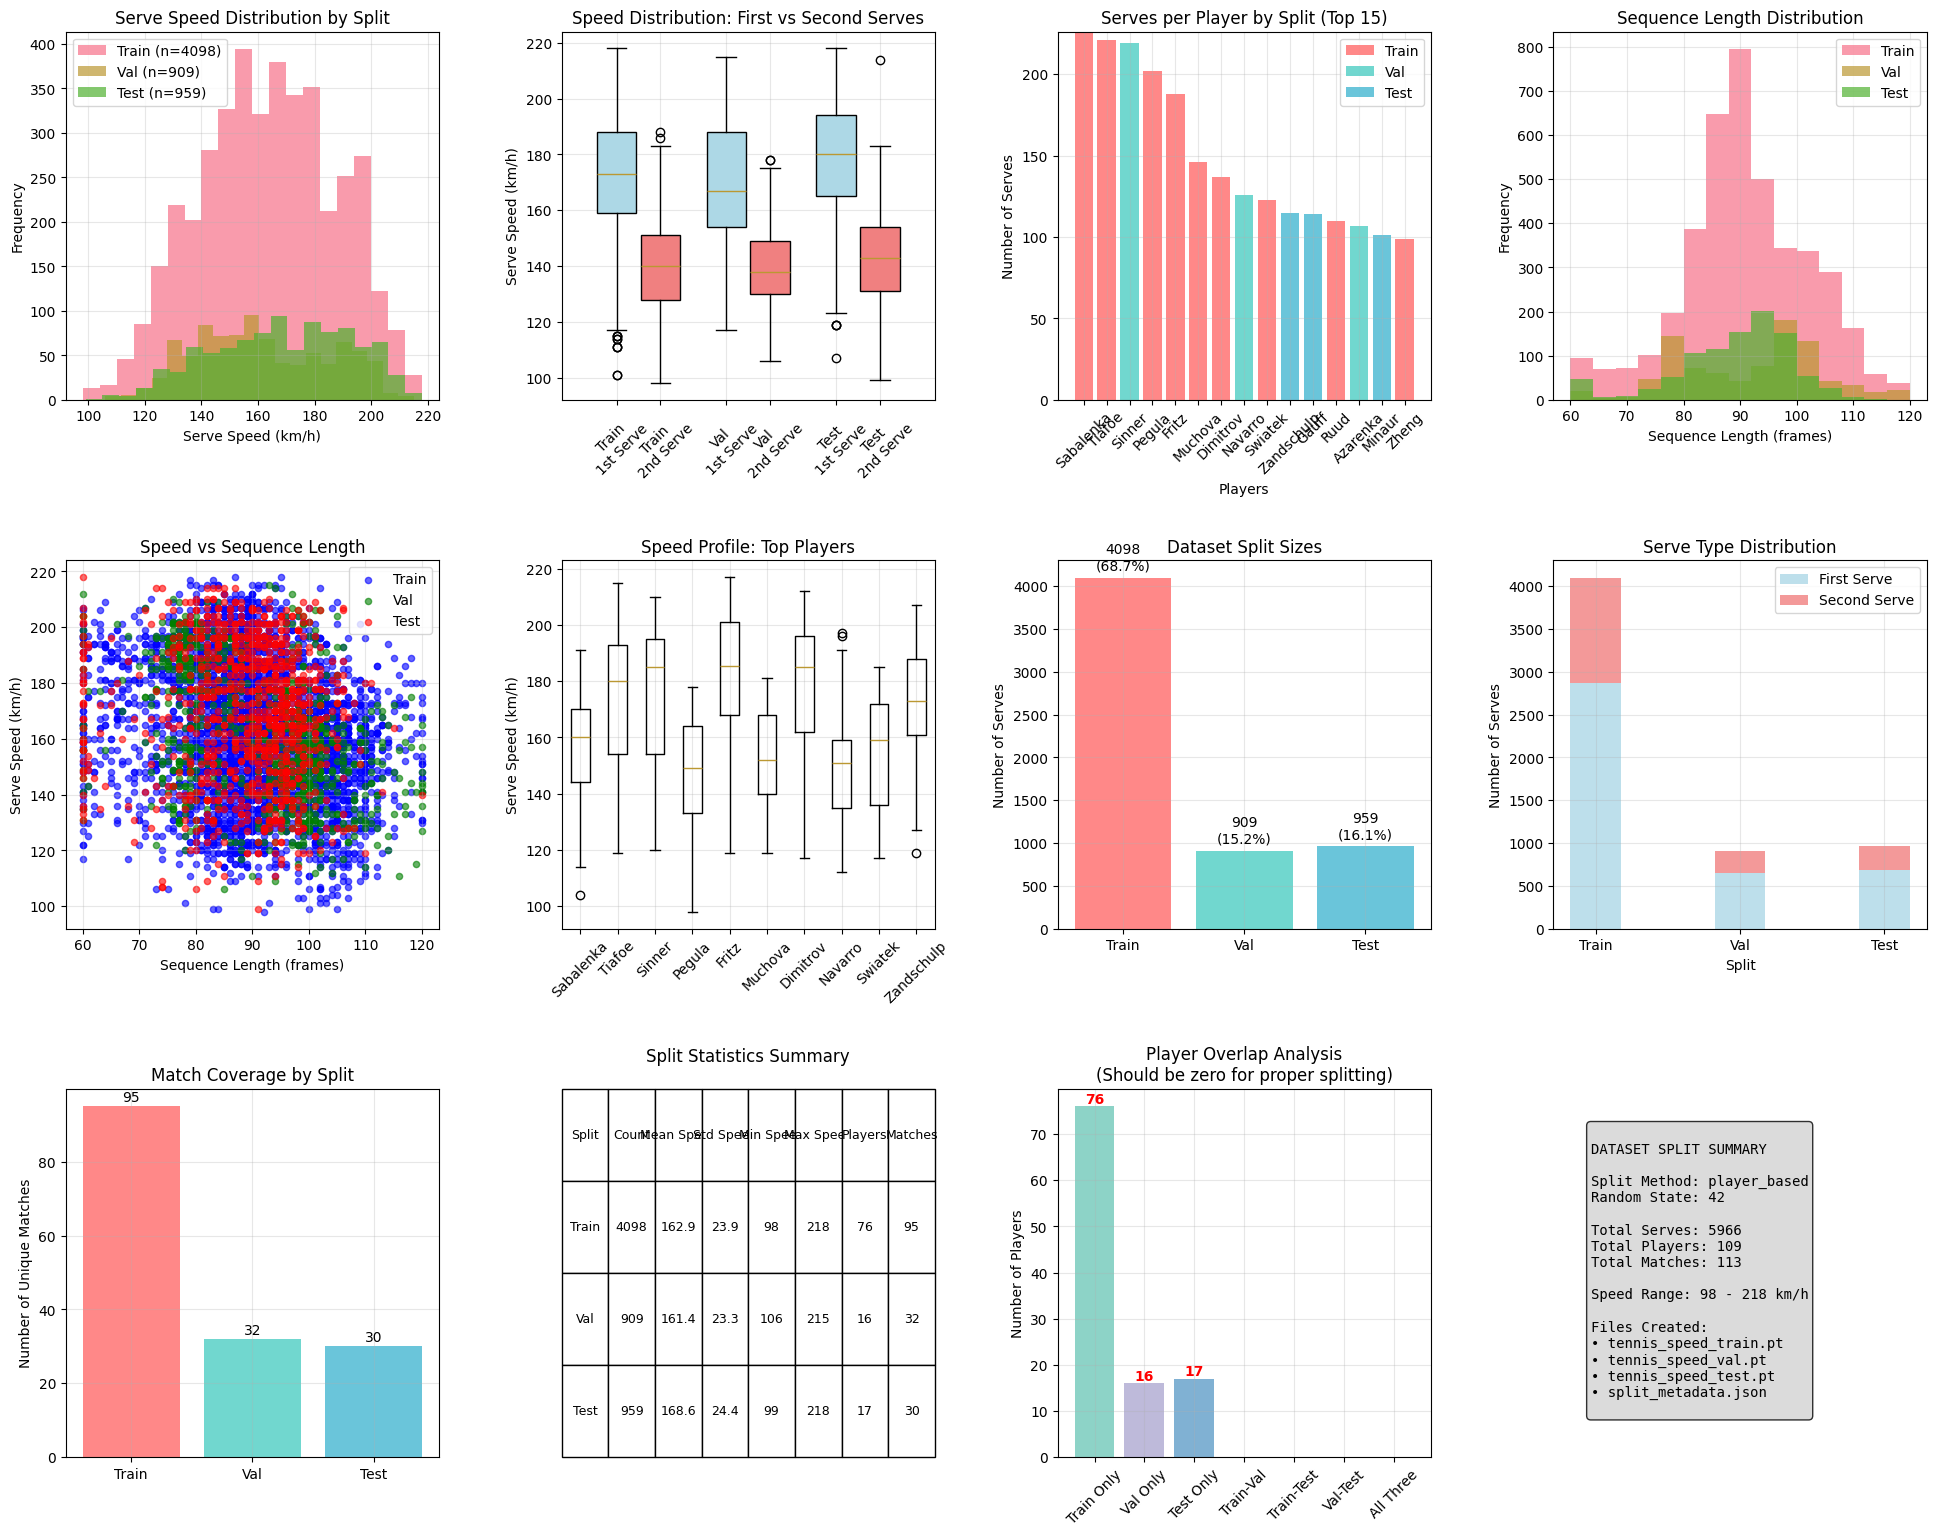


Visualization complete!


In [14]:
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List
from collections import defaultdict, Counter

def load_split_data(data_dir: Path):
    """Load the train/val/test split data and metadata."""
    
    # Load split metadata
    split_metadata_path = data_dir / 'split_metadata.json'
    if not split_metadata_path.exists():
        raise FileNotFoundError(f"Split metadata not found: {split_metadata_path}")
    
    with open(split_metadata_path, 'r') as f:
        split_metadata = json.load(f)
    
    # Load the actual data splits
    splits = {}
    for split_name in ['train', 'val', 'test']:
        split_file = data_dir / f'tennis_speed_{split_name}.pt'
        if split_file.exists():
            splits[split_name] = torch.load(split_file, weights_only=False)
            print(f"Loaded {split_name}: {len(splits[split_name])} serves")
        else:
            print(f"Warning: {split_file} not found")
    
    return splits, split_metadata

def extract_split_info(splits: Dict):
    """Extract detailed information from each split."""
    split_info = {}
    
    for split_name, data_list in splits.items():
        serves_data = []
        
        for data in data_list:
            serve_info = {
                'serve_id': getattr(data, 'serve_id', 'unknown'),
                'server': getattr(data, 'server', 'unknown'),
                'speed': data.y.item(),
                'serve_number': getattr(data, 'serve_number', 0),
                'sequence_length': getattr(data, 'sequence_length', 0),
                'player1': getattr(data, 'player1', 'unknown'),
                'player2': getattr(data, 'player2', 'unknown'),
                'match_id': getattr(data, 'match_id', 'unknown'),
                'set_no': getattr(data, 'set_no', 0),
                'is_ace': getattr(data, 'is_ace', False),
                'is_first_serve': getattr(data, 'serve_number', 1) == 1
            }
            serves_data.append(serve_info)
        
        split_info[split_name] = pd.DataFrame(serves_data)
    
    return split_info

def visualize_splits(split_info: Dict, split_metadata: Dict, save_dir: Path = None):
    """Create comprehensive visualizations of the dataset splits."""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Serve Speed Distribution by Split
    ax1 = plt.subplot(3, 4, 1)
    for split_name, df in split_info.items():
        plt.hist(df['speed'], alpha=0.7, label=f'{split_name.title()} (n={len(df)})', bins=20)
    plt.xlabel('Serve Speed (km/h)')
    plt.ylabel('Frequency')
    plt.title('Serve Speed Distribution by Split')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Speed by Serve Type and Split
    ax2 = plt.subplot(3, 4, 2)
    speed_data = []
    labels = []
    positions = []
    pos = 1
    
    for split_name, df in split_info.items():
        first_serves = df[df['is_first_serve']]['speed']
        second_serves = df[~df['is_first_serve']]['speed']
        
        speed_data.extend([first_serves, second_serves])
        labels.extend([f'{split_name.title()}\n1st Serve', f'{split_name.title()}\n2nd Serve'])
        positions.extend([pos, pos + 0.4])
        pos += 1
    
    bp = plt.boxplot(speed_data, positions=positions, labels=labels, patch_artist=True)
    colors = ['lightblue', 'lightcoral'] * 3
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel('Serve Speed (km/h)')
    plt.title('Speed Distribution: First vs Second Serves')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 3. Number of Serves per Player by Split
    ax3 = plt.subplot(3, 4, 3)
    player_counts = {}
    
    for split_name, df in split_info.items():
        player_counts[split_name] = df['server'].value_counts()
    
    # Create stacked bar chart
    all_players = set()
    for counts in player_counts.values():
        all_players.update(counts.index)
    
    # Sort players by total serves
    player_totals = defaultdict(int)
    for counts in player_counts.values():
        for player, count in counts.items():
            player_totals[player] += count
    
    top_players = sorted(player_totals.items(), key=lambda x: x[1], reverse=True)[:15]
    top_player_names = [p[0] for p in top_players]
    
    bottom = np.zeros(len(top_player_names))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for i, (split_name, counts) in enumerate(player_counts.items()):
        heights = [counts.get(player, 0) for player in top_player_names]
        plt.bar(range(len(top_player_names)), heights, bottom=bottom, 
               label=split_name.title(), color=colors[i], alpha=0.8)
        bottom += heights
    
    plt.xlabel('Players')
    plt.ylabel('Number of Serves')
    plt.title('Serves per Player by Split (Top 15)')
    plt.xticks(range(len(top_player_names)), [p.split()[-1] for p in top_player_names], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Sequence Length Distribution
    ax4 = plt.subplot(3, 4, 4)
    for split_name, df in split_info.items():
        plt.hist(df['sequence_length'], alpha=0.7, label=f'{split_name.title()}', bins=15)
    plt.xlabel('Sequence Length (frames)')
    plt.ylabel('Frequency')
    plt.title('Sequence Length Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Speed vs Sequence Length
    ax5 = plt.subplot(3, 4, 5)
    colors_dict = {'train': 'blue', 'val': 'green', 'test': 'red'}
    
    for split_name, df in split_info.items():
        plt.scatter(df['sequence_length'], df['speed'], 
                   alpha=0.6, label=f'{split_name.title()}', 
                   color=colors_dict[split_name], s=20)
    
    plt.xlabel('Sequence Length (frames)')
    plt.ylabel('Serve Speed (km/h)')
    plt.title('Speed vs Sequence Length')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Player Speed Profiles (Top Players)
    ax6 = plt.subplot(3, 4, 6)
    
    # Get top 10 players by serve count
    all_serves = pd.concat(split_info.values())
    top_servers = all_serves['server'].value_counts().head(10).index
    
    player_speeds = []
    player_labels = []
    
    for player in top_servers:
        player_serves = all_serves[all_serves['server'] == player]['speed']
        if len(player_serves) >= 5:  # Only include players with at least 5 serves
            player_speeds.append(player_serves)
            player_labels.append(player.split()[-1])  # Last name only
    
    if player_speeds:
        plt.boxplot(player_speeds, labels=player_labels)
        plt.ylabel('Serve Speed (km/h)')
        plt.title('Speed Profile: Top Players')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 7. Split Size Comparison
    ax7 = plt.subplot(3, 4, 7)
    split_sizes = [len(df) for df in split_info.values()]
    split_names = [name.title() for name in split_info.keys()]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = plt.bar(split_names, split_sizes, color=colors, alpha=0.8)
    plt.ylabel('Number of Serves')
    plt.title('Dataset Split Sizes')
    
    # Add percentage labels on bars
    total = sum(split_sizes)
    for bar, size in zip(bars, split_sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01,
                f'{size}\n({size/total*100:.1f}%)', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    # 8. Serve Type Distribution by Split
    ax8 = plt.subplot(3, 4, 8)
    
    serve_type_data = []
    for split_name, df in split_info.items():
        first_count = df['is_first_serve'].sum()
        second_count = len(df) - first_count
        serve_type_data.append([first_count, second_count])
    
    serve_type_data = np.array(serve_type_data).T
    
    x = np.arange(len(split_names))
    width = 0.35
    
    plt.bar(x, serve_type_data[0], width, label='First Serve', color='lightblue', alpha=0.8)
    plt.bar(x, serve_type_data[1], width, bottom=serve_type_data[0], 
           label='Second Serve', color='lightcoral', alpha=0.8)
    
    plt.xlabel('Split')
    plt.ylabel('Number of Serves')
    plt.title('Serve Type Distribution')
    plt.xticks(x, split_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. Match Coverage by Split
    ax9 = plt.subplot(3, 4, 9)
    
    match_counts = {}
    for split_name, df in split_info.items():
        unique_matches = df['match_id'].nunique()
        match_counts[split_name] = unique_matches
    
    bars = plt.bar(split_names, list(match_counts.values()), 
                  color=colors, alpha=0.8)
    plt.ylabel('Number of Unique Matches')
    plt.title('Match Coverage by Split')
    
    for bar, count in zip(bars, match_counts.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{count}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    # 10. Speed Statistics Summary Table
    ax10 = plt.subplot(3, 4, 10)
    ax10.axis('tight')
    ax10.axis('off')
    
    # Create summary statistics table
    stats_data = []
    for split_name, df in split_info.items():
        stats = {
            'Split': split_name.title(),
            'Count': len(df),
            'Mean Speed': f"{df['speed'].mean():.1f}",
            'Std Speed': f"{df['speed'].std():.1f}",
            'Min Speed': f"{df['speed'].min():.0f}",
            'Max Speed': f"{df['speed'].max():.0f}",
            'Players': df['server'].nunique(),
            'Matches': df['match_id'].nunique()
        }
        stats_data.append(stats)
    
    stats_df = pd.DataFrame(stats_data)
    table = ax10.table(cellText=stats_df.values, colLabels=stats_df.columns,
                      cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Split Statistics Summary', pad=20)
    
    # 11. Player Overlap Analysis
    ax11 = plt.subplot(3, 4, 11)
    
    # Check for player overlap between splits (should be zero for proper splitting)
    train_players = set(split_info['train']['server'].unique())
    val_players = set(split_info['val']['server'].unique()) if 'val' in split_info else set()
    test_players = set(split_info['test']['server'].unique()) if 'test' in split_info else set()
    
    # Create Venn diagram-like visualization
    overlap_data = {
        'Train Only': len(train_players - val_players - test_players),
        'Val Only': len(val_players - train_players - test_players),
        'Test Only': len(test_players - train_players - val_players),
        'Train-Val': len(train_players & val_players - test_players),
        'Train-Test': len(train_players & test_players - val_players),
        'Val-Test': len(val_players & test_players - train_players),
        'All Three': len(train_players & val_players & test_players)
    }
    
    labels = list(overlap_data.keys())
    values = list(overlap_data.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    
    bars = plt.bar(labels, values, color=colors)
    plt.ylabel('Number of Players')
    plt.title('Player Overlap Analysis\n(Should be zero for proper splitting)')
    plt.xticks(rotation=45)
    
    for bar, value in zip(bars, values):
        if value > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value}', ha='center', va='bottom', fontweight='bold', color='red')
    
    plt.grid(True, alpha=0.3)
    
    # 12. Additional info text
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    info_text = f"""
DATASET SPLIT SUMMARY

Split Method: {split_metadata.get('split_method', 'unknown')}
Random State: {split_metadata.get('random_state', 'unknown')}

Total Serves: {sum(len(df) for df in split_info.values())}
Total Players: {len(set().union(*[df['server'].unique() for df in split_info.values()]))}
Total Matches: {len(set().union(*[df['match_id'].unique() for df in split_info.values()]))}

Speed Range: {min(df['speed'].min() for df in split_info.values()):.0f} - {max(df['speed'].max() for df in split_info.values()):.0f} km/h

Files Created:
• tennis_speed_train.pt
• tennis_speed_val.pt  
• tennis_speed_test.pt
• split_metadata.json
    """
    
    ax12.text(0.1, 0.9, info_text, transform=ax12.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout(pad=3.0)
    
    if save_dir:
        save_path = save_dir / 'dataset_split_analysis.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()
    
    return fig

def print_split_summary(split_info: Dict, split_metadata: Dict):
    """Print a detailed text summary of the splits."""
    
    print("\n" + "="*80)
    print("TENNIS DATASET SPLIT ANALYSIS")
    print("="*80)
    
    print(f"Split Method: {split_metadata.get('split_method', 'unknown')}")
    print(f"Split Ratios: {split_metadata.get('split_ratios', {})}")
    
    total_serves = sum(len(df) for df in split_info.values())
    all_players = set().union(*[df['server'].unique() for df in split_info.values()])
    all_matches = set().union(*[df['match_id'].unique() for df in split_info.values()])
    
    print(f"\nOverall Dataset:")
    print(f"  Total Serves: {total_serves}")
    print(f"  Unique Players: {len(all_players)}")
    print(f"  Unique Matches: {len(all_matches)}")
    
    for split_name, df in split_info.items():
        print(f"\n{split_name.upper()} Split:")
        print(f"  Serves: {len(df)} ({len(df)/total_serves*100:.1f}%)")
        print(f"  Players: {df['server'].nunique()}")
        print(f"  Matches: {df['match_id'].nunique()}")
        print(f"  Speed: {df['speed'].mean():.1f} ± {df['speed'].std():.1f} km/h")
        print(f"  Range: {df['speed'].min():.0f} - {df['speed'].max():.0f} km/h")
        print(f"  First serves: {df['is_first_serve'].sum()} ({df['is_first_serve'].mean()*100:.1f}%)")
        print(f"  Avg sequence length: {df['sequence_length'].mean():.1f} frames")
        
        # Top players in this split
        top_players = df['server'].value_counts().head(3)
        print(f"  Top players: {', '.join([f'{p} ({c})' for p, c in top_players.items()])}")

def main():
    """Main function to visualize the tennis dataset splits."""
    
    # Update this path to your processed data directory
    DATA_DIR = Path("/project/vil_baek/psaap/tennis/processed_tennis_speed_data")
    
    try:
        # Load the split data
        print("Loading dataset splits...")
        splits, split_metadata = load_split_data(DATA_DIR)
        
        # Extract detailed information
        print("Extracting split information...")
        split_info = extract_split_info(splits)
        
        # Print text summary
        print_split_summary(split_info, split_metadata)
        
        # Create visualizations
        print("\nCreating visualizations...")
        fig = visualize_splits(split_info, split_metadata, save_dir=DATA_DIR)
        
        print("\nVisualization complete!")
        
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure you have run the full dataset processing first.")

if __name__ == "__main__":
    main()

# Normalization of already processed data 

In [ ]:
import json
import numpy as np
import torch
from pathlib import Path
from typing import Dict, List, Tuple, Union
from collections import defaultdict
import pickle

class TennisDataNormalizer:
    """
    Comprehensive normalizer for tennis serve data.
    Computes statistics from training data and applies 0-1 normalization.
    """
    
    def __init__(self):
        self.feature_stats = {}
        self.target_stats = {}
        self.global_stats = {}
        self.is_fitted = False
        
    def fit(self, train_data: List, save_path: str = None):
        """
        Compute normalization statistics from training data.
        
        Args:
            train_data: List of Data objects from training set
            save_path: Optional path to save statistics
        """
        print("Computing normalization statistics from training data...")
        
        # Collect all features and targets
        all_features = []  # Will be shape [total_samples, joints, timesteps, features]
        all_targets = []
        all_sequence_lengths = []
        all_serve_types = []
        all_set_numbers = []
        all_game_numbers = []
        
        for data in train_data:
            # Features: [joints, timesteps, features] -> flatten to [joints*timesteps, features]
            features_flat = data.x.view(-1, data.x.shape[-1])  # [joints*timesteps, features]
            all_features.append(features_flat)
            
            # Target
            all_targets.append(data.y.item())
            
            # Global context features
            all_sequence_lengths.append(data.sequence_length)
            all_serve_types.append(data.serve_number)
            
            if hasattr(data, 'set_no'):
                all_set_numbers.append(data.set_no)
            if hasattr(data, 'game_no'):
                all_game_numbers.append(data.game_no)
        
        # Stack all features
        all_features = torch.cat(all_features, dim=0)  # [total_joint_timesteps, feature_dim]
        
        print(f"Collected features from {len(train_data)} serves:")
        print(f"  Feature tensor shape: {all_features.shape}")
        print(f"  Target range: {min(all_targets):.1f} - {max(all_targets):.1f} km/h")
        
        # Compute feature statistics (per feature dimension)
        feature_dim = all_features.shape[1]
        self.feature_stats = {}
        
        for feat_idx in range(feature_dim):
            feat_values = all_features[:, feat_idx]
            
            # Remove any invalid values
            valid_mask = torch.isfinite(feat_values)
            valid_values = feat_values[valid_mask]
            
            if len(valid_values) > 0:
                min_val = valid_values.min().item()
                max_val = valid_values.max().item()
                
                self.feature_stats[feat_idx] = {
                    'min': min_val,
                    'max': max_val,
                    'range': max_val - min_val if max_val != min_val else 1.0,
                    'mean': valid_values.mean().item(),
                    'std': valid_values.std().item()
                }
            else:
                # Fallback for empty/invalid features
                self.feature_stats[feat_idx] = {
                    'min': 0.0,
                    'max': 1.0,
                    'range': 1.0,
                    'mean': 0.0,
                    'std': 1.0
                }
        
        # Compute target statistics
        all_targets = np.array(all_targets)
        self.target_stats = {
            'min': float(all_targets.min()),
            'max': float(all_targets.max()),
            'range': float(all_targets.max() - all_targets.min()),
            'mean': float(all_targets.mean()),
            'std': float(all_targets.std())
        }
        
        # Compute global feature statistics
        all_sequence_lengths = np.array(all_sequence_lengths)
        all_serve_types = np.array(all_serve_types)
        
        self.global_stats = {
            'sequence_length': {
                'min': float(all_sequence_lengths.min()),
                'max': float(all_sequence_lengths.max()),
                'range': float(all_sequence_lengths.max() - all_sequence_lengths.min())
            },
            'serve_type': {
                'min': 1.0,  # serve_number is 1 or 2
                'max': 2.0,
                'range': 1.0
            },
            'set_number': {
                'min': float(min(all_set_numbers)) if all_set_numbers else 1.0,
                'max': float(max(all_set_numbers)) if all_set_numbers else 5.0,
                'range': float(max(all_set_numbers) - min(all_set_numbers)) if all_set_numbers else 4.0
            },
            'game_number': {
                'min': float(min(all_game_numbers)) if all_game_numbers else 1.0,
                'max': float(max(all_game_numbers)) if all_game_numbers else 13.0,
                'range': float(max(all_game_numbers) - min(all_game_numbers)) if all_game_numbers else 12.0
            }
        }
        
        self.is_fitted = True
        
        # Print statistics summary
        print(f"\nNormalization Statistics Summary:")
        print(f"Feature Statistics (6 features per joint):")
        for feat_idx in range(min(6, feature_dim)):  # Show first 6 features
            stats = self.feature_stats[feat_idx]
            print(f"  Feature {feat_idx}: [{stats['min']:.3f}, {stats['max']:.3f}] (range: {stats['range']:.3f})")
        
        print(f"\nTarget Statistics:")
        print(f"  Speed: [{self.target_stats['min']:.1f}, {self.target_stats['max']:.1f}] km/h")
        
        print(f"\nGlobal Feature Statistics:")
        for key, stats in self.global_stats.items():
            print(f"  {key}: [{stats['min']:.1f}, {stats['max']:.1f}] (range: {stats['range']:.1f})")
        
        # Save statistics if path provided
        if save_path:
            self.save_stats(save_path)
            
        return self
    
    def normalize_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize features to [0, 1] range.
        
        Args:
            x: Feature tensor of shape [joints, timesteps, features] or [joints*timesteps, features]
        Returns:
            Normalized features in same shape
        """
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before use")
        
        original_shape = x.shape
        
        # Flatten if needed
        if len(x.shape) == 3:
            x_flat = x.view(-1, x.shape[-1])  # [joints*timesteps, features]
        else:
            x_flat = x
        
        # Normalize each feature dimension
        x_normalized = x_flat.clone()
        for feat_idx in range(x_flat.shape[1]):
            if feat_idx in self.feature_stats:
                stats = self.feature_stats[feat_idx]
                
                # Min-max normalization to [0, 1]
                if stats['range'] > 1e-8:  # Avoid division by zero
                    x_normalized[:, feat_idx] = (x_flat[:, feat_idx] - stats['min']) / stats['range']
                else:
                    x_normalized[:, feat_idx] = 0.0  # Constant feature -> set to 0
                
                # Clamp to [0, 1] to handle any outliers
                x_normalized[:, feat_idx] = torch.clamp(x_normalized[:, feat_idx], 0.0, 1.0)
        
        # Reshape back to original shape
        if len(original_shape) == 3:
            return x_normalized.view(original_shape)
        else:
            return x_normalized
    
    def normalize_target(self, y: torch.Tensor) -> torch.Tensor:
        """Normalize target (serve speed) to [0, 1] range."""
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before use")
        
        # Min-max normalization for targets
        y_normalized = (y - self.target_stats['min']) / self.target_stats['range']
        return torch.clamp(y_normalized, 0.0, 1.0)
    
    def denormalize_target(self, y_normalized: torch.Tensor) -> torch.Tensor:
        """Convert normalized target back to original scale (km/h)."""
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before use")
        
        return y_normalized * self.target_stats['range'] + self.target_stats['min']
    
    def normalize_global_context(self, serve_number: int, sequence_length: int, 
                                set_no: int = None, game_no: int = None) -> torch.Tensor:
        """Normalize global context features to [0, 1] range."""
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before use")
        
        global_features = []
        
        # Serve type (1 or 2 -> normalize to [0, 1])
        serve_normalized = (serve_number - self.global_stats['serve_type']['min']) / self.global_stats['serve_type']['range']
        global_features.append(serve_normalized)
        
        # Sequence length
        seq_stats = self.global_stats['sequence_length']
        seq_normalized = (sequence_length - seq_stats['min']) / seq_stats['range']
        global_features.append(max(0.0, min(1.0, seq_normalized)))  # Clamp to [0, 1]
        
        # Set number
        if set_no is not None:
            set_stats = self.global_stats['set_number']
            set_normalized = (set_no - set_stats['min']) / set_stats['range']
            global_features.append(max(0.0, min(1.0, set_normalized)))
        else:
            global_features.append(0.2)  # Default normalized value
        
        # Game number
        if game_no is not None:
            game_stats = self.global_stats['game_number']
            game_normalized = (game_no - game_stats['min']) / game_stats['range']
            global_features.append(max(0.0, min(1.0, game_normalized)))
        else:
            global_features.append(0.5)  # Default normalized value
        
        return torch.tensor(global_features, dtype=torch.float32)
    
    def save_stats(self, filepath: str):
        """Save normalization statistics to file."""
        stats_dict = {
            'feature_stats': self.feature_stats,
            'target_stats': self.target_stats,
            'global_stats': self.global_stats,
            'is_fitted': self.is_fitted
        }
        
        with open(filepath, 'w') as f:
            json.dump(stats_dict, f, indent=2)
        print(f"Normalization statistics saved to: {filepath}")
    
    def load_stats(self, filepath: str):
        """Load normalization statistics from file."""
        with open(filepath, 'r') as f:
            stats_dict = json.load(f)
        
        self.feature_stats = {int(k): v for k, v in stats_dict['feature_stats'].items()}
        self.target_stats = stats_dict['target_stats']
        self.global_stats = stats_dict['global_stats']
        self.is_fitted = stats_dict['is_fitted']
        print(f"Normalization statistics loaded from: {filepath}")
        return self


def create_normalized_datasets(train_file: str, val_file: str, test_file: str, 
                             output_dir: str = "./normalized_tennis_data"):
    """
    Create normalized versions of train/val/test datasets.
    
    Args:
        train_file, val_file, test_file: Paths to original .pt files
        output_dir: Directory to save normalized datasets
    """
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    print("Loading original datasets...")
    train_data = torch.load(train_file, weights_only=False)
    val_data = torch.load(val_file, weights_only=False)
    test_data = torch.load(test_file, weights_only=False)
    
    print(f"Loaded {len(train_data)} train, {len(val_data)} val, {len(test_data)} test samples")
    
    # Fit normalizer on training data
    normalizer = TennisDataNormalizer()
    normalizer.fit(train_data, save_path=str(output_path / "normalization_stats.json"))
    
    # Normalize each dataset
    def normalize_dataset(dataset, split_name):
        print(f"\nNormalizing {split_name} dataset...")
        normalized_data = []
        
        for i, data in enumerate(dataset):
            # Clone the original data
            normalized_data_obj = data.clone()
            
            # Normalize features
            normalized_data_obj.x = normalizer.normalize_features(data.x)
            
            # Normalize target
            normalized_data_obj.y = normalizer.normalize_target(data.y)
            
            # Add original target for reference (optional)
            normalized_data_obj.y_original = data.y.clone()
            
            normalized_data.append(normalized_data_obj)
        
        return normalized_data
    
    # Normalize all splits
    normalized_train = normalize_dataset(train_data, "train")
    normalized_val = normalize_dataset(val_data, "val")
    normalized_test = normalize_dataset(test_data, "test")
    
    # Save normalized datasets
    torch.save(normalized_train, output_path / "tennis_speed_train_normalized.pt")
    torch.save(normalized_val, output_path / "tennis_speed_val_normalized.pt")
    torch.save(normalized_test, output_path / "tennis_speed_test_normalized.pt")
    
    print(f"\nNormalized datasets saved to: {output_path}")
    print("Files created:")
    print(f"  - tennis_speed_train_normalized.pt ({len(normalized_train)} samples)")
    print(f"  - tennis_speed_val_normalized.pt ({len(normalized_val)} samples)")
    print(f"  - tennis_speed_test_normalized.pt ({len(normalized_test)} samples)")
    print(f"  - normalization_stats.json (statistics for denormalization)")
    
    # Print sample before/after
    sample_idx = 0
    original = train_data[sample_idx]
    normalized = normalized_train[sample_idx]
    
    print(f"\nSample normalization (serve {sample_idx}):")
    print(f"  Original target: {original.y.item():.1f} km/h")
    print(f"  Normalized target: {normalized.y.item():.3f}")
    print(f"  Feature range before: [{original.x.min():.3f}, {original.x.max():.3f}]")
    print(f"  Feature range after: [{normalized.x.min():.3f}, {normalized.x.max():.3f}]")
    
    return normalizer, normalized_train, normalized_val, normalized_test


# Updated model with normalization support
class NormalizedTennisPredictor:
    """
    Wrapper for TennisServeSpeedPredictor that handles normalization/denormalization.
    """
    
    def __init__(self, model, normalizer: TennisDataNormalizer):
        self.model = model
        self.normalizer = normalizer
        
    def forward(self, data):
        """Forward pass with automatic denormalization of output."""
        # Model expects normalized input, produces normalized output
        normalized_prediction = self.model(data)
        
        # Denormalize prediction back to km/h
        denormalized_prediction = self.normalizer.denormalize_target(normalized_prediction)
        
        return denormalized_prediction
    
    def __call__(self, data):
        return self.forward(data)


# Updated global context extraction for normalized model
def extract_normalized_global_context(data, normalizer: TennisDataNormalizer):
    """Extract and normalize global context features."""
    serve_number = getattr(data, 'serve_number', 1)
    sequence_length = getattr(data, 'sequence_length', 80)
    set_no = getattr(data, 'set_no', None)
    game_no = getattr(data, 'game_no', None)
    
    return normalizer.normalize_global_context(serve_number, sequence_length, set_no, game_no)


# Example usage function
def normalize_tennis_datasets():
    """
    Main function to normalize existing tennis datasets.
    Run this to create normalized versions of your data.
    """
    
    # Paths to your original datasets
    DATA_DIR = "/project/vil_baek/psaap/tennis/processed_tennis_speed_data"
    train_file = f"{DATA_DIR}/tennis_speed_train.pt"
    val_file = f"{DATA_DIR}/tennis_speed_val.pt"
    test_file = f"{DATA_DIR}/tennis_speed_test.pt"
    
    # Create normalized datasets
    normalizer, norm_train, norm_val, norm_test = create_normalized_datasets(
        train_file, val_file, test_file,
        output_dir=f"{DATA_DIR}/normalized"
    )
    
    print(f"\n✅ Normalization complete!")
    print(f"Use the normalized datasets for training:")
    print(f"  - {DATA_DIR}/normalized/tennis_speed_train_normalized.pt")
    print(f"  - {DATA_DIR}/normalized/tennis_speed_val_normalized.pt")
    print(f"  - {DATA_DIR}/normalized/tennis_speed_test_normalized.pt")
    
    return normalizer

# To run normalization:
# normalizer = normalize_tennis_datasets()import json
import numpy as np
import torch
from pathlib import Path
from typing import Dict, List, Tuple, Union
from collections import defaultdict
import pickle

class TennisDataNormalizer:
    """
    Comprehensive normalizer for tennis serve data.
    Computes statistics from training data and applies 0-1 normalization.
    """
    
    def __init__(self):
        self.feature_stats = {}
        self.target_stats = {}
        self.global_stats = {}
        self.is_fitted = False
        
    def fit(self, train_data: List, save_path: str = None):
        """
        Compute normalization statistics from training data.
        
        Args:
            train_data: List of Data objects from training set
            save_path: Optional path to save statistics
        """
        print("Computing normalization statistics from training data...")
        
        # Collect all features and targets
        all_features = []  # Will be shape [total_samples, joints, timesteps, features]
        all_targets = []
        all_sequence_lengths = []
        all_serve_types = []
        all_set_numbers = []
        all_game_numbers = []
        
        for data in train_data:
            # Features: [joints, timesteps, features] -> flatten to [joints*timesteps, features]
            features_flat = data.x.view(-1, data.x.shape[-1])  # [joints*timesteps, features]
            all_features.append(features_flat)
            
            # Target
            all_targets.append(data.y.item())
            
            # Global context features
            all_sequence_lengths.append(data.sequence_length)
            all_serve_types.append(data.serve_number)
            
            if hasattr(data, 'set_no'):
                all_set_numbers.append(data.set_no)
            if hasattr(data, 'game_no'):
                all_game_numbers.append(data.game_no)
        
        # Stack all features
        all_features = torch.cat(all_features, dim=0)  # [total_joint_timesteps, feature_dim]
        
        print(f"Collected features from {len(train_data)} serves:")
        print(f"  Feature tensor shape: {all_features.shape}")
        print(f"  Target range: {min(all_targets):.1f} - {max(all_targets):.1f} km/h")
        
        # Compute feature statistics (per feature dimension)
        feature_dim = all_features.shape[1]
        self.feature_stats = {}
        
        for feat_idx in range(feature_dim):
            feat_values = all_features[:, feat_idx]
            
            # Remove any invalid values
            valid_mask = torch.isfinite(feat_values)
            valid_values = feat_values[valid_mask]
            
            if len(valid_values) > 0:
                min_val = valid_values.min().item()
                max_val = valid_values.max().item()
                
                self.feature_stats[feat_idx] = {
                    'min': min_val,
                    'max': max_val,
                    'range': max_val - min_val if max_val != min_val else 1.0,
                    'mean': valid_values.mean().item(),
                    'std': valid_values.std().item()
                }
            else:
                # Fallback for empty/invalid features
                self.feature_stats[feat_idx] = {
                    'min': 0.0,
                    'max': 1.0,
                    'range': 1.0,
                    'mean': 0.0,
                    'std': 1.0
                }
        
        # Compute target statistics
        all_targets = np.array(all_targets)
        self.target_stats = {
            'min': float(all_targets.min()),
            'max': float(all_targets.max()),
            'range': float(all_targets.max() - all_targets.min()),
            'mean': float(all_targets.mean()),
            'std': float(all_targets.std())
        }
        
        # Compute global feature statistics
        all_sequence_lengths = np.array(all_sequence_lengths)
        all_serve_types = np.array(all_serve_types)
        
        self.global_stats = {
            'sequence_length': {
                'min': float(all_sequence_lengths.min()),
                'max': float(all_sequence_lengths.max()),
                'range': float(all_sequence_lengths.max() - all_sequence_lengths.min())
            },
            'serve_type': {
                'min': 1.0,  # serve_number is 1 or 2
                'max': 2.0,
                'range': 1.0
            },
            'set_number': {
                'min': float(min(all_set_numbers)) if all_set_numbers else 1.0,
                'max': float(max(all_set_numbers)) if all_set_numbers else 5.0,
                'range': float(max(all_set_numbers) - min(all_set_numbers)) if all_set_numbers else 4.0
            },
            'game_number': {
                'min': float(min(all_game_numbers)) if all_game_numbers else 1.0,
                'max': float(max(all_game_numbers)) if all_game_numbers else 13.0,
                'range': float(max(all_game_numbers) - min(all_game_numbers)) if all_game_numbers else 12.0
            }
        }
        
        self.is_fitted = True
        
        # Print statistics summary
        print(f"\nNormalization Statistics Summary:")
        print(f"Feature Statistics (6 features per joint):")
        for feat_idx in range(min(6, feature_dim)):  # Show first 6 features
            stats = self.feature_stats[feat_idx]
            print(f"  Feature {feat_idx}: [{stats['min']:.3f}, {stats['max']:.3f}] (range: {stats['range']:.3f})")
        
        print(f"\nTarget Statistics:")
        print(f"  Speed: [{self.target_stats['min']:.1f}, {self.target_stats['max']:.1f}] km/h")
        
        print(f"\nGlobal Feature Statistics:")
        for key, stats in self.global_stats.items():
            print(f"  {key}: [{stats['min']:.1f}, {stats['max']:.1f}] (range: {stats['range']:.1f})")
        
        # Save statistics if path provided
        if save_path:
            self.save_stats(save_path)
            
        return self
    
    def normalize_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize features to [0, 1] range.
        
        Args:
            x: Feature tensor of shape [joints, timesteps, features] or [joints*timesteps, features]
        Returns:
            Normalized features in same shape
        """
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before use")
        
        original_shape = x.shape
        
        # Flatten if needed
        if len(x.shape) == 3:
            x_flat = x.view(-1, x.shape[-1])  # [joints*timesteps, features]
        else:
            x_flat = x
        
        # Normalize each feature dimension
        x_normalized = x_flat.clone()
        for feat_idx in range(x_flat.shape[1]):
            if feat_idx in self.feature_stats:
                stats = self.feature_stats[feat_idx]
                
                # Min-max normalization to [0, 1]
                if stats['range'] > 1e-8:  # Avoid division by zero
                    x_normalized[:, feat_idx] = (x_flat[:, feat_idx] - stats['min']) / stats['range']
                else:
                    x_normalized[:, feat_idx] = 0.0  # Constant feature -> set to 0
                
                # Clamp to [0, 1] to handle any outliers
                x_normalized[:, feat_idx] = torch.clamp(x_normalized[:, feat_idx], 0.0, 1.0)
        
        # Reshape back to original shape
        if len(original_shape) == 3:
            return x_normalized.view(original_shape)
        else:
            return x_normalized
    
    def normalize_target(self, y: torch.Tensor) -> torch.Tensor:
        """Normalize target (serve speed) to [0, 1] range."""
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before use")
        
        # Min-max normalization for targets
        y_normalized = (y - self.target_stats['min']) / self.target_stats['range']
        return torch.clamp(y_normalized, 0.0, 1.0)
    
    def denormalize_target(self, y_normalized: torch.Tensor) -> torch.Tensor:
        """Convert normalized target back to original scale (km/h)."""
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before use")
        
        return y_normalized * self.target_stats['range'] + self.target_stats['min']
    
    def normalize_global_context(self, serve_number: int, sequence_length: int, 
                                set_no: int = None, game_no: int = None) -> torch.Tensor:
        """Normalize global context features to [0, 1] range."""
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before use")
        
        global_features = []
        
        # Serve type (1 or 2 -> normalize to [0, 1])
        serve_normalized = (serve_number - self.global_stats['serve_type']['min']) / self.global_stats['serve_type']['range']
        global_features.append(serve_normalized)
        
        # Sequence length
        seq_stats = self.global_stats['sequence_length']
        seq_normalized = (sequence_length - seq_stats['min']) / seq_stats['range']
        global_features.append(max(0.0, min(1.0, seq_normalized)))  # Clamp to [0, 1]
        
        # Set number
        if set_no is not None:
            set_stats = self.global_stats['set_number']
            set_normalized = (set_no - set_stats['min']) / set_stats['range']
            global_features.append(max(0.0, min(1.0, set_normalized)))
        else:
            global_features.append(0.2)  # Default normalized value
        
        # Game number
        if game_no is not None:
            game_stats = self.global_stats['game_number']
            game_normalized = (game_no - game_stats['min']) / game_stats['range']
            global_features.append(max(0.0, min(1.0, game_normalized)))
        else:
            global_features.append(0.5)  # Default normalized value
        
        return torch.tensor(global_features, dtype=torch.float32)
    
    def save_stats(self, filepath: str):
        """Save normalization statistics to file."""
        stats_dict = {
            'feature_stats': self.feature_stats,
            'target_stats': self.target_stats,
            'global_stats': self.global_stats,
            'is_fitted': self.is_fitted
        }
        
        with open(filepath, 'w') as f:
            json.dump(stats_dict, f, indent=2)
        print(f"Normalization statistics saved to: {filepath}")
    
    def load_stats(self, filepath: str):
        """Load normalization statistics from file."""
        with open(filepath, 'r') as f:
            stats_dict = json.load(f)
        
        self.feature_stats = {int(k): v for k, v in stats_dict['feature_stats'].items()}
        self.target_stats = stats_dict['target_stats']
        self.global_stats = stats_dict['global_stats']
        self.is_fitted = stats_dict['is_fitted']
        print(f"Normalization statistics loaded from: {filepath}")
        return self


def create_normalized_datasets(train_file: str, val_file: str, test_file: str, 
                             output_dir: str = "./normalized_tennis_data"):
    """
    Create normalized versions of train/val/test datasets.
    
    Args:
        train_file, val_file, test_file: Paths to original .pt files
        output_dir: Directory to save normalized datasets
    """
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    print("Loading original datasets...")
    train_data = torch.load(train_file, weights_only=False)
    val_data = torch.load(val_file, weights_only=False)
    test_data = torch.load(test_file, weights_only=False)
    
    print(f"Loaded {len(train_data)} train, {len(val_data)} val, {len(test_data)} test samples")
    
    # Fit normalizer on training data
    normalizer = TennisDataNormalizer()
    normalizer.fit(train_data, save_path=str(output_path / "normalization_stats.json"))
    
    # Normalize each dataset
    def normalize_dataset(dataset, split_name):
        print(f"\nNormalizing {split_name} dataset...")
        normalized_data = []
        
        for i, data in enumerate(dataset):
            # Clone the original data
            normalized_data_obj = data.clone()
            
            # Normalize features
            normalized_data_obj.x = normalizer.normalize_features(data.x)
            
            # Normalize target
            normalized_data_obj.y = normalizer.normalize_target(data.y)
            
            # Add original target for reference (optional)
            normalized_data_obj.y_original = data.y.clone()
            
            normalized_data.append(normalized_data_obj)
        
        return normalized_data
    
    # Normalize all splits
    normalized_train = normalize_dataset(train_data, "train")
    normalized_val = normalize_dataset(val_data, "val")
    normalized_test = normalize_dataset(test_data, "test")
    
    # Save normalized datasets
    torch.save(normalized_train, output_path / "tennis_speed_train_normalized.pt")
    torch.save(normalized_val, output_path / "tennis_speed_val_normalized.pt")
    torch.save(normalized_test, output_path / "tennis_speed_test_normalized.pt")
    
    print(f"\nNormalized datasets saved to: {output_path}")
    print("Files created:")
    print(f"  - tennis_speed_train_normalized.pt ({len(normalized_train)} samples)")
    print(f"  - tennis_speed_val_normalized.pt ({len(normalized_val)} samples)")
    print(f"  - tennis_speed_test_normalized.pt ({len(normalized_test)} samples)")
    print(f"  - normalization_stats.json (statistics for denormalization)")
    
    # Print sample before/after
    sample_idx = 0
    original = train_data[sample_idx]
    normalized = normalized_train[sample_idx]
    
    print(f"\nSample normalization (serve {sample_idx}):")
    print(f"  Original target: {original.y.item():.1f} km/h")
    print(f"  Normalized target: {normalized.y.item():.3f}")
    print(f"  Feature range before: [{original.x.min():.3f}, {original.x.max():.3f}]")
    print(f"  Feature range after: [{normalized.x.min():.3f}, {normalized.x.max():.3f}]")
    
    return normalizer, normalized_train, normalized_val, normalized_test


# Updated model with normalization support
class NormalizedTennisPredictor:
    """
    Wrapper for TennisServeSpeedPredictor that handles normalization/denormalization.
    """
    
    def __init__(self, model, normalizer: TennisDataNormalizer):
        self.model = model
        self.normalizer = normalizer
        
    def forward(self, data):
        """Forward pass with automatic denormalization of output."""
        # Model expects normalized input, produces normalized output
        normalized_prediction = self.model(data)
        
        # Denormalize prediction back to km/h
        denormalized_prediction = self.normalizer.denormalize_target(normalized_prediction)
        
        return denormalized_prediction
    
    def __call__(self, data):
        return self.forward(data)


# Updated global context extraction for normalized model
def extract_normalized_global_context(data, normalizer: TennisDataNormalizer):
    """Extract and normalize global context features."""
    serve_number = getattr(data, 'serve_number', 1)
    sequence_length = getattr(data, 'sequence_length', 80)
    set_no = getattr(data, 'set_no', None)
    game_no = getattr(data, 'game_no', None)
    
    return normalizer.normalize_global_context(serve_number, sequence_length, set_no, game_no)


# Example usage function
def normalize_tennis_datasets():
    """
    Main function to normalize existing tennis datasets.
    Run this to create normalized versions of your data.
    """
    
    # Paths to your original datasets
    DATA_DIR = "/project/vil_baek/psaap/tennis/processed_tennis_speed_data"
    train_file = f"{DATA_DIR}/tennis_speed_train.pt"
    val_file = f"{DATA_DIR}/tennis_speed_val.pt"
    test_file = f"{DATA_DIR}/tennis_speed_test.pt"
    
    # Create normalized datasets
    normalizer, norm_train, norm_val, norm_test = create_normalized_datasets(
        train_file, val_file, test_file,
        output_dir=f"{DATA_DIR}/normalized"
    )
    
    print(f"\n✅ Normalization complete!")
    print(f"Use the normalized datasets for training:")
    print(f"  - {DATA_DIR}/normalized/tennis_speed_train_normalized.pt")
    print(f"  - {DATA_DIR}/normalized/tennis_speed_val_normalized.pt")
    print(f"  - {DATA_DIR}/normalized/tennis_speed_test_normalized.pt")
    
    return normalizer

# To run normalization:
normalizer = normalize_tennis_datasets()

Attempting to load from normalized data directory...
Found metadata at: /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split_metadata.json
Loaded train: 4098 serves from tennis_speed_train_normalized.pt
Loaded val: 909 serves from tennis_speed_val_normalized.pt
Loaded test: 959 serves from tennis_speed_test_normalized.pt
Successfully loaded normalized data
Extracting split information...

TENNIS DATASET SPLIT ANALYSIS (NORMALIZED DATA)
Data Type: normalized
Split Method: player_based
Split Ratios: {'train': 0.7, 'val': 0.15, 'test': 0.15}

Overall Dataset:
  Total Serves: 5966
  Unique Players: 109
  Unique Matches: 113
  NOTE: Speed values are normalized to [0, 1] range
  To get original km/h values, denormalize using saved statistics

TRAIN Split:
  Serves: 4098 (68.7%)
  Players: 76
  Matches: 95
  Speed (normalized): 0.541 ± 0.199
  Range (normalized): 0.000 - 1.000
  First serves: 2866 (69.9%)
  Avg sequence length: 90.4 frames
  Top players: Aryna Sabalenka (226), Fra

/tmp/ipykernel_242649/1135071627.py:149: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(speed_data, positions=positions, labels=labels, patch_artist=True)
/tmp/ipykernel_242649/1135071627.py:238: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(player_speeds, labels=player_labels)


Visualization saved to: /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/dataset_split_analysis_normalized.png


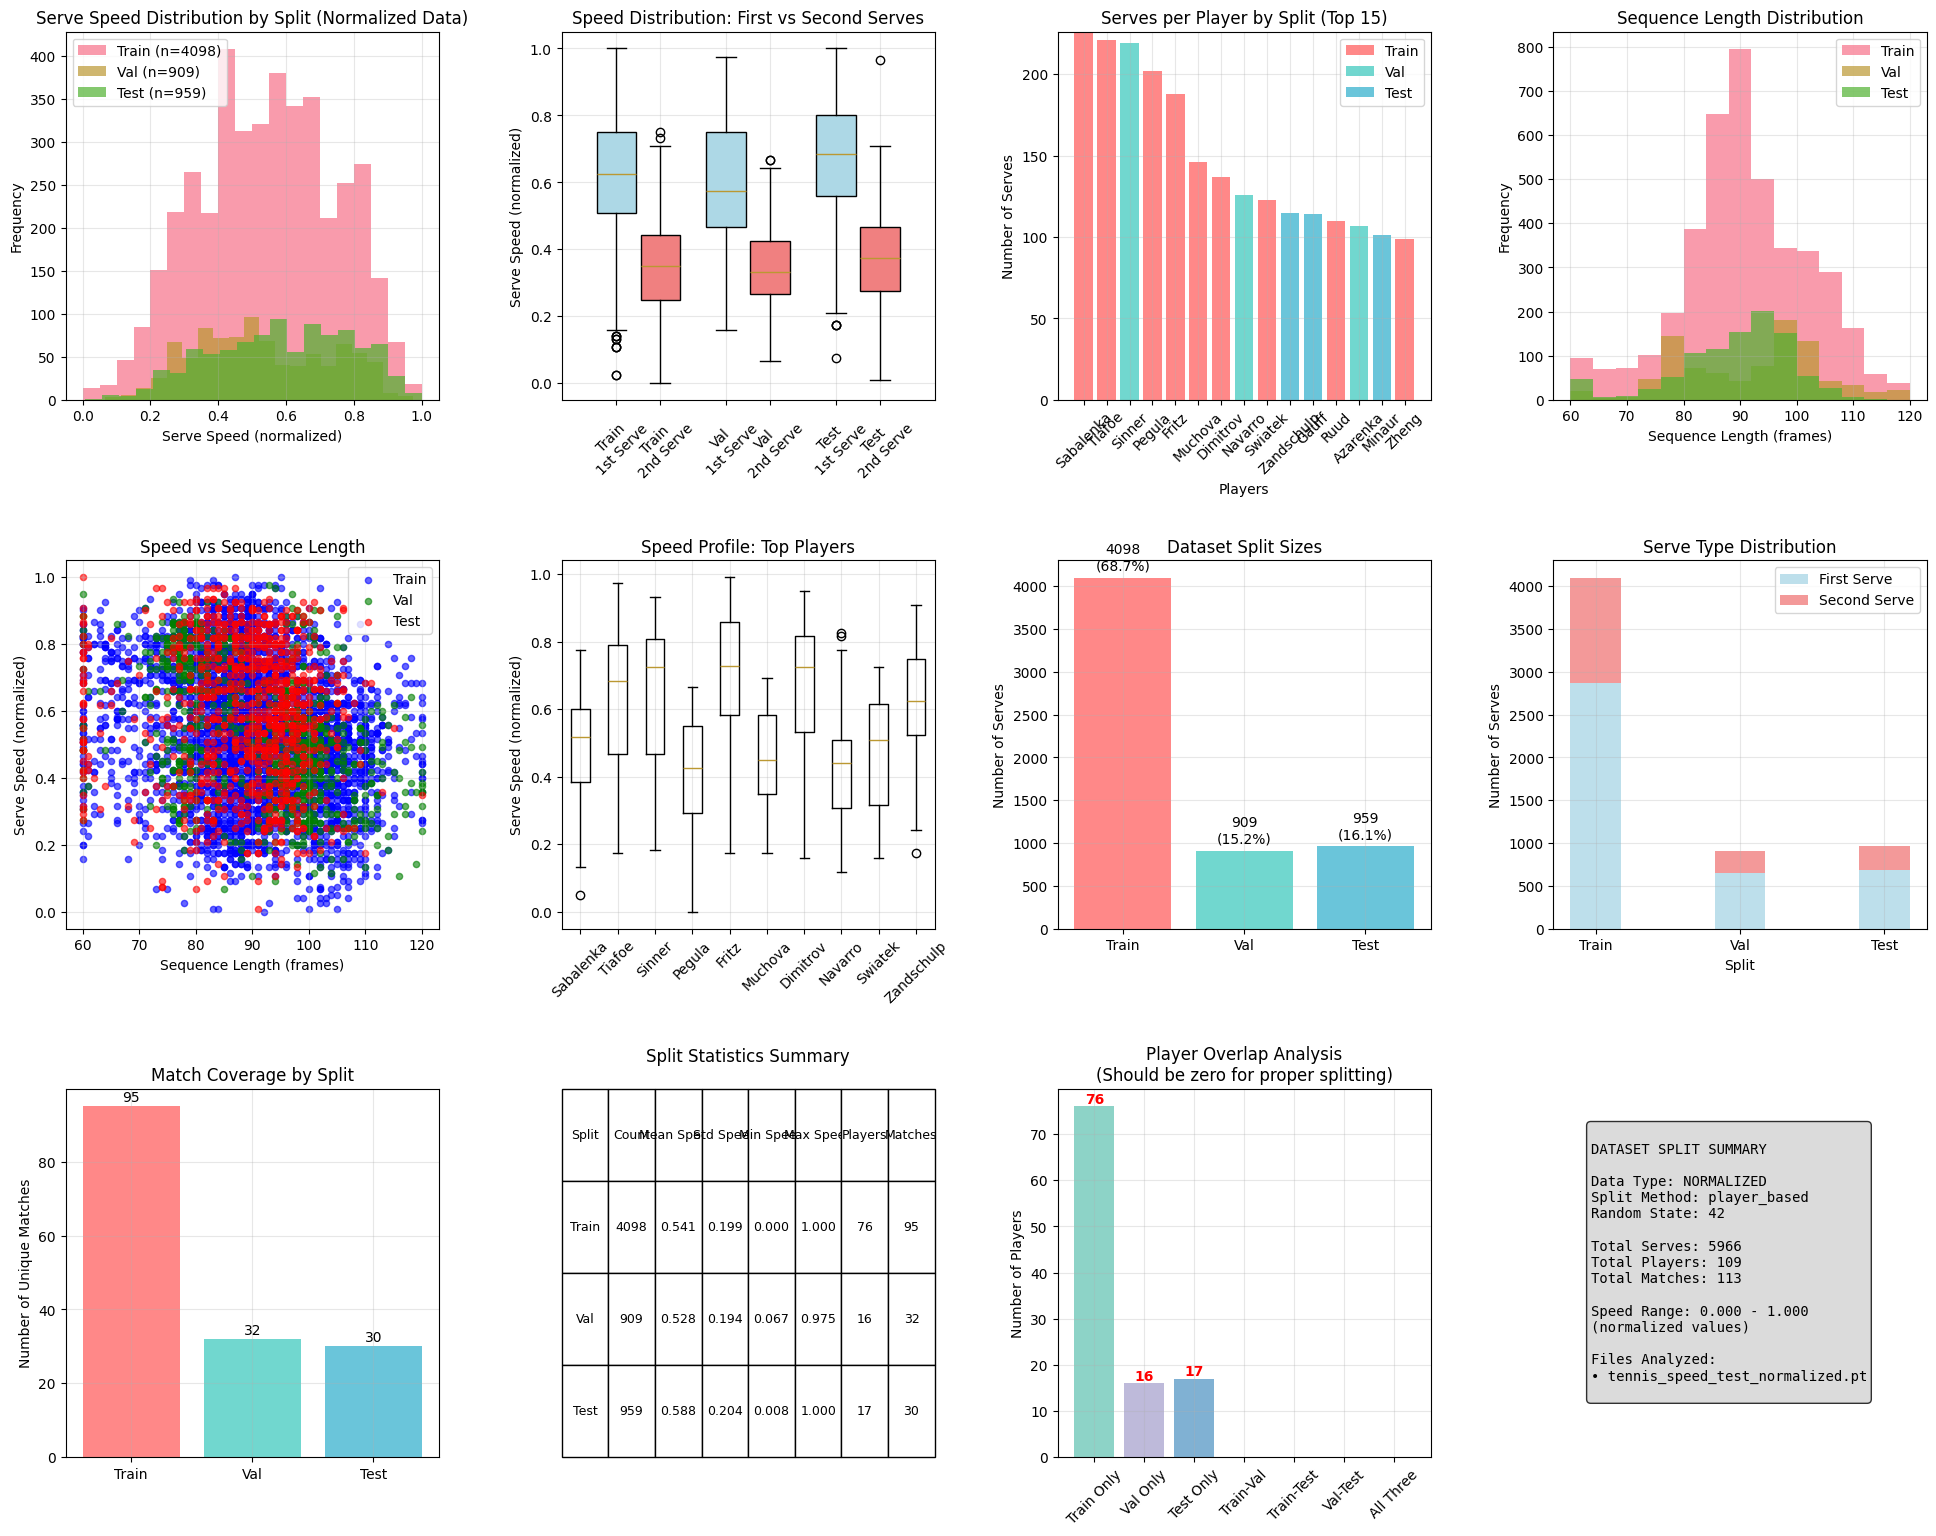


Visualization complete!


In [8]:
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List
from collections import defaultdict, Counter

def load_split_data_flexible(data_dir: Path):
    """Load split data with flexible metadata handling for normalized data."""
    
    # Try to load split metadata from multiple possible locations
    possible_metadata_paths = [
        data_dir / 'split_metadata.json',
        data_dir.parent / 'split_metadata.json'  # Look in parent directory
    ]
    
    split_metadata = None
    for metadata_path in possible_metadata_paths:
        if metadata_path.exists():
            with open(metadata_path, 'r') as f:
                split_metadata = json.load(f)
            print(f"Found metadata at: {metadata_path}")
            break
    
    if split_metadata is None:
        # Create default metadata if none found
        split_metadata = {
            'split_method': 'unknown',
            'random_state': 'unknown',
            'split_ratios': {'train': 0.7, 'val': 0.15, 'test': 0.15}
        }
        print("No metadata found, using defaults")
    
    # Load the actual data splits
    splits = {}
    split_patterns = [
        'tennis_speed_{}_normalized.pt',  # Try normalized first
        'tennis_speed_{}.pt'              # Fallback to original
    ]
    
    for split_name in ['train', 'val', 'test']:
        split_loaded = False
        for pattern in split_patterns:
            split_file = data_dir / pattern.format(split_name)
            if split_file.exists():
                splits[split_name] = torch.load(split_file, weights_only=False)
                print(f"Loaded {split_name}: {len(splits[split_name])} serves from {split_file.name}")
                split_loaded = True
                break
        
        if not split_loaded:
            print(f"Warning: No data file found for {split_name} split")
    
    return splits, split_metadata

def load_split_data(data_dir: Path):
    """Load the train/val/test split data and metadata."""
    
    # Load split metadata
    split_metadata_path = data_dir / 'split_metadata.json'
    if not split_metadata_path.exists():
        raise FileNotFoundError(f"Split metadata not found: {split_metadata_path}")
    
    with open(split_metadata_path, 'r') as f:
        split_metadata = json.load(f)
    
    # Load the actual data splits
    splits = {}
    for split_name in ['train', 'val', 'test']:
        split_file = data_dir / f'tennis_speed_{split_name}.pt'
        if split_file.exists():
            splits[split_name] = torch.load(split_file, weights_only=False)
            print(f"Loaded {split_name}: {len(splits[split_name])} serves")
        else:
            print(f"Warning: {split_file} not found")
    
    return splits, split_metadata

def extract_split_info(splits: Dict):
    """Extract detailed information from each split."""
    split_info = {}
    
    for split_name, data_list in splits.items():
        serves_data = []
        
        for data in data_list:
            serve_info = {
                'serve_id': getattr(data, 'serve_id', 'unknown'),
                'server': getattr(data, 'server', 'unknown'),
                'speed': data.y.item(),
                'serve_number': getattr(data, 'serve_number', 0),
                'sequence_length': getattr(data, 'sequence_length', 0),
                'player1': getattr(data, 'player1', 'unknown'),
                'player2': getattr(data, 'player2', 'unknown'),
                'match_id': getattr(data, 'match_id', 'unknown'),
                'set_no': getattr(data, 'set_no', 0),
                'is_ace': getattr(data, 'is_ace', False),
                'is_first_serve': getattr(data, 'serve_number', 1) == 1
            }
            serves_data.append(serve_info)
        
        split_info[split_name] = pd.DataFrame(serves_data)
    
    return split_info

def visualize_splits_with_normalization(split_info: Dict, split_metadata: Dict, data_type: str, save_dir: Path = None):
    """Create comprehensive visualizations of the dataset splits with normalization awareness."""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # Adjust labels and formatting based on data type
    speed_label = "Serve Speed (normalized)" if data_type == "normalized" else "Serve Speed (km/h)"
    speed_format = ".3f" if data_type == "normalized" else ".1f"
    
    # 1. Serve Speed Distribution by Split
    ax1 = plt.subplot(3, 4, 1)
    for split_name, df in split_info.items():
        plt.hist(df['speed'], alpha=0.7, label=f'{split_name.title()} (n={len(df)})', bins=20)
    plt.xlabel(speed_label)
    plt.ylabel('Frequency')
    plt.title(f'Serve Speed Distribution by Split ({data_type.title()} Data)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Speed by Serve Type and Split
    ax2 = plt.subplot(3, 4, 2)
    speed_data = []
    labels = []
    positions = []
    pos = 1
    
    for split_name, df in split_info.items():
        first_serves = df[df['is_first_serve']]['speed']
        second_serves = df[~df['is_first_serve']]['speed']
        
        speed_data.extend([first_serves, second_serves])
        labels.extend([f'{split_name.title()}\n1st Serve', f'{split_name.title()}\n2nd Serve'])
        positions.extend([pos, pos + 0.4])
        pos += 1
    
    bp = plt.boxplot(speed_data, positions=positions, labels=labels, patch_artist=True)
    colors = ['lightblue', 'lightcoral'] * 3
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel(speed_label)
    plt.title('Speed Distribution: First vs Second Serves')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 3. Number of Serves per Player by Split
    ax3 = plt.subplot(3, 4, 3)
    player_counts = {}
    
    for split_name, df in split_info.items():
        player_counts[split_name] = df['server'].value_counts()
    
    # Create stacked bar chart
    all_players = set()
    for counts in player_counts.values():
        all_players.update(counts.index)
    
    # Sort players by total serves
    player_totals = defaultdict(int)
    for counts in player_counts.values():
        for player, count in counts.items():
            player_totals[player] += count
    
    top_players = sorted(player_totals.items(), key=lambda x: x[1], reverse=True)[:15]
    top_player_names = [p[0] for p in top_players]
    
    bottom = np.zeros(len(top_player_names))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for i, (split_name, counts) in enumerate(player_counts.items()):
        heights = [counts.get(player, 0) for player in top_player_names]
        plt.bar(range(len(top_player_names)), heights, bottom=bottom, 
               label=split_name.title(), color=colors[i], alpha=0.8)
        bottom += heights
    
    plt.xlabel('Players')
    plt.ylabel('Number of Serves')
    plt.title('Serves per Player by Split (Top 15)')
    plt.xticks(range(len(top_player_names)), [p.split()[-1] for p in top_player_names], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Sequence Length Distribution
    ax4 = plt.subplot(3, 4, 4)
    for split_name, df in split_info.items():
        plt.hist(df['sequence_length'], alpha=0.7, label=f'{split_name.title()}', bins=15)
    plt.xlabel('Sequence Length (frames)')
    plt.ylabel('Frequency')
    plt.title('Sequence Length Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Speed vs Sequence Length
    ax5 = plt.subplot(3, 4, 5)
    colors_dict = {'train': 'blue', 'val': 'green', 'test': 'red'}
    
    for split_name, df in split_info.items():
        plt.scatter(df['sequence_length'], df['speed'], 
                   alpha=0.6, label=f'{split_name.title()}', 
                   color=colors_dict[split_name], s=20)
    
    plt.xlabel('Sequence Length (frames)')
    plt.ylabel(speed_label)
    plt.title('Speed vs Sequence Length')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Player Speed Profiles (Top Players)
    ax6 = plt.subplot(3, 4, 6)
    
    # Get top 10 players by serve count
    all_serves = pd.concat(split_info.values())
    top_servers = all_serves['server'].value_counts().head(10).index
    
    player_speeds = []
    player_labels = []
    
    for player in top_servers:
        player_serves = all_serves[all_serves['server'] == player]['speed']
        if len(player_serves) >= 5:  # Only include players with at least 5 serves
            player_speeds.append(player_serves)
            player_labels.append(player.split()[-1])  # Last name only
    
    if player_speeds:
        plt.boxplot(player_speeds, labels=player_labels)
        plt.ylabel(speed_label)
        plt.title('Speed Profile: Top Players')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 7. Split Size Comparison
    ax7 = plt.subplot(3, 4, 7)
    split_sizes = [len(df) for df in split_info.values()]
    split_names = [name.title() for name in split_info.keys()]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = plt.bar(split_names, split_sizes, color=colors, alpha=0.8)
    plt.ylabel('Number of Serves')
    plt.title('Dataset Split Sizes')
    
    # Add percentage labels on bars
    total = sum(split_sizes)
    for bar, size in zip(bars, split_sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01,
                f'{size}\n({size/total*100:.1f}%)', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    # 8. Serve Type Distribution by Split
    ax8 = plt.subplot(3, 4, 8)
    
    serve_type_data = []
    for split_name, df in split_info.items():
        first_count = df['is_first_serve'].sum()
        second_count = len(df) - first_count
        serve_type_data.append([first_count, second_count])
    
    serve_type_data = np.array(serve_type_data).T
    
    x = np.arange(len(split_names))
    width = 0.35
    
    plt.bar(x, serve_type_data[0], width, label='First Serve', color='lightblue', alpha=0.8)
    plt.bar(x, serve_type_data[1], width, bottom=serve_type_data[0], 
           label='Second Serve', color='lightcoral', alpha=0.8)
    
    plt.xlabel('Split')
    plt.ylabel('Number of Serves')
    plt.title('Serve Type Distribution')
    plt.xticks(x, split_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. Match Coverage by Split
    ax9 = plt.subplot(3, 4, 9)
    
    match_counts = {}
    for split_name, df in split_info.items():
        unique_matches = df['match_id'].nunique()
        match_counts[split_name] = unique_matches
    
    bars = plt.bar(split_names, list(match_counts.values()), 
                  color=colors, alpha=0.8)
    plt.ylabel('Number of Unique Matches')
    plt.title('Match Coverage by Split')
    
    for bar, count in zip(bars, match_counts.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{count}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    # 10. Speed Statistics Summary Table
    ax10 = plt.subplot(3, 4, 10)
    ax10.axis('tight')
    ax10.axis('off')
    
    # Create summary statistics table
    stats_data = []
    for split_name, df in split_info.items():
        if data_type == "normalized":
            stats = {
                'Split': split_name.title(),
                'Count': len(df),
                'Mean Speed': f"{df['speed'].mean():.3f}",
                'Std Speed': f"{df['speed'].std():.3f}",
                'Min Speed': f"{df['speed'].min():.3f}",
                'Max Speed': f"{df['speed'].max():.3f}",
                'Players': df['server'].nunique(),
                'Matches': df['match_id'].nunique()
            }
        else:
            stats = {
                'Split': split_name.title(),
                'Count': len(df),
                'Mean Speed': f"{df['speed'].mean():.1f}",
                'Std Speed': f"{df['speed'].std():.1f}",
                'Min Speed': f"{df['speed'].min():.0f}",
                'Max Speed': f"{df['speed'].max():.0f}",
                'Players': df['server'].nunique(),
                'Matches': df['match_id'].nunique()
            }
        stats_data.append(stats)
    
    stats_df = pd.DataFrame(stats_data)
    table = ax10.table(cellText=stats_df.values, colLabels=stats_df.columns,
                      cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Split Statistics Summary', pad=20)
    
    # 11. Player Overlap Analysis
    ax11 = plt.subplot(3, 4, 11)
    
    # Check for player overlap between splits (should be zero for proper splitting)
    train_players = set(split_info['train']['server'].unique())
    val_players = set(split_info['val']['server'].unique()) if 'val' in split_info else set()
    test_players = set(split_info['test']['server'].unique()) if 'test' in split_info else set()
    
    # Create Venn diagram-like visualization
    overlap_data = {
        'Train Only': len(train_players - val_players - test_players),
        'Val Only': len(val_players - train_players - test_players),
        'Test Only': len(test_players - train_players - val_players),
        'Train-Val': len(train_players & val_players - test_players),
        'Train-Test': len(train_players & test_players - val_players),
        'Val-Test': len(val_players & test_players - train_players),
        'All Three': len(train_players & val_players & test_players)
    }
    
    labels = list(overlap_data.keys())
    values = list(overlap_data.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    
    bars = plt.bar(labels, values, color=colors)
    plt.ylabel('Number of Players')
    plt.title('Player Overlap Analysis\n(Should be zero for proper splitting)')
    plt.xticks(rotation=45)
    
    for bar, value in zip(bars, values):
        if value > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value}', ha='center', va='bottom', fontweight='bold', color='red')
    
    plt.grid(True, alpha=0.3)
    
    # 12. Additional info text with normalization info
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    info_text = f"""
DATASET SPLIT SUMMARY

Data Type: {data_type.upper()}
Split Method: {split_metadata.get('split_method', 'unknown')}
Random State: {split_metadata.get('random_state', 'unknown')}

Total Serves: {sum(len(df) for df in split_info.values())}
Total Players: {len(set().union(*[df['server'].unique() for df in split_info.values()]))}
Total Matches: {len(set().union(*[df['match_id'].unique() for df in split_info.values()]))}

Speed Range: {min(df['speed'].min() for df in split_info.values()):{speed_format}} - {max(df['speed'].max() for df in split_info.values()):{speed_format}}
{'(normalized values)' if data_type == 'normalized' else 'km/h'}

Files Analyzed:
• tennis_speed_{split_name}_{'normalized' if data_type == 'normalized' else ''}.pt
    """
    
    ax12.text(0.1, 0.9, info_text, transform=ax12.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout(pad=3.0)
    
    if save_dir:
        save_path = save_dir / f'dataset_split_analysis_{data_type}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {save_path}")
    
    plt.show()
    
    return fig

def print_split_summary_with_normalization(split_info: Dict, split_metadata: Dict, data_type: str):
    """Print a detailed text summary of the splits with normalization info."""
    
    print("\n" + "="*80)
    print(f"TENNIS DATASET SPLIT ANALYSIS ({data_type.upper()} DATA)")
    print("="*80)
    
    print(f"Data Type: {data_type}")
    print(f"Split Method: {split_metadata.get('split_method', 'unknown')}")
    print(f"Split Ratios: {split_metadata.get('split_ratios', {})}")
    
    total_serves = sum(len(df) for df in split_info.values())
    all_players = set().union(*[df['server'].unique() for df in split_info.values()])
    all_matches = set().union(*[df['match_id'].unique() for df in split_info.values()])
    
    print(f"\nOverall Dataset:")
    print(f"  Total Serves: {total_serves}")
    print(f"  Unique Players: {len(all_players)}")
    print(f"  Unique Matches: {len(all_matches)}")
    
    if data_type == "normalized":
        print(f"  NOTE: Speed values are normalized to [0, 1] range")
        print(f"  To get original km/h values, denormalize using saved statistics")
    
    for split_name, df in split_info.items():
        print(f"\n{split_name.upper()} Split:")
        print(f"  Serves: {len(df)} ({len(df)/total_serves*100:.1f}%)")
        print(f"  Players: {df['server'].nunique()}")
        print(f"  Matches: {df['match_id'].nunique()}")
        
        if data_type == "normalized":
            print(f"  Speed (normalized): {df['speed'].mean():.3f} ± {df['speed'].std():.3f}")
            print(f"  Range (normalized): {df['speed'].min():.3f} - {df['speed'].max():.3f}")
        else:
            print(f"  Speed: {df['speed'].mean():.1f} ± {df['speed'].std():.1f} km/h")
            print(f"  Range: {df['speed'].min():.0f} - {df['speed'].max():.0f} km/h")
            
        print(f"  First serves: {df['is_first_serve'].sum()} ({df['is_first_serve'].mean()*100:.1f}%)")
        print(f"  Avg sequence length: {df['sequence_length'].mean():.1f} frames")
        
        # Top players in this split
        top_players = df['server'].value_counts().head(3)
        print(f"  Top players: {', '.join([f'{p} ({c})' for p, c in top_players.items()])}")

def main():
    """Main function to visualize the tennis dataset splits."""
    
    # Use absolute paths to match your data location
    DATA_DIR = Path("/project/vil_baek/psaap/tennis/processed_tennis_speed_data")
    NORMALIZED_DIR = DATA_DIR / "normalized"
    
    try:
        print("Attempting to load from normalized data directory...")
        splits, split_metadata = load_split_data_flexible(NORMALIZED_DIR)
        data_type = "normalized"
    except Exception as e:
        print(f"Normalized data not found: {e}")
        try:
            print("Falling back to original data directory...")
            splits, split_metadata = load_split_data_flexible(DATA_DIR)
            data_type = "original"
        except Exception as e2:
            print(f"Error loading original data: {e2}")
            return
    
    print(f"Successfully loaded {data_type} data")
    
    # Extract detailed information
    print("Extracting split information...")
    split_info = extract_split_info(splits)
    
    # Print text summary with data type info
    print_split_summary_with_normalization(split_info, split_metadata, data_type)
    
    # Create visualizations
    print("\nCreating visualizations...")
    save_dir = NORMALIZED_DIR if data_type == "normalized" else DATA_DIR
    fig = visualize_splits_with_normalization(split_info, split_metadata, data_type, save_dir=save_dir)
    
    print("\nVisualization complete!")

if __name__ == "__main__":
    main()

/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jtb3sud/.local/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


Using device: cuda
Loading datasets...
Loaded 4098 serves from /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_train_normalized.pt
Sample data structure:
  x.shape: torch.Size([17, 99, 6])
  y: 0.2 km/h
  edge_index.shape: torch.Size([2, 49])
Loaded 909 serves from /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_val_normalized.pt
Sample data structure:
  x.shape: torch.Size([17, 88, 6])
  y: 0.7 km/h
  edge_index.shape: torch.Size([2, 49])
Loaded 959 serves from /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_test_normalized.pt
Sample data structure:
  x.shape: torch.Size([17, 80, 6])
  y: 0.9 km/h
  edge_index.shape: torch.Size([2, 49])
Trainer initialized with WEIGHTED LOSS:
  Device: cuda
  Slow serve weight (<150.0 km/h): 2.5x
  Fast serve weight (≥180.0 km/h): 2.5x
  Model parameters: 562,241

Starting training...
Starting training for 50 epochs...


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   1/50 | Train Loss: 0.0736 | Train MAE: 0.1 | Val Loss: 0.0232 | Val MAE: 0.1 | LR: 0.000100 | Time: 81.2s
New best validation MAE: 0.1 km/h - Model saved!


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   2/50 | Train Loss: 0.0618 | Train MAE: 0.1 | Val Loss: 0.0200 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.8s
New best validation MAE: 0.1 km/h - Model saved!


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   3/50 | Train Loss: 0.0609 | Train MAE: 0.1 | Val Loss: 0.0189 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.3s
New best validation MAE: 0.1 km/h - Model saved!


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   4/50 | Train Loss: 0.0598 | Train MAE: 0.1 | Val Loss: 0.0183 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.1s
New best validation MAE: 0.1 km/h - Model saved!


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   5/50 | Train Loss: 0.0570 | Train MAE: 0.1 | Val Loss: 0.0200 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.4s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   6/50 | Train Loss: 0.0550 | Train MAE: 0.1 | Val Loss: 0.0196 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.6s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   7/50 | Train Loss: 0.0526 | Train MAE: 0.1 | Val Loss: 0.0231 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.7s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   8/50 | Train Loss: 0.0530 | Train MAE: 0.1 | Val Loss: 0.0182 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.5s
New best validation MAE: 0.1 km/h - Model saved!


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch   9/50 | Train Loss: 0.0516 | Train MAE: 0.1 | Val Loss: 0.0186 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.2s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  10/50 | Train Loss: 0.0509 | Train MAE: 0.1 | Val Loss: 0.0198 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.5s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  11/50 | Train Loss: 0.0491 | Train MAE: 0.1 | Val Loss: 0.0188 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.8s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  12/50 | Train Loss: 0.0479 | Train MAE: 0.1 | Val Loss: 0.0212 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.8s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  13/50 | Train Loss: 0.0487 | Train MAE: 0.1 | Val Loss: 0.0179 | Val MAE: 0.1 | LR: 0.000100 | Time: 76.1s
New best validation MAE: 0.1 km/h - Model saved!


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  14/50 | Train Loss: 0.0471 | Train MAE: 0.1 | Val Loss: 0.0179 | Val MAE: 0.1 | LR: 0.000100 | Time: 73.5s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  15/50 | Train Loss: 0.0465 | Train MAE: 0.1 | Val Loss: 0.0177 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.7s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  16/50 | Train Loss: 0.0467 | Train MAE: 0.1 | Val Loss: 0.0185 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.4s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  17/50 | Train Loss: 0.0456 | Train MAE: 0.1 | Val Loss: 0.0187 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.4s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  18/50 | Train Loss: 0.0454 | Train MAE: 0.1 | Val Loss: 0.0179 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.5s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  19/50 | Train Loss: 0.0445 | Train MAE: 0.1 | Val Loss: 0.0200 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.3s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  20/50 | Train Loss: 0.0445 | Train MAE: 0.1 | Val Loss: 0.0180 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.3s
New best validation MAE: 0.1 km/h - Model saved!


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  21/50 | Train Loss: 0.0444 | Train MAE: 0.1 | Val Loss: 0.0172 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.2s
New best validation MAE: 0.1 km/h - Model saved!


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  22/50 | Train Loss: 0.0438 | Train MAE: 0.1 | Val Loss: 0.0179 | Val MAE: 0.1 | LR: 0.000100 | Time: 73.3s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  23/50 | Train Loss: 0.0439 | Train MAE: 0.1 | Val Loss: 0.0206 | Val MAE: 0.1 | LR: 0.000100 | Time: 76.3s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  24/50 | Train Loss: 0.0430 | Train MAE: 0.1 | Val Loss: 0.0189 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.4s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  25/50 | Train Loss: 0.0429 | Train MAE: 0.1 | Val Loss: 0.0186 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.8s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  26/50 | Train Loss: 0.0421 | Train MAE: 0.1 | Val Loss: 0.0178 | Val MAE: 0.1 | LR: 0.000100 | Time: 73.9s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  27/50 | Train Loss: 0.0419 | Train MAE: 0.1 | Val Loss: 0.0180 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.0s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  28/50 | Train Loss: 0.0421 | Train MAE: 0.1 | Val Loss: 0.0188 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.0s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  29/50 | Train Loss: 0.0413 | Train MAE: 0.1 | Val Loss: 0.0183 | Val MAE: 0.1 | LR: 0.000100 | Time: 75.7s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  30/50 | Train Loss: 0.0414 | Train MAE: 0.1 | Val Loss: 0.0214 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.0s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  31/50 | Train Loss: 0.0413 | Train MAE: 0.1 | Val Loss: 0.0184 | Val MAE: 0.1 | LR: 0.000100 | Time: 74.4s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  32/50 | Train Loss: 0.0408 | Train MAE: 0.1 | Val Loss: 0.0177 | Val MAE: 0.1 | LR: 0.000050 | Time: 75.5s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  33/50 | Train Loss: 0.0389 | Train MAE: 0.1 | Val Loss: 0.0176 | Val MAE: 0.1 | LR: 0.000050 | Time: 75.4s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  34/50 | Train Loss: 0.0376 | Train MAE: 0.1 | Val Loss: 0.0182 | Val MAE: 0.1 | LR: 0.000050 | Time: 74.6s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  35/50 | Train Loss: 0.0373 | Train MAE: 0.1 | Val Loss: 0.0197 | Val MAE: 0.1 | LR: 0.000050 | Time: 76.2s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  36/50 | Train Loss: 0.0371 | Train MAE: 0.1 | Val Loss: 0.0206 | Val MAE: 0.1 | LR: 0.000050 | Time: 74.9s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  37/50 | Train Loss: 0.0371 | Train MAE: 0.1 | Val Loss: 0.0183 | Val MAE: 0.1 | LR: 0.000050 | Time: 75.0s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  38/50 | Train Loss: 0.0368 | Train MAE: 0.1 | Val Loss: 0.0193 | Val MAE: 0.1 | LR: 0.000050 | Time: 75.2s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  39/50 | Train Loss: 0.0365 | Train MAE: 0.1 | Val Loss: 0.0199 | Val MAE: 0.1 | LR: 0.000050 | Time: 73.8s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  40/50 | Train Loss: 0.0367 | Train MAE: 0.1 | Val Loss: 0.0188 | Val MAE: 0.1 | LR: 0.000050 | Time: 75.9s


Training:   0%|          | 0/4098 [00:00<?, ?it/s]

Validation:   0%|          | 0/909 [00:00<?, ?it/s]

Epoch  41/50 | Train Loss: 0.0364 | Train MAE: 0.1 | Val Loss: 0.0195 | Val MAE: 0.1 | LR: 0.000050 | Time: 75.8s
Early stopping triggered after 20 epochs without improvement
Training completed! Best validation MAE: 0.1 km/h


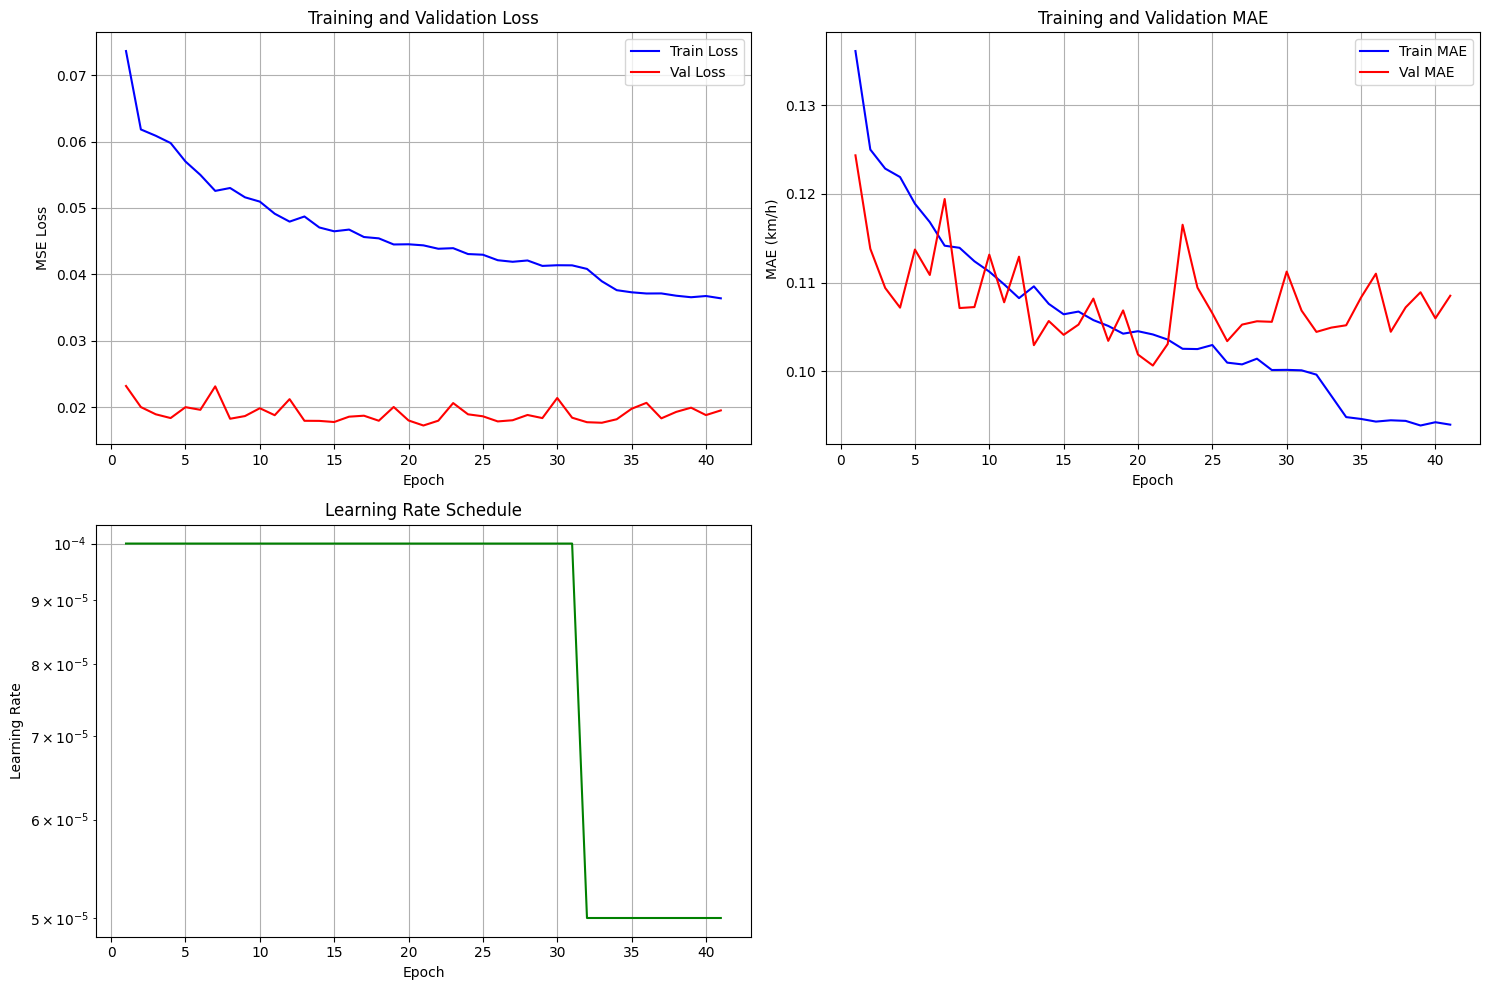

In [1]:
# Complete Tennis Serve Speed Training Script
# Run this entire cell in your Jupyter notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
from pathlib import Path
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# MODEL DEFINITION
# =============================================================================

class TemporalFeatureExtractor(nn.Module):
    """
    Extract features from temporal joint sequences using 1D convolutions and attention.
    Processes [joints, timesteps, features] -> [joints, feature_dim]
    """
    def __init__(self, input_feature_dim=6, hidden_dim=64, output_dim=128, num_layers=3):
        super().__init__()
        self.input_feature_dim = input_feature_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # 1D convolutions for temporal feature extraction
        conv_layers = []
        in_dim = input_feature_dim
        
        for i in range(num_layers):
            out_dim = hidden_dim if i < num_layers - 1 else output_dim
            conv_layers.extend([
                nn.Conv1d(in_dim, out_dim, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            in_dim = out_dim
        
        self.temporal_conv = nn.Sequential(*conv_layers)
        
        # Attention mechanism for temporal aggregation
        self.attention = nn.MultiheadAttention(
            embed_dim=output_dim,
            num_heads=8,
            dropout=0.1,
            batch_first=False
        )
        
        self.final_projection = nn.Linear(output_dim, output_dim)
        
    def forward(self, temporal_features):
        """
        Args:
            temporal_features: [batch_joints, timesteps, feature_dim]
        Returns:
            joint_features: [batch_joints, output_dim]
        """
        batch_joints, timesteps, feature_dim = temporal_features.shape
        
        # Apply 1D convolutions across time dimension
        x = temporal_features.transpose(1, 2)  # [batch_joints, feature_dim, timesteps]
        x = self.temporal_conv(x)  # [batch_joints, output_dim, timesteps]
        x = x.transpose(1, 2)  # [batch_joints, timesteps, output_dim]
        
        # Apply attention across time dimension
        x = x.transpose(0, 1)  # [timesteps, batch_joints, output_dim]
        attn_output, _ = self.attention(x, x, x)
        x = attn_output.transpose(0, 1)  # [batch_joints, timesteps, output_dim]
        
        # Global temporal pooling
        joint_features = torch.mean(x, dim=1)  # [batch_joints, output_dim]
        joint_features = self.final_projection(joint_features)
        
        return joint_features


class MotionDifferentiatorGNN(nn.Module):
    """Computes 'motion derivatives' - rates of change in biomechanical features."""
    def __init__(self, input_dim, hidden_dim=128, num_layers=3):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gnn_layers = nn.ModuleList()
        
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            out_dim = hidden_dim
            
            self.gnn_layers.append(
                GATConv(in_dim, out_dim, heads=4, dropout=0.1, concat=False)
            )
            
        self.output_projection = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x, edge_index):
        for i, gnn_layer in enumerate(self.gnn_layers):
            x = gnn_layer(x, edge_index)
            if i < len(self.gnn_layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, training=self.training, p=0.1)
        
        motion_derivatives = self.output_projection(x)
        return motion_derivatives


class MotionIntegratorGNN(nn.Module):
    """'Integrates' motion derivatives to produce accumulated biomechanical effects."""
    def __init__(self, input_dim, output_dim, num_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.gnn_layers = nn.ModuleList()
        
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else input_dim
            
            self.gnn_layers.append(
                GATConv(in_dim, input_dim, heads=4, dropout=0.1, concat=False)
            )
            
        self.output_projection = nn.Linear(input_dim, output_dim)
        
    def forward(self, motion_derivatives, edge_index):
        x = motion_derivatives
        
        for i, gnn_layer in enumerate(self.gnn_layers):
            residual = x
            x = gnn_layer(x, edge_index)
            x = F.relu(x + residual)  # Residual connection
            x = F.dropout(x, training=self.training, p=0.1)
        
        integrated_motion = self.output_projection(x)
        return integrated_motion


class GlobalContextProcessor(nn.Module):
    """Process global serve context (serve type, match pressure, etc.)"""
    def __init__(self, global_dim=4, embed_dim=64):
        super().__init__()
        self.embed_dim = embed_dim
        
        self.processor = nn.Sequential(
            nn.Linear(global_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
    def forward(self, global_features):
        return self.processor(global_features)


class TennisServeSpeedPredictor(nn.Module):
    """Tennis serve speed prediction model - REVERTED to original stable version."""
    
    def __init__(self, 
                 input_feature_dim=6,
                 temporal_hidden_dim=64,
                 temporal_output_dim=128,
                 motion_hidden_dim=128,
                 global_dim=4,
                 global_embed_dim=64):
        super().__init__()
        
        self.input_feature_dim = input_feature_dim
        self.temporal_output_dim = temporal_output_dim
        self.motion_hidden_dim = motion_hidden_dim
        self.global_embed_dim = global_embed_dim
        
        # --- Modules remain the same ---
        self.temporal_extractor = TemporalFeatureExtractor(
            input_feature_dim=input_feature_dim,
            hidden_dim=temporal_hidden_dim,
            output_dim=temporal_output_dim
        )
        self.global_processor = GlobalContextProcessor(
            global_dim=global_dim,
            embed_dim=global_embed_dim
        )
        motion_input_dim = temporal_output_dim + global_embed_dim
        self.motion_differentiator = MotionDifferentiatorGNN(
            input_dim=motion_input_dim,
            hidden_dim=motion_hidden_dim
        )
        self.motion_integrator = MotionIntegratorGNN(
            input_dim=motion_hidden_dim,
            output_dim=motion_hidden_dim
        )
        
        # --- CHANGE 1: Reverted the input size of the predictor head ---
        self.speed_predictor = nn.Sequential(
            nn.Linear(motion_hidden_dim + global_embed_dim, motion_hidden_dim), # <-- Reverted
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(motion_hidden_dim, motion_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(motion_hidden_dim // 2, 1)
        )
        
    def forward(self, data):
        # Extract temporal features for each joint
        joint_features = self.temporal_extractor(data.x)
        
        # Process global serve context
        global_context = self.extract_global_context(data)
        global_embed = self.global_processor(global_context)
        
        # Add global context to each joint
        global_context_expanded = global_embed.unsqueeze(0).repeat(data.num_nodes, 1)
        motion_input = torch.cat([joint_features, global_context_expanded], dim=-1)
        
        # Compute motion derivatives and integrate
        motion_derivatives = self.motion_differentiator(motion_input, data.edge_index)
        integrated_motion = self.motion_integrator(motion_derivatives, data.edge_index)
        
        # --- CHANGE 2: Reverted to global_mean_pool ---
        serve_motion_representation = global_mean_pool(integrated_motion, 
                                                       batch=torch.zeros(data.num_nodes, dtype=torch.long, device=integrated_motion.device)) # <-- Reverted
        
        # --- CHANGE 3: Re-enabled the final concatenation ---
        final_features = torch.cat([serve_motion_representation.squeeze(0), global_embed], dim=-1) # <-- Reverted
        
        # Predict serve speed
        predicted_speed = self.speed_predictor(final_features)
        
        return predicted_speed
    
    def extract_global_context(self, data):
        """Extract global serve context features from actual tennis data attributes."""
        # This method remains unchanged
        global_features = []
        if hasattr(data, 'serve_number'):
            is_first = 1.0 if data.serve_number == 1 else 0.0
            global_features.append(is_first)
        else:
            global_features.append(1.0)
            
        if hasattr(data, 'sequence_length'):
            normalized_length = float(data.sequence_length) / 100.0
            global_features.append(min(normalized_length, 2.0))
        else:
            global_features.append(0.8)
            
        if hasattr(data, 'set_no'):
            normalized_set = float(data.set_no) / 5.0
            global_features.append(normalized_set)
        else:
            global_features.append(0.2)
            
        if hasattr(data, 'game_no'):
            normalized_game = float(data.game_no) / 13.0
            global_features.append(normalized_game)
        else:
            global_features.append(0.5)
            
        return torch.tensor(global_features, device=data.x.device, dtype=torch.float32)

# =============================================================================
# DATASET AND TRAINING
# =============================================================================

class TennisServeDataset(Dataset):
    """Simple Dataset class for tennis serve data."""
    def __init__(self, data_file: Path):
        self.data = torch.load(data_file, weights_only=False)
        print(f"Loaded {len(self.data)} serves from {data_file}")
        
        if self.data:
            sample = self.data[0]
            print(f"Sample data structure:")
            print(f"  x.shape: {sample.x.shape}")
            print(f"  y: {sample.y.item():.1f} km/h")
            print(f"  edge_index.shape: {sample.edge_index.shape}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


def collate_fn(batch):
    """Custom collate function for tennis serve data."""
    return batch


class TennisTrainer:
    """Training class with a WEIGHTED loss function to combat regression-to-the-mean."""
    
    def __init__(self, model, train_dataset, val_dataset, 
                 learning_rate=1e-3, weight_decay=1e-5, device='cuda'):
        self.model = model.to(device)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.device = device
        
        # --- MODIFICATION 1: Define weights and thresholds for the loss function ---
        self.slow_threshold = 150.0
        self.fast_threshold = 180.0
        self.slow_weight = 2.5  # Increase penalty for errors on slow serves
        self.fast_weight = 2.5  # Increase penalty for errors on fast serves
        
        # Optimizers and loss
        self.optimizer = optim.AdamW(model.parameters(), 
                                     lr=learning_rate, 
                                     weight_decay=weight_decay)
                                     
        # --- MODIFICATION 2: Set reduction='none' to allow for manual weighting ---
        self.criterion = nn.MSELoss(reduction='none') 
        self.mae_criterion = nn.L1Loss()
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=10
        )
        
        # Data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=1, 
                                       shuffle=True, collate_fn=collate_fn)
        self.val_loader = DataLoader(val_dataset, batch_size=1, 
                                     shuffle=False, collate_fn=collate_fn)
        
        # Training history
        self.history = {
            'train_loss': [], 'train_mae': [], 'val_loss': [], 
            'val_mae': [], 'learning_rates': []
        }
        
        print(f"Trainer initialized with WEIGHTED LOSS:")
        print(f"  Device: {device}")
        print(f"  Slow serve weight (<{self.slow_threshold} km/h): {self.slow_weight}x")
        print(f"  Fast serve weight (≥{self.fast_threshold} km/h): {self.fast_weight}x")
        print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    def _get_speed_weights(self, targets):
        """Creates a weight tensor based on target speeds."""
        weights = torch.ones_like(targets)
        weights[targets < self.slow_threshold] = self.slow_weight
        weights[targets >= self.fast_threshold] = self.fast_weight
        return weights

    def train_epoch(self):
        """Train for one epoch using the weighted loss."""
        self.model.train()
        epoch_loss = 0.0
        epoch_mae = 0.0
        num_batches = 0
        
        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)
        
        for batch in progress_bar:
            data = batch[0].to(self.device)
            target = data.y.float()
            
            # Forward pass
            self.optimizer.zero_grad()
            pred = self.model(data)
            
            # --- MODIFICATION 3: Apply weighted loss calculation ---
            weights = self._get_speed_weights(target)
            unweighted_loss = self.criterion(pred, target) # Loss for each item in batch
            loss = (unweighted_loss * weights).mean() # Apply weights and then average
            
            # MAE for logging remains unweighted
            mae = self.mae_criterion(pred, target)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # Accumulate metrics
            epoch_loss += loss.item()
            epoch_mae += mae.item()
            num_batches += 1
            
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.3f}',
                'MAE': f'{mae.item():.1f}'
            })
        
        return epoch_loss / num_batches, epoch_mae / num_batches

    # The validate() and train() methods do not need any changes.
    # We only apply the weighted loss during training, not validation.
    def validate(self):
        """Validate the model."""
        self.model.eval()
        val_loss = 0.0
        val_mae = 0.0
        num_batches = 0
        
        predictions = []
        targets = []
        
        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation", leave=False):
                data = batch[0].to(self.device)
                target = data.y.float()
                
                pred = self.model(data)
                
                # Validation loss is the standard, unweighted MSE
                loss = F.mse_loss(pred, target)
                mae = self.mae_criterion(pred, target)
                
                val_loss += loss.item()
                val_mae += mae.item()
                num_batches += 1
                
                predictions.append(pred.cpu().numpy())
                targets.append(target.cpu().numpy())
        
        avg_val_loss = val_loss / num_batches
        avg_val_mae = val_mae / num_batches
        
        return avg_val_loss, avg_val_mae, predictions, targets

    def train(self, num_epochs=50, save_best=True, save_dir="./tennis_models"):
        # This method requires no changes
        save_dir = Path(save_dir)
        save_dir.mkdir(exist_ok=True)
        
        best_val_mae = float('inf')
        patience_counter = 0
        max_patience = 20
        
        print(f"Starting training for {num_epochs} epochs...")
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            train_loss, train_mae = self.train_epoch()
            val_loss, val_mae, predictions, targets = self.validate()
            
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            self.history['train_loss'].append(train_loss)
            self.history['train_mae'].append(train_mae)
            self.history['val_loss'].append(val_loss)
            self.history['val_mae'].append(val_mae)
            self.history['learning_rates'].append(current_lr)
            
            epoch_time = time.time() - start_time
            
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train MAE: {train_mae:.1f} | "
                  f"Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.1f} | "
                  f"LR: {current_lr:.6f} | Time: {epoch_time:.1f}s")
            
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                patience_counter = 0
                
                if save_best:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_mae': val_mae,
                        'history': self.history
                    }, save_dir / 'best_model.pth')
                
                print(f"New best validation MAE: {val_mae:.1f} km/h - Model saved!")
            else:
                patience_counter += 1
            
            if patience_counter >= max_patience:
                print(f"Early stopping triggered after {max_patience} epochs without improvement")
                break
        
        print(f"Training completed! Best validation MAE: {best_val_mae:.1f} km/h")
        return self.history
    
    # plot_training_history() also remains unchanged
    def plot_training_history(self):
        """Plot training curves."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(self.history['train_loss']) + 1)
        
        axes[0, 0].plot(epochs, self.history['train_loss'], 'b-', label='Train Loss')
        axes[0, 0].plot(epochs, self.history['val_loss'], 'r-', label='Val Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('MSE Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        axes[0, 1].plot(epochs, self.history['train_mae'], 'b-', label='Train MAE')
        axes[0, 1].plot(epochs, self.history['val_mae'], 'r-', label='Val MAE')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('MAE (km/h)')
        axes[0, 1].set_title('Training and Validation MAE')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        axes[1, 0].plot(epochs, self.history['learning_rates'], 'g-')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True)
        
        axes[1, 1].remove()
        
        plt.tight_layout()
        plt.show()
        return fig

# =============================================================================
# MAIN TRAINING FUNCTION
# =============================================================================

def run_tennis_training():
    """Main function to run tennis serve speed training."""
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data paths - update these to your actual paths
    DATA_DIR = Path("/project/vil_baek/psaap/tennis/processed_tennis_speed_data")
    train_file = DATA_DIR / "normalized/tennis_speed_train_normalized.pt"
    val_file = DATA_DIR / "normalized/tennis_speed_val_normalized.pt"
    test_file = DATA_DIR / "normalized/tennis_speed_test_normalized.pt"
    
    # Load datasets
    print("Loading datasets...")
    train_dataset = TennisServeDataset(train_file)
    val_dataset = TennisServeDataset(val_file)
    test_dataset = TennisServeDataset(test_file)
    
    # Create model
    model = TennisServeSpeedPredictor(
        input_feature_dim=6,
        temporal_hidden_dim=64,
        temporal_output_dim=128,
        motion_hidden_dim=128,
        global_dim=4,
        global_embed_dim=64
    )
    
    # Create trainer
    trainer = TennisTrainer(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        learning_rate=1e-4,
        weight_decay=1e-5,
        device=device
    )
    
    # Train the model
    print("\nStarting training...")
    history = trainer.train(num_epochs=50, save_best=True)
    
    # Plot training curves
    trainer.plot_training_history()
    
    return model, history, trainer

# To run the training, execute this:
model, history, trainer = run_tennis_training()

# Evaluation

In [2]:
"""
Tennis Serve Speed Prediction Model
Pure model definition without training dependencies
"""



def get_model_info(self):
    """Get information about the model architecture."""
    total_params = sum(p.numel() for p in self.parameters())
    trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    return {
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'input_feature_dim': self.input_feature_dim,
        'temporal_output_dim': self.temporal_output_dim,
        'motion_hidden_dim': self.motion_hidden_dim,
        'global_embed_dim': self.global_embed_dim,
        'architecture': 'TemporalGNN + MotionDifferentiator + MotionIntegrator',
        'task': 'serve_speed_prediction'
    }


def create_model(device='cpu', **kwargs):
    """
    Convenience function to create a model instance.
    
    Args:
        device: Device to move model to
        **kwargs: Model hyperparameters
    
    Returns:
        TennisServeSpeedPredictor instance
    """
    model = TennisServeSpeedPredictor(**kwargs)
    model = model.to(device)
    return model


def load_trained_model(model_path, device='cpu', **model_kwargs):
    """
    Load a trained model from checkpoint.
    
    Args:
        model_path: Path to the .pth checkpoint file
        device: Device to load model on
        **model_kwargs: Model hyperparameters (if different from default)
    
    Returns:
        Loaded model in eval mode
    """
    # Create model instance
    model = create_model(device=device, **model_kwargs)
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Model loaded from: {model_path}")
    if 'epoch' in checkpoint:
        print(f"Trained for {checkpoint['epoch']} epochs")
    if 'val_mae' in checkpoint:
        print(f"Best validation MAE: {checkpoint['val_mae']:.3f}")
    
    return model, checkpoint


def test_model_creation():
    """Test function to verify model can be created and runs."""
    print("Testing model creation...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create model
    model = create_model(device=device)
    print(f"Model created successfully")
    
    # Print model info
    #info = model.get_model_info()
    #for key, value in info.items():
    #    print(f"  {key}: {value}")
    
    # Test with dummy data
    batch_size = 1
    num_joints = 17
    timesteps = 80
    feature_dim = 6
    
    # Create dummy input
    x = torch.randn(num_joints, timesteps, feature_dim).to(device)
    edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long).t().contiguous().to(device)
    
    # Create dummy data object
    class DummyData:
        def __init__(self):
            self.x = x
            self.edge_index = edge_index
            self.num_nodes = num_joints
            self.serve_number = 1
            self.sequence_length = timesteps
            self.set_no = 2
            self.game_no = 5
    
    data = DummyData()
    
    # Test forward pass
    model.eval()
    with torch.no_grad():
        output = model(data)
    
    print(f"  Test forward pass successful")
    print(f"  Output shape: {output.shape}")
    print(f"  Output value: {output.item():.3f}")
    
    return model


if __name__ == "__main__":
    # Test model creation
    model = test_model_creation()

Testing model creation...
Using device: cuda
Model created successfully
  Test forward pass successful
  Output shape: torch.Size([1])
  Output value: 0.064


Loaded normalization statistics from: /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/normalization_stats.json
Model loaded from: tennis_models/best_model.pth
Model was saved at epoch 21
Best validation MAE: 0.101
Loading test datasets...

Evaluating on Test Set (959 samples)...

Test Set Results:
  Samples: 959
  MAE: 16.7 km/h
  RMSE: 20.6 km/h
  R²: 0.287
  Mean Error: -7.2 ± 19.3 km/h
  First serves: MAE = 18.1 km/h (n=687)
  Second serves: MAE = 13.2 km/h (n=272)

Evaluating on Validation Set (909 samples)...

Validation Set Results:
  Samples: 909
  MAE: 12.1 km/h
  RMSE: 15.7 km/h
  R²: 0.543
  Mean Error: -0.1 ± 15.7 km/h
  First serves: MAE = 12.7 km/h (n=649)
  Second serves: MAE = 10.6 km/h (n=260)

Creating visualizations...


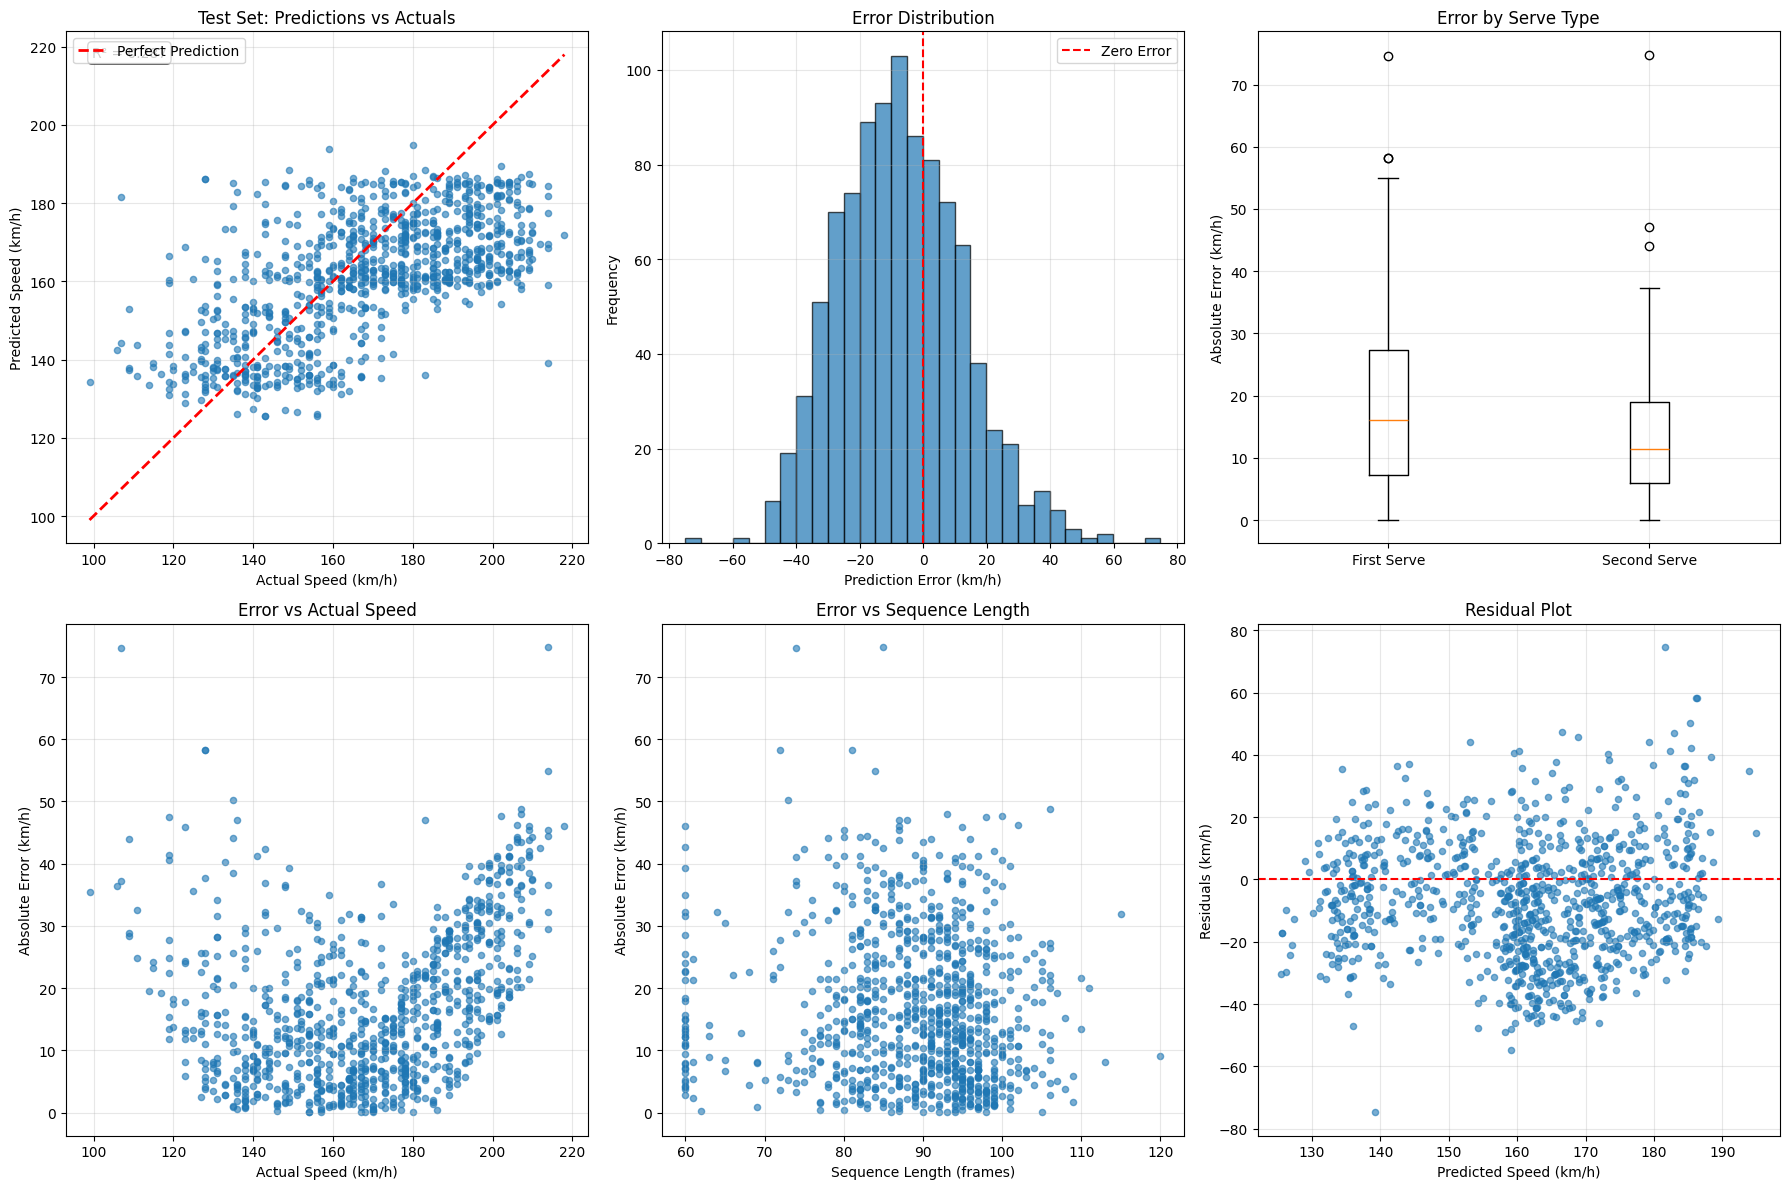


Worst 5 Predictions:
                    serve_id           server serve_type  sequence_length  actual_speed_kmh  predicted_speed_kmh  absolute_error_kmh
2024-usopen-1503_pt0119_srv2 Alexander Zverev     Second               85             214.0           139.180496           74.819504
2024-usopen-1401_pt0085_srv1       Tommy Paul      First               74             107.0           181.631851           74.631851
2024-usopen-1108_pt0182_srv1       Tommy Paul      First               81             128.0           186.246399           58.246399
2024-usopen-1302_pt0213_srv1       Tommy Paul      First               72             128.0           186.200378           58.200378
2024-usopen-1406_pt0020_srv1 Alexander Zverev      First               84             214.0           159.090637           54.909363

Best 5 Predictions:
                    serve_id                  server serve_type  sequence_length  actual_speed_kmh  predicted_speed_kmh  absolute_error_kmh
2024-usopen-2406_pt

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from typing import Dict, List, Tuple, Optional
import pandas as pd
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class TennisModelTester:
    """
    Comprehensive testing suite for tennis serve speed prediction model.
    Handles loading trained models, normalization, and evaluation.
    """
    
    def __init__(self, model_path: str, normalizer_stats_path: str, device: str = 'cpu'):
        self.model_path = Path(model_path)
        self.normalizer_stats_path = Path(normalizer_stats_path)
        self.device = device
        
        # Load normalization statistics
        self.normalizer = self.load_normalizer_stats()
        
        # Model will be loaded when needed
        self.model = None
        
    def load_normalizer_stats(self):
        """Load normalization statistics for denormalization."""
        if not self.normalizer_stats_path.exists():
            raise FileNotFoundError(f"Normalizer stats not found: {self.normalizer_stats_path}")
        
        with open(self.normalizer_stats_path, 'r') as f:
            stats = json.load(f)
        
        print(f"Loaded normalization statistics from: {self.normalizer_stats_path}")
        return stats
    
    def denormalize_speed(self, normalized_speed: torch.Tensor) -> torch.Tensor:
        """Convert normalized speed back to km/h."""
        target_stats = self.normalizer['target_stats']
        return normalized_speed * target_stats['range'] + target_stats['min']
    
    def normalize_global_context(self, serve_number: int, sequence_length: int, 
                                set_no: int = None, game_no: int = None) -> torch.Tensor:
        """Normalize global context features like the training normalizer."""
        global_features = []
        
        # Serve type normalization
        global_stats = self.normalizer['global_stats']
        serve_normalized = (serve_number - global_stats['serve_type']['min']) / global_stats['serve_type']['range']
        global_features.append(serve_normalized)
        
        # Sequence length normalization
        seq_stats = global_stats['sequence_length']
        seq_normalized = (sequence_length - seq_stats['min']) / seq_stats['range']
        global_features.append(max(0.0, min(1.0, seq_normalized)))
        
        # Set number normalization
        if set_no is not None:
            set_stats = global_stats['set_number']
            set_normalized = (set_no - set_stats['min']) / set_stats['range']
            global_features.append(max(0.0, min(1.0, set_normalized)))
        else:
            global_features.append(0.2)
        
        # Game number normalization
        if game_no is not None:
            game_stats = global_stats['game_number']
            game_normalized = (game_no - game_stats['min']) / game_stats['range']
            global_features.append(max(0.0, min(1.0, game_normalized)))
        else:
            global_features.append(0.5)
        
        return torch.tensor(global_features, dtype=torch.float32, device=self.device)
    
    def load_model(self, model_class):
        """Load trained model from checkpoint."""
        if not self.model_path.exists():
            raise FileNotFoundError(f"Model checkpoint not found: {self.model_path}")
        
        # Load checkpoint
        checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
        
        # Create model instance
        self.model = model_class(
            input_feature_dim=6,
            temporal_hidden_dim=64,
            temporal_output_dim=128,
            motion_hidden_dim=128,
            global_dim=4,
            global_embed_dim=64
        ).to(self.device)
        
        # Load model weights
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        print(f"Model loaded from: {self.model_path}")
        print(f"Model was saved at epoch {checkpoint.get('epoch', 'unknown')}")
        print(f"Best validation MAE: {checkpoint.get('val_mae', 'unknown'):.3f}")
        
        return self.model
    
    def predict_single_serve(self, data) -> Dict:
        """Make prediction on a single serve and return detailed results."""
        if self.model is None:
            raise RuntimeError("Model not loaded. Call load_model() first.")
        
        self.model.eval()
        with torch.no_grad():
            data = data.to(self.device)
            
            # Get normalized prediction
            normalized_pred = self.model(data)
            
            # Denormalize prediction and target
            pred_kmh = self.denormalize_speed(normalized_pred).cpu().numpy()
            true_normalized = data.y.cpu().numpy()
            true_kmh = self.denormalize_speed(data.y).cpu().numpy()
            
            # Calculate errors
            error_kmh = pred_kmh - true_kmh
            error_normalized = normalized_pred.cpu().numpy() - true_normalized
            
            results = {
                'predicted_speed_kmh': float(pred_kmh),
                'actual_speed_kmh': float(true_kmh),
                'error_kmh': float(error_kmh),
                'absolute_error_kmh': float(abs(error_kmh)),
                'predicted_normalized': float(normalized_pred.cpu().numpy()),
                'actual_normalized': float(true_normalized),
                'error_normalized': float(error_normalized),
                'serve_id': getattr(data, 'serve_id', 'unknown'),
                'serve_type': 'First' if getattr(data, 'serve_number', 1) == 1 else 'Second',
                'sequence_length': getattr(data, 'sequence_length', 0),
                'server': getattr(data, 'server', 'unknown')
            }
        
        return results
    
    def evaluate_dataset(self, dataset, dataset_name: str = "Dataset") -> Dict:
        """Comprehensive evaluation on a dataset."""
        if self.model is None:
            raise RuntimeError("Model not loaded. Call load_model() first.")
        
        print(f"\nEvaluating on {dataset_name} ({len(dataset)} samples)...")
        
        all_results = []
        predictions_kmh = []
        actuals_kmh = []
        predictions_norm = []
        actuals_norm = []
        
        # Predict on all samples
        for i, data in enumerate(dataset):
            try:
                result = self.predict_single_serve(data)
                all_results.append(result)
                predictions_kmh.append(result['predicted_speed_kmh'])
                actuals_kmh.append(result['actual_speed_kmh'])
                predictions_norm.append(result['predicted_normalized'])
                actuals_norm.append(result['actual_normalized'])
                
            except Exception as e:
                print(f"Error predicting sample {i}: {e}")
                continue
        
        # Convert to numpy arrays
        predictions_kmh = np.array(predictions_kmh)
        actuals_kmh = np.array(actuals_kmh)
        predictions_norm = np.array(predictions_norm)
        actuals_norm = np.array(actuals_norm)
        
        # Calculate metrics
        metrics = {
            'dataset_name': dataset_name,
            'n_samples': len(all_results),
            # Metrics in km/h (denormalized)
            'mae_kmh': float(mean_absolute_error(actuals_kmh, predictions_kmh)),
            'mse_kmh': float(mean_squared_error(actuals_kmh, predictions_kmh)),
            'rmse_kmh': float(np.sqrt(mean_squared_error(actuals_kmh, predictions_kmh))),
            'r2_score': float(r2_score(actuals_kmh, predictions_kmh)),
            # Metrics in normalized space
            'mae_normalized': float(mean_absolute_error(actuals_norm, predictions_norm)),
            'mse_normalized': float(mean_squared_error(actuals_norm, predictions_norm)),
            # Speed statistics
            'actual_speed_mean': float(np.mean(actuals_kmh)),
            'actual_speed_std': float(np.std(actuals_kmh)),
            'predicted_speed_mean': float(np.mean(predictions_kmh)),
            'predicted_speed_std': float(np.std(predictions_kmh)),
            # Error statistics
            'mean_error_kmh': float(np.mean(predictions_kmh - actuals_kmh)),
            'std_error_kmh': float(np.std(predictions_kmh - actuals_kmh)),
            'max_error_kmh': float(np.max(np.abs(predictions_kmh - actuals_kmh))),
        }
        
        # Analyze by serve type
        serve_type_results = defaultdict(list)
        for result in all_results:
            serve_type_results[result['serve_type']].append(result)
        
        serve_type_metrics = {}
        for serve_type, results in serve_type_results.items():
            if len(results) > 0:
                type_preds = [r['predicted_speed_kmh'] for r in results]
                type_actuals = [r['actual_speed_kmh'] for r in results]
                serve_type_metrics[serve_type] = {
                    'count': len(results),
                    'mae_kmh': float(mean_absolute_error(type_actuals, type_preds)),
                    'r2_score': float(r2_score(type_actuals, type_preds)),
                    'actual_mean': float(np.mean(type_actuals)),
                    'predicted_mean': float(np.mean(type_preds))
                }
        
        metrics['serve_type_breakdown'] = serve_type_metrics
        
        # Print summary
        print(f"\n{dataset_name} Results:")
        print(f"  Samples: {metrics['n_samples']}")
        print(f"  MAE: {metrics['mae_kmh']:.1f} km/h")
        print(f"  RMSE: {metrics['rmse_kmh']:.1f} km/h") 
        print(f"  R²: {metrics['r2_score']:.3f}")
        print(f"  Mean Error: {metrics['mean_error_kmh']:.1f} ± {metrics['std_error_kmh']:.1f} km/h")
        
        for serve_type, type_metrics in serve_type_metrics.items():
            print(f"  {serve_type} serves: MAE = {type_metrics['mae_kmh']:.1f} km/h (n={type_metrics['count']})")
        
        return metrics, all_results
    
    def plot_predictions(self, results: List[Dict], dataset_name: str = "Dataset"):
        """Create comprehensive plots of model predictions."""
        
        # Extract data for plotting
        predictions = [r['predicted_speed_kmh'] for r in results]
        actuals = [r['actual_speed_kmh'] for r in results]
        errors = [r['error_kmh'] for r in results]
        abs_errors = [r['absolute_error_kmh'] for r in results]
        serve_types = [r['serve_type'] for r in results]
        sequence_lengths = [r['sequence_length'] for r in results]
        
        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Predictions vs Actuals
        ax = axes[0, 0]
        ax.scatter(actuals, predictions, alpha=0.6, s=20)
        min_val, max_val = min(min(actuals), min(predictions)), max(max(actuals), max(predictions))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        ax.set_xlabel('Actual Speed (km/h)')
        ax.set_ylabel('Predicted Speed (km/h)')
        ax.set_title(f'{dataset_name}: Predictions vs Actuals')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add R² to plot
        r2 = r2_score(actuals, predictions)
        ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 2. Error distribution
        ax = axes[0, 1]
        ax.hist(errors, bins=30, alpha=0.7, edgecolor='black')
        ax.axvline(0, color='red', linestyle='--', label='Zero Error')
        ax.set_xlabel('Prediction Error (km/h)')
        ax.set_ylabel('Frequency')
        ax.set_title('Error Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Absolute error by serve type
        ax = axes[0, 2]
        first_errors = [abs_errors[i] for i, st in enumerate(serve_types) if st == 'First']
        second_errors = [abs_errors[i] for i, st in enumerate(serve_types) if st == 'Second']
        
        ax.boxplot([first_errors, second_errors], labels=['First Serve', 'Second Serve'])
        ax.set_ylabel('Absolute Error (km/h)')
        ax.set_title('Error by Serve Type')
        ax.grid(True, alpha=0.3)
        
        # 4. Error vs actual speed
        ax = axes[1, 0]
        ax.scatter(actuals, abs_errors, alpha=0.6, s=20)
        ax.set_xlabel('Actual Speed (km/h)')
        ax.set_ylabel('Absolute Error (km/h)')
        ax.set_title('Error vs Actual Speed')
        ax.grid(True, alpha=0.3)
        
        # 5. Error vs sequence length
        ax = axes[1, 1]
        ax.scatter(sequence_lengths, abs_errors, alpha=0.6, s=20)
        ax.set_xlabel('Sequence Length (frames)')
        ax.set_ylabel('Absolute Error (km/h)')
        ax.set_title('Error vs Sequence Length')
        ax.grid(True, alpha=0.3)
        
        # 6. Residuals plot
        ax = axes[1, 2]
        residuals = np.array(predictions) - np.array(actuals)
        ax.scatter(predictions, residuals, alpha=0.6, s=20)
        ax.axhline(0, color='red', linestyle='--')
        ax.set_xlabel('Predicted Speed (km/h)')
        ax.set_ylabel('Residuals (km/h)')
        ax.set_title('Residual Plot')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def find_worst_predictions(self, results: List[Dict], n: int = 10) -> pd.DataFrame:
        """Find the worst predictions for analysis."""
        df = pd.DataFrame(results)
        worst = df.nlargest(n, 'absolute_error_kmh')[
            ['serve_id', 'server', 'serve_type', 'sequence_length', 
             'actual_speed_kmh', 'predicted_speed_kmh', 'absolute_error_kmh']
        ]
        
        print(f"\nWorst {n} Predictions:")
        print(worst.to_string(index=False))
        
        return worst
    
    def find_best_predictions(self, results: List[Dict], n: int = 10) -> pd.DataFrame:
        """Find the best predictions for analysis."""
        df = pd.DataFrame(results)
        best = df.nsmallest(n, 'absolute_error_kmh')[
            ['serve_id', 'server', 'serve_type', 'sequence_length',
             'actual_speed_kmh', 'predicted_speed_kmh', 'absolute_error_kmh']
        ]
        
        print(f"\nBest {n} Predictions:")
        print(best.to_string(index=False))
        
        return best

    def analyze_by_player(self, results: List[Dict], dataset_name: str = "Dataset") -> Dict:
        """Analyze model performance by individual players."""
        print(f"\nPlayer-Level Analysis for {dataset_name}:")
        print("="*50)
        
        # Group results by player
        player_results = defaultdict(list)
        for result in results:
            player_results[result['server']].append(result)
        
        player_metrics = {}
        
        # Calculate metrics for each player
        for player, player_data in player_results.items():
            if len(player_data) >= 5:  # Only analyze players with at least 5 serves
                predictions = [r['predicted_speed_kmh'] for r in player_data]
                actuals = [r['actual_speed_kmh'] for r in player_data]
                errors = [r['absolute_error_kmh'] for r in player_data]
                
                # Serve type breakdown
                first_serves = [r for r in player_data if r['serve_type'] == 'First']
                second_serves = [r for r in player_data if r['serve_type'] == 'Second']
                
                player_metrics[player] = {
                    'total_serves': len(player_data),
                    'mae_kmh': float(mean_absolute_error(actuals, predictions)),
                    'r2_score': float(r2_score(actuals, predictions)),
                    'actual_mean': float(np.mean(actuals)),
                    'predicted_mean': float(np.mean(predictions)),
                    'max_error': float(max(errors)),
                    'first_serves_count': len(first_serves),
                    'second_serves_count': len(second_serves),
                    'first_serve_avg_speed': float(np.mean([r['actual_speed_kmh'] for r in first_serves])) if first_serves else 0,
                    'second_serve_avg_speed': float(np.mean([r['actual_speed_kmh'] for r in second_serves])) if second_serves else 0,
                    'first_serve_mae': float(mean_absolute_error([r['actual_speed_kmh'] for r in first_serves], 
                                                               [r['predicted_speed_kmh'] for r in first_serves])) if len(first_serves) > 1 else 0,
                    'second_serve_mae': float(mean_absolute_error([r['actual_speed_kmh'] for r in second_serves],
                                                                [r['predicted_speed_kmh'] for r in second_serves])) if len(second_serves) > 1 else 0
                }
        
        # Sort players by total serves
        sorted_players = sorted(player_metrics.items(), key=lambda x: x[1]['total_serves'], reverse=True)
        
        print(f"Top Players by Serve Count (min 5 serves):")
        print(f"{'Player':<20} {'Serves':<8} {'MAE':<8} {'R²':<8} {'Avg Speed':<12} {'1st Srv':<8} {'2nd Srv':<8}")
        print("-" * 85)
        
        for player, metrics in sorted_players[:15]:  # Top 15 players
            print(f"{player[:19]:<20} {metrics['total_serves']:<8} {metrics['mae_kmh']:<8.1f} "
                  f"{metrics['r2_score']:<8.3f} {metrics['actual_mean']:<12.1f} "
                  f"{metrics['first_serve_avg_speed']:<8.1f} {metrics['second_serve_avg_speed']:<8.1f}")
        
        return player_metrics
    
    def analyze_by_match(self, results: List[Dict], dataset_name: str = "Dataset") -> Dict:
        """Analyze model performance by individual matches."""
        print(f"\nMatch-Level Analysis for {dataset_name}:")
        print("="*50)
        
        # Group results by match
        match_results = defaultdict(list)
        for result in results:
            match_id = getattr(result, 'match_id', 'unknown')
            if hasattr(result, 'match_id'):
                # Extract from serve_id if match_id not directly available
                serve_id = result.get('serve_id', '')
                if serve_id and '_pt' in serve_id:
                    match_id = serve_id.split('_pt')[0]
            match_results[match_id].append(result)
        
        match_metrics = {}
        
        # Calculate metrics for each match
        for match_id, match_data in match_results.items():
            if len(match_data) >= 10:  # Only analyze matches with at least 10 serves
                predictions = [r['predicted_speed_kmh'] for r in match_data]
                actuals = [r['actual_speed_kmh'] for r in match_data]
                
                # Get unique players in this match
                players = list(set([r['server'] for r in match_data]))
                
                match_metrics[match_id] = {
                    'total_serves': len(match_data),
                    'players': players,
                    'mae_kmh': float(mean_absolute_error(actuals, predictions)),
                    'r2_score': float(r2_score(actuals, predictions)),
                    'actual_mean': float(np.mean(actuals)),
                    'predicted_mean': float(np.mean(predictions)),
                    'speed_range': (float(min(actuals)), float(max(actuals)))
                }
        
        # Sort matches by serve count
        sorted_matches = sorted(match_metrics.items(), key=lambda x: x[1]['total_serves'], reverse=True)
        
        print(f"Top Matches by Serve Count (min 10 serves):")
        print(f"{'Match ID':<25} {'Serves':<8} {'MAE':<8} {'R²':<8} {'Players':<30}")
        print("-" * 80)
        
        for match_id, metrics in sorted_matches[:10]:  # Top 10 matches
            players_str = ', '.join([p.split()[-1] for p in metrics['players']])[:29]
            print(f"{match_id[:24]:<25} {metrics['total_serves']:<8} {metrics['mae_kmh']:<8.1f} "
                  f"{metrics['r2_score']:<8.3f} {players_str:<30}")
        
        return match_metrics
    
    def analyze_serve_type_detailed(self, results: List[Dict], dataset_name: str = "Dataset") -> Dict:
        """Detailed analysis by serve type (1st vs 2nd serves)."""
        print(f"\nDetailed Serve Type Analysis for {dataset_name}:")
        print("="*50)
        
        # Separate by serve type
        first_serves = [r for r in results if r['serve_type'] == 'First']
        second_serves = [r for r in results if r['serve_type'] == 'Second']
        
        serve_type_analysis = {}
        
        for serve_type, serve_data in [('First', first_serves), ('Second', second_serves)]:
            if len(serve_data) > 0:
                predictions = [r['predicted_speed_kmh'] for r in serve_data]
                actuals = [r['actual_speed_kmh'] for r in serve_data]
                errors = [r['absolute_error_kmh'] for r in serve_data]
                
                # Speed bins analysis
                speed_bins = {
                    'slow': [r for r in serve_data if r['actual_speed_kmh'] < 150],
                    'medium': [r for r in serve_data if 150 <= r['actual_speed_kmh'] < 180],
                    'fast': [r for r in serve_data if r['actual_speed_kmh'] >= 180]
                }
                
                serve_type_analysis[serve_type] = {
                    'count': len(serve_data),
                    'mae_kmh': float(mean_absolute_error(actuals, predictions)),
                    'rmse_kmh': float(np.sqrt(mean_squared_error(actuals, predictions))),
                    'r2_score': float(r2_score(actuals, predictions)),
                    'actual_mean': float(np.mean(actuals)),
                    'actual_std': float(np.std(actuals)),
                    'predicted_mean': float(np.mean(predictions)),
                    'predicted_std': float(np.std(predictions)),
                    'mean_error': float(np.mean(np.array(predictions) - np.array(actuals))),
                    'max_error': float(max(errors)),
                    'speed_bins': {
                        bin_name: {
                            'count': len(bin_data),
                            'mae': float(mean_absolute_error([r['actual_speed_kmh'] for r in bin_data],
                                                           [r['predicted_speed_kmh'] for r in bin_data])) if bin_data else 0
                        } for bin_name, bin_data in speed_bins.items()
                    }
                }
        
        # Print analysis
        for serve_type, analysis in serve_type_analysis.items():
            print(f"\n{serve_type} Serves ({analysis['count']} samples):")
            print(f"  Speed: {analysis['actual_mean']:.1f} ± {analysis['actual_std']:.1f} km/h (actual)")
            print(f"  Speed: {analysis['predicted_mean']:.1f} ± {analysis['predicted_std']:.1f} km/h (predicted)")
            print(f"  MAE: {analysis['mae_kmh']:.1f} km/h")
            print(f"  RMSE: {analysis['rmse_kmh']:.1f} km/h")
            print(f"  R²: {analysis['r2_score']:.3f}")
            print(f"  Bias: {analysis['mean_error']:.1f} km/h")
            print(f"  Max Error: {analysis['max_error']:.1f} km/h")
            
            print(f"  Speed Bin Performance:")
            for bin_name, bin_stats in analysis['speed_bins'].items():
                if bin_stats['count'] > 0:
                    print(f"    {bin_name.title()}: {bin_stats['count']} serves, MAE = {bin_stats['mae']:.1f} km/h")
        
        return serve_type_analysis
    
    def create_comprehensive_plots(self, results_dict: Dict[str, List[Dict]]):
        """Create comprehensive plots comparing all datasets."""
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        
        colors = {'Train': 'blue', 'Validation': 'green', 'Test': 'red'}
        
        # 1. Speed distributions by dataset
        ax = axes[0, 0]
        for dataset_name, results in results_dict.items():
            speeds = [r['actual_speed_kmh'] for r in results]
            ax.hist(speeds, alpha=0.6, label=f'{dataset_name} (n={len(results)})', bins=20)
        ax.set_xlabel('Actual Speed (km/h)')
        ax.set_ylabel('Frequency')
        ax.set_title('Speed Distributions by Dataset')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. MAE by serve type and dataset
        ax = axes[0, 1]
        datasets = list(results_dict.keys())
        first_maes = []
        second_maes = []
        
        for dataset_name, results in results_dict.items():
            first_serves = [r for r in results if r['serve_type'] == 'First']
            second_serves = [r for r in results if r['serve_type'] == 'Second']
            
            if first_serves:
                first_mae = mean_absolute_error([r['actual_speed_kmh'] for r in first_serves],
                                              [r['predicted_speed_kmh'] for r in first_serves])
                first_maes.append(first_mae)
            else:
                first_maes.append(0)
                
            if second_serves:
                second_mae = mean_absolute_error([r['actual_speed_kmh'] for r in second_serves],
                                               [r['predicted_speed_kmh'] for r in second_serves])
                second_maes.append(second_mae)
            else:
                second_maes.append(0)
        
        x = np.arange(len(datasets))
        width = 0.35
        ax.bar(x - width/2, first_maes, width, label='First Serve', alpha=0.8)
        ax.bar(x + width/2, second_maes, width, label='Second Serve', alpha=0.8)
        ax.set_xlabel('Dataset')
        ax.set_ylabel('MAE (km/h)')
        ax.set_title('MAE by Serve Type and Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. R² comparison
        ax = axes[0, 2]
        r2_scores = []
        for dataset_name, results in results_dict.items():
            actuals = [r['actual_speed_kmh'] for r in results]
            predictions = [r['predicted_speed_kmh'] for r in results]
            r2 = r2_score(actuals, predictions)
            r2_scores.append(r2)
        
        bars = ax.bar(datasets, r2_scores, color=[colors.get(d, 'gray') for d in datasets], alpha=0.8)
        ax.set_ylabel('R² Score')
        ax.set_title('Model Performance (R²) by Dataset')
        ax.grid(True, alpha=0.3)
        
        # Add values on bars
        for bar, score in zip(bars, r2_scores):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')
        
        # 4. Error by sequence length (combined)
        ax = axes[1, 0]
        all_results = []
        for results in results_dict.values():
            all_results.extend(results)
        
        seq_lengths = [r['sequence_length'] for r in all_results]
        abs_errors = [r['absolute_error_kmh'] for r in all_results]
        ax.scatter(seq_lengths, abs_errors, alpha=0.4, s=10)
        ax.set_xlabel('Sequence Length (frames)')
        ax.set_ylabel('Absolute Error (km/h)')
        ax.set_title('Error vs Sequence Length (All Data)')
        ax.grid(True, alpha=0.3)
        
        # 5. Player performance comparison (top players)
        ax = axes[1, 1]
        if 'Train' in results_dict:
            train_results = results_dict['Train']
            player_counts = defaultdict(int)
            player_errors = defaultdict(list)
            
            for result in train_results:
                player = result['server']
                player_counts[player] += 1
                player_errors[player].append(result['absolute_error_kmh'])
            
            # Get top players by serve count
            top_players = sorted(player_counts.items(), key=lambda x: x[1], reverse=True)[:10]
            
            player_names = [p[0].split()[-1] for p, _ in top_players]  # Last names
            player_maes = [np.mean(player_errors[p]) for p, _ in top_players]
            
            ax.bar(range(len(player_names)), player_maes, alpha=0.8)
            ax.set_xlabel('Player (Last Name)')
            ax.set_ylabel('Mean Absolute Error (km/h)')
            ax.set_title('Top 10 Players: Prediction Error')
            ax.set_xticks(range(len(player_names)))
            ax.set_xticklabels(player_names, rotation=45)
            ax.grid(True, alpha=0.3)
        
        # 6. Residuals by dataset
        ax = axes[1, 2]
        for dataset_name, results in results_dict.items():
            predictions = [r['predicted_speed_kmh'] for r in results]
            actuals = [r['actual_speed_kmh'] for r in results]
            residuals = np.array(predictions) - np.array(actuals)
            ax.scatter(predictions, residuals, alpha=0.5, s=10, label=dataset_name, color=colors.get(dataset_name, 'gray'))
        
        ax.axhline(0, color='red', linestyle='--')
        ax.set_xlabel('Predicted Speed (km/h)')
        ax.set_ylabel('Residuals (km/h)')
        ax.set_title('Residuals by Dataset')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 7-9: Additional plots
        # 7. Speed bin analysis
        ax = axes[2, 0]
        speed_bins = {'<150': [], '150-180': [], '>180': []}
        
        for results in results_dict.values():
            for result in results:
                speed = result['actual_speed_kmh']
                error = result['absolute_error_kmh']
                if speed < 150:
                    speed_bins['<150'].append(error)
                elif speed < 180:
                    speed_bins['150-180'].append(error)
                else:
                    speed_bins['>180'].append(error)
        
        bin_names = list(speed_bins.keys())
        bin_errors = [speed_bins[bin_name] for bin_name in bin_names]
        ax.boxplot(bin_errors, labels=bin_names)
        ax.set_xlabel('Speed Range (km/h)')
        ax.set_ylabel('Absolute Error (km/h)')
        ax.set_title('Error Distribution by Speed Range')
        ax.grid(True, alpha=0.3)
        
        # 8. Dataset size comparison
        ax = axes[2, 1]
        dataset_sizes = [len(results) for results in results_dict.values()]
        bars = ax.bar(datasets, dataset_sizes, color=[colors.get(d, 'gray') for d in datasets], alpha=0.8)
        ax.set_ylabel('Number of Serves')
        ax.set_title('Dataset Sizes')
        ax.grid(True, alpha=0.3)
        
        for bar, size in zip(bars, dataset_sizes):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(dataset_sizes)*0.01,
                    f'{size}', ha='center', va='bottom')
        
        # 9. Summary metrics table
        ax = axes[2, 2]
        ax.axis('tight')
        ax.axis('off')
        
        summary_data = []
        for dataset_name, results in results_dict.items():
            actuals = [r['actual_speed_kmh'] for r in results]
            predictions = [r['predicted_speed_kmh'] for r in results]
            
            summary_data.append({
                'Dataset': dataset_name,
                'Samples': len(results),
                'MAE': f"{mean_absolute_error(actuals, predictions):.1f}",
                'RMSE': f"{np.sqrt(mean_squared_error(actuals, predictions)):.1f}",
                'R²': f"{r2_score(actuals, predictions):.3f}",
                'Speed Range': f"{min(actuals):.0f}-{max(actuals):.0f}"
            })
        
        summary_df = pd.DataFrame(summary_data)
        table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns,
                        cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        ax.set_title('Performance Summary', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        return fig


class TennisServeDataset(Dataset):
    """Simple Dataset wrapper for testing."""
    def __init__(self, data_file: Path):
        self.data = torch.load(data_file, weights_only=False)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


def run_comprehensive_evaluation():
    """Main function to run comprehensive model evaluation."""
    
    # Paths - update these to match your setup
    MODEL_PATH = "./tennis_models/best_model.pth"
    NORMALIZER_STATS_PATH = "/project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/normalization_stats.json"
    DATA_DIR = "/project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized"
    
    
    # Create tester
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    tester = TennisModelTester(
        model_path=MODEL_PATH,
        normalizer_stats_path=NORMALIZER_STATS_PATH,
        device=device
    )
    
    # Load model
    model = tester.load_model(TennisServeSpeedPredictor)
    
    # Load datasets
    print("Loading test datasets...")
    test_dataset = TennisServeDataset(Path(DATA_DIR) / "tennis_speed_test_normalized.pt")
    val_dataset = TennisServeDataset(Path(DATA_DIR) / "tennis_speed_val_normalized.pt")
    
    # Evaluate on test set
    test_metrics, test_results = tester.evaluate_dataset(test_dataset, "Test Set")
    
    # Evaluate on validation set for comparison
    val_metrics, val_results = tester.evaluate_dataset(val_dataset, "Validation Set")
    
    # Create visualizations
    print("\nCreating visualizations...")
    test_fig = tester.plot_predictions(test_results, "Test Set")
    
    # Find best and worst predictions
    tester.find_worst_predictions(test_results, n=5)
    tester.find_best_predictions(test_results, n=5)
    
    # Compare test vs validation performance
    print(f"\nModel Performance Comparison:")
    print(f"  Validation MAE: {val_metrics['mae_kmh']:.1f} km/h")
    print(f"  Test MAE: {test_metrics['mae_kmh']:.1f} km/h")
    print(f"  Generalization gap: {test_metrics['mae_kmh'] - val_metrics['mae_kmh']:.1f} km/h")
    
    return tester, test_metrics, val_metrics, test_results

# To run the evaluation:
tester, test_metrics, val_metrics, results = run_comprehensive_evaluation()

In [4]:
def analyze_all_datasets_comprehensive():
    """Complete analysis across train, validation, and test datasets."""
    
    # Load all datasets
    DATA_DIR = "/project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized"
    
    datasets = {
        'Train': TennisServeDataset(Path(DATA_DIR) / "tennis_speed_train_normalized.pt"),
        'Validation': TennisServeDataset(Path(DATA_DIR) / "tennis_speed_val_normalized.pt"), 
        'Test': TennisServeDataset(Path(DATA_DIR) / "tennis_speed_test_normalized.pt")
    }
    
    # Run evaluation on all datasets
    all_results = {}
    all_metrics = {}
    
    for dataset_name, dataset in datasets.items():
        print(f"\nEvaluating {dataset_name} dataset...")
        metrics, results = tester.evaluate_dataset(dataset, dataset_name)
        all_results[dataset_name] = results
        all_metrics[dataset_name] = metrics
    
    # Cross-dataset comparison
    print("\n" + "="*80)
    print("CROSS-DATASET PERFORMANCE SUMMARY")
    print("="*80)
    print(f"{'Dataset':<12} {'Samples':<8} {'MAE':<8} {'R²':<8} {'1st Srv MAE':<12} {'2nd Srv MAE':<12}")
    print("-" * 75)
    
    for dataset_name, metrics in all_metrics.items():
        first_mae = metrics['serve_type_breakdown']['First']['mae_kmh']
        second_mae = metrics['serve_type_breakdown']['Second']['mae_kmh']
        print(f"{dataset_name:<12} {metrics['n_samples']:<8} {metrics['mae_kmh']:<8.1f} "
              f"{metrics['r2_score']:<8.3f} {first_mae:<12.1f} {second_mae:<12.1f}")
    
    # Player analysis across all datasets
    print("\n" + "="*80)
    print("PLAYER ANALYSIS ACROSS ALL DATASETS")
    print("="*80)
    
    # Combine all results to get overall player stats
    all_player_data = defaultdict(lambda: {'Train': [], 'Validation': [], 'Test': []})
    
    for dataset_name, results in all_results.items():
        for result in results:
            player = result['server']
            all_player_data[player][dataset_name].append(result)
    
    # Calculate player statistics
    print(f"{'Player':<25} {'Total':<6} {'Train':<8} {'Val':<8} {'Test':<8} {'Overall MAE':<12} {'Avg Speed':<10}")
    print("-" * 95)
    
    for player in sorted(all_player_data.keys(), key=lambda p: sum(len(data) for data in all_player_data[p].values()), reverse=True)[:25]:
        player_stats = all_player_data[player]
        
        # Calculate overall stats
        all_serves = []
        for dataset_results in player_stats.values():
            all_serves.extend(dataset_results)
        
        if len(all_serves) >= 15:  # Only show players with 15+ total serves
            train_count = len(player_stats['Train'])
            val_count = len(player_stats['Validation']) 
            test_count = len(player_stats['Test'])
            total_count = len(all_serves)
            
            overall_mae = np.mean([r['absolute_error_kmh'] for r in all_serves])
            avg_speed = np.mean([r['actual_speed_kmh'] for r in all_serves])
            
            print(f"{player[:24]:<25} {total_count:<6} {train_count:<8} {val_count:<8} {test_count:<8} "
                  f"{overall_mae:<12.1f} {avg_speed:<10.1f}")
    
    # Detailed serve type analysis
    print("\n" + "="*80)
    print("SERVE TYPE ANALYSIS ACROSS ALL DATASETS")
    print("="*80)
    
    for serve_type in ['First', 'Second']:
        print(f"\n{serve_type.upper()} SERVES:")
        print(f"{'Dataset':<12} {'Count':<8} {'MAE':<8} {'Actual Avg':<12} {'Predicted Avg':<14} {'Speed Range':<15}")
        print("-" * 75)
        
        for dataset_name, results in all_results.items():
            serve_results = [r for r in results if r['serve_type'] == serve_type]
            
            if serve_results:
                count = len(serve_results)
                mae = np.mean([r['absolute_error_kmh'] for r in serve_results])
                actual_avg = np.mean([r['actual_speed_kmh'] for r in serve_results])
                pred_avg = np.mean([r['predicted_speed_kmh'] for r in serve_results])
                speed_range = f"{min([r['actual_speed_kmh'] for r in serve_results]):.0f}-{max([r['actual_speed_kmh'] for r in serve_results]):.0f}"
                
                print(f"{dataset_name:<12} {count:<8} {mae:<8.1f} {actual_avg:<12.1f} {pred_avg:<14.1f} {speed_range:<15}")
    
    # Speed bin analysis
    print("\n" + "="*80)
    print("SPEED BIN ANALYSIS ACROSS ALL DATASETS")
    print("="*80)
    
    speed_bins = {
        'Slow (<150)': lambda x: x < 150,
        'Medium (150-180)': lambda x: 150 <= x < 180, 
        'Fast (≥180)': lambda x: x >= 180
    }
    
    for bin_name, bin_condition in speed_bins.items():
        print(f"\n{bin_name.upper()}:")
        print(f"{'Dataset':<12} {'Count':<8} {'MAE':<8} {'Avg Error':<12} {'Max Error':<12}")
        print("-" * 60)
        
        for dataset_name, results in all_results.items():
            bin_results = [r for r in results if bin_condition(r['actual_speed_kmh'])]
            
            if bin_results:
                count = len(bin_results)
                mae = np.mean([r['absolute_error_kmh'] for r in bin_results])
                avg_error = np.mean([r['error_kmh'] for r in bin_results])  # Signed error
                max_error = max([r['absolute_error_kmh'] for r in bin_results])
                
                print(f"{dataset_name:<12} {count:<8} {mae:<8.1f} {avg_error:<12.1f} {max_error:<12.1f}")
    
    # Model bias analysis
    print("\n" + "="*80)
    print("MODEL BIAS ANALYSIS")
    print("="*80)
    
    for dataset_name, results in all_results.items():
        predictions = [r['predicted_speed_kmh'] for r in results]
        actuals = [r['actual_speed_kmh'] for r in results]
        errors = [r['error_kmh'] for r in results]  # Signed errors
        
        mean_bias = np.mean(errors)
        
        print(f"\n{dataset_name} Dataset Bias:")
        print(f"  Mean bias: {mean_bias:.1f} km/h {'(over-prediction)' if mean_bias > 0 else '(under-prediction)' if mean_bias < 0 else '(no bias)'}")
        print(f"  Prediction range: {min(predictions):.0f} - {max(predictions):.0f} km/h")
        print(f"  Actual range: {min(actuals):.0f} - {max(actuals):.0f} km/h")
    
    # Worst and best players per dataset
    print("\n" + "="*80)
    print("BEST AND WORST PREDICTED PLAYERS BY DATASET")
    print("="*80)
    
    for dataset_name, results in all_results.items():
        player_maes = defaultdict(list)
        for result in results:
            player_maes[result['server']].append(result['absolute_error_kmh'])
        
        # Calculate average MAE per player (minimum 5 serves)
        player_avg_mae = {player: np.mean(errors) for player, errors in player_maes.items() if len(errors) >= 5}
        
        if player_avg_mae:
            best_players = sorted(player_avg_mae.items(), key=lambda x: x[1])[:3]
            worst_players = sorted(player_avg_mae.items(), key=lambda x: x[1], reverse=True)[:3]
            
            print(f"\n{dataset_name} - Best Predicted Players:")
            for player, mae in best_players:
                serve_count = len(player_maes[player])
                print(f"  {player}: {mae:.1f} km/h MAE ({serve_count} serves)")
            
            print(f"\n{dataset_name} - Worst Predicted Players:")
            for player, mae in worst_players:
                serve_count = len(player_maes[player])
                print(f"  {player}: {mae:.1f} km/h MAE ({serve_count} serves)")
    
    return all_results, all_metrics

# Run the comprehensive analysis
all_results, all_metrics = analyze_all_datasets_comprehensive()


Evaluating Train dataset...

Evaluating on Train (4098 samples)...

Train Results:
  Samples: 4098
  MAE: 12.5 km/h
  RMSE: 15.9 km/h
  R²: 0.561
  Mean Error: -3.2 ± 15.5 km/h
  Second serves: MAE = 10.8 km/h (n=1232)
  First serves: MAE = 13.2 km/h (n=2866)

Evaluating Validation dataset...

Evaluating on Validation (909 samples)...

Validation Results:
  Samples: 909
  MAE: 12.1 km/h
  RMSE: 15.7 km/h
  R²: 0.543
  Mean Error: -0.1 ± 15.7 km/h
  First serves: MAE = 12.7 km/h (n=649)
  Second serves: MAE = 10.6 km/h (n=260)

Evaluating Test dataset...

Evaluating on Test (959 samples)...

Test Results:
  Samples: 959
  MAE: 16.7 km/h
  RMSE: 20.6 km/h
  R²: 0.287
  Mean Error: -7.2 ± 19.3 km/h
  First serves: MAE = 18.1 km/h (n=687)
  Second serves: MAE = 13.2 km/h (n=272)

CROSS-DATASET PERFORMANCE SUMMARY
Dataset      Samples  MAE      R²       1st Srv MAE  2nd Srv MAE 
---------------------------------------------------------------------------
Train        4098     12.5     0.561

Saved skeleton GIF to 2024-usopen-2207_pt0070_srv1.gif


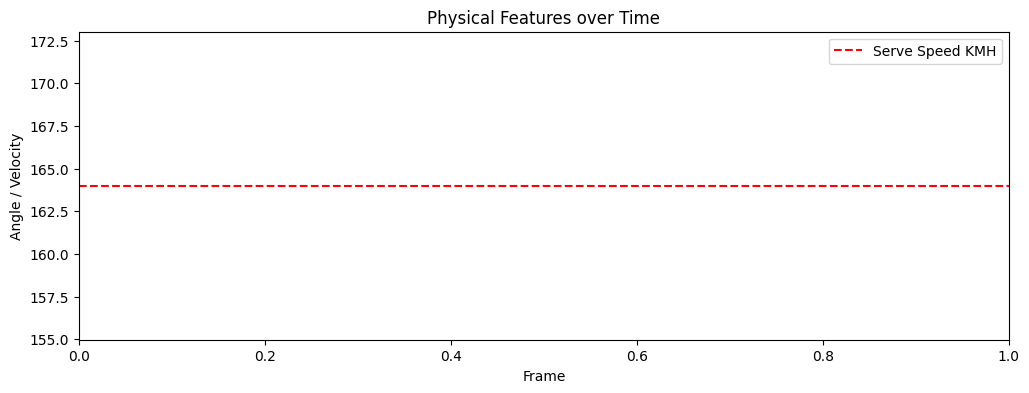

In [22]:
# Load metadata CSV
meta_df = pd.read_csv("/home/jtb3sud/G-PARC/demos/tennis/metadata/metadata.csv")

# Pick a serve_id
serve_id = "2024-usopen-2207_pt0070_srv1"

# Set output GIF path
gif_output = Path(f"{serve_id}.gif")

# Generate GIF and plots
visualize_serve(serve_id, meta_df, gif_output)


In [2]:
"""
Split large tennis data files into individual serve files - Jupyter Notebook Version
This will make data loading more flexible for your Tennis GPARC training.

Run each cell sequentially in your Jupyter notebook.
"""

import torch
from pathlib import Path
from tqdm.notebook import tqdm
import logging

# Configure logging for notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

def split_tennis_data_file(input_file: Path, output_dir: Path, split_name: str):
    """
    Split a large tennis data file into individual serve files.
    
    Args:
        input_file: Path to the large .pt file containing multiple serves
        output_dir: Directory to save individual serve files
        split_name: Name of the split (train, val, test)
    """
    print(f"📁 Loading {input_file}...")
    
    # Load the large file
    try:
        data = torch.load(input_file, map_location='cpu', weights_only=False)
        print(f"✅ Loaded {len(data)} serves from {input_file}")
    except Exception as e:
        print(f"❌ Failed to load {input_file}: {e}")
        return 0
    
    # Create output directory
    split_output_dir = output_dir / split_name
    split_output_dir.mkdir(parents=True, exist_ok=True)
    
    # Split into individual files
    print(f"✂️  Splitting into individual files in {split_output_dir}...")
    
    failed_saves = 0
    for i, serve_data in enumerate(tqdm(data, desc=f"Splitting {split_name}")):
        # Create filename with zero-padding for proper sorting
        filename = f"{split_name}_serve_{i:06d}.pt"
        output_path = split_output_dir / filename
        
        # Save individual serve
        try:
            torch.save(serve_data, output_path)
        except Exception as e:
            print(f"⚠️  Failed to save serve {i}: {e}")
            failed_saves += 1
    
    success_count = len(data) - failed_saves
    print(f"✅ Successfully split {success_count}/{len(data)} serves into {split_output_dir}")
    
    if failed_saves > 0:
        print(f"⚠️  {failed_saves} serves failed to save")
    
    return success_count

def run_tennis_data_splitting():
    """
    Main function to split tennis data files - designed for Jupyter notebook.
    Modify the paths below to match your data location.
    """
    
    print("🎾 Tennis Data Splitting Tool")
    print("=" * 50)
    
    # =============================================================================
    # CONFIGURATION - MODIFY THESE PATHS FOR YOUR DATA
    # =============================================================================
    
    # Input directory containing your large tennis files
    INPUT_DIR = "/project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized"
    
    # Output directory where split files will be saved
    OUTPUT_DIR = "/project/vil_baek/psaap/tennis/processed_tennis_speed_data/split"
    
    # Names of your data files
    TRAIN_FILE = "tennis_speed_train_normalized.pt"
    VAL_FILE = "tennis_speed_val_normalized.pt"
    TEST_FILE = "tennis_speed_test_normalized.pt"
    
    # =============================================================================
    # PROCESSING
    # =============================================================================
    
    input_dir = Path(INPUT_DIR)
    output_dir = Path(OUTPUT_DIR)
    
    # Check if input directory exists
    if not input_dir.exists():
        print(f"❌ Input directory does not exist: {input_dir}")
        return
    
    print(f"📂 Input directory: {input_dir}")
    print(f"📁 Output directory: {output_dir}")
    print()
    
    # Files to process
    files_to_split = [
        (TRAIN_FILE, "train"),
        (VAL_FILE, "val"),
        (TEST_FILE, "test")
    ]
    
    total_serves = 0
    successful_splits = []
    
    # Process each file
    for filename, split_name in files_to_split:
        input_file = input_dir / filename
        
        print(f"🔄 Processing {split_name} data...")
        
        if input_file.exists():
            num_serves = split_tennis_data_file(input_file, output_dir, split_name)
            if num_serves > 0:
                total_serves += num_serves
                successful_splits.append((split_name, num_serves))
        else:
            print(f"⚠️  File not found: {input_file}")
        
        print()  # Add spacing between files
    
    # Summary
    print("🎯 SPLITTING SUMMARY")
    print("=" * 50)
    print(f"Total serves processed: {total_serves}")
    
    if successful_splits:
        print("\n📊 Split breakdown:")
        for split_name, count in successful_splits:
            print(f"  {split_name:>5}: {count:,} serves")
    
    print(f"\n📁 Created directory structure:")
    for split in ["train", "val", "test"]:
        split_dir = output_dir / split
        if split_dir.exists():
            num_files = len(list(split_dir.glob("*.pt")))
            print(f"  {split_dir}")
            print(f"    └── {num_files:,} .pt files")
    
    print("\n✅ Splitting completed successfully!")
    print(f"💡 Update your bash script to use: {output_dir}")
    
    return output_dir, total_serves

# =============================================================================
# JUPYTER NOTEBOOK EXECUTION CELL
# =============================================================================

# Run this cell to split your tennis data
if __name__ == "__main__":
    output_directory, total_count = run_tennis_data_splitting()
else:
    print("🎾 Tennis data splitting functions loaded!")
    print("📝 Run: output_directory, total_count = run_tennis_data_splitting()")

# =============================================================================
# OPTIONAL: VALIDATION CELL (run after splitting)
# =============================================================================

def validate_split_data(split_dir: Path, sample_size: int = 5):
    """
    Validate that the split data files are correctly formatted.
    Run this after splitting to check a few sample files.
    """
    print(f"🔍 Validating split data in {split_dir}")
    
    for split in ["train", "val", "test"]:
        split_path = split_dir / split
        if not split_path.exists():
            print(f"⚠️  {split} directory not found")
            continue
            
        files = list(split_path.glob("*.pt"))
        if len(files) == 0:
            print(f"⚠️  No files found in {split}")
            continue
            
        print(f"\n📂 {split.upper()} validation:")
        print(f"   Total files: {len(files)}")
        
        # Check a few sample files
        sample_files = files[:min(sample_size, len(files))]
        
        for i, file_path in enumerate(sample_files):
            try:
                data = torch.load(file_path, map_location='cpu', weights_only=False)
                
                # Basic validation
                if hasattr(data, 'x'):
                    print(f"   Sample {i+1}: ✅ x.shape = {data.x.shape}")
                if hasattr(data, 'y') or hasattr(data, 'speed'):
                    speed = getattr(data, 'speed', getattr(data, 'y', 'N/A'))
                    print(f"   Sample {i+1}: ✅ speed = {speed}")
                if hasattr(data, 'serve_number'):
                    print(f"   Sample {i+1}: ✅ serve_number = {data.serve_number}")
                    
            except Exception as e:
                print(f"   Sample {i+1}: ❌ Error loading {file_path.name}: {e}")

# Uncomment and run this cell after splitting to validate:
# validate_split_data(Path("/project/vil_baek/psaap/tennis/processed_tennis_speed_data/split"))

🎾 Tennis Data Splitting Tool
📂 Input directory: /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized
📁 Output directory: /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split

🔄 Processing train data...
📁 Loading /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_train_normalized.pt...


/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jtb3sud/.local/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


✅ Loaded 4098 serves from /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_train_normalized.pt
✂️  Splitting into individual files in /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/train...


Splitting train:   0%|          | 0/4098 [00:00<?, ?it/s]

✅ Successfully split 4098/4098 serves into /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/train

🔄 Processing val data...
📁 Loading /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_val_normalized.pt...
✅ Loaded 909 serves from /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_val_normalized.pt
✂️  Splitting into individual files in /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/val...


Splitting val:   0%|          | 0/909 [00:00<?, ?it/s]

✅ Successfully split 909/909 serves into /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/val

🔄 Processing test data...
📁 Loading /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_test_normalized.pt...
✅ Loaded 959 serves from /project/vil_baek/psaap/tennis/processed_tennis_speed_data/normalized/tennis_speed_test_normalized.pt
✂️  Splitting into individual files in /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/test...


Splitting test:   0%|          | 0/959 [00:00<?, ?it/s]

✅ Successfully split 959/959 serves into /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/test

🎯 SPLITTING SUMMARY
Total serves processed: 5966

📊 Split breakdown:
  train: 4,098 serves
    val: 909 serves
   test: 959 serves

📁 Created directory structure:
  /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/train
    └── 4,098 .pt files
  /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/val
    └── 909 .pt files
  /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split/test
    └── 959 .pt files

✅ Splitting completed successfully!
💡 Update your bash script to use: /project/vil_baek/psaap/tennis/processed_tennis_speed_data/split


In [1]:
# Similar to Shock tube

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
import io
import pandas as pd
from tqdm import tqdm
from typing import Union, Optional, Dict

import torch
from torch_geometric.data import Data
from mpl_toolkits.mplot3d import Axes3D

class TennisServeProcessor:
    """
    A unified class to visualize tennis serve data and convert it 
    to PyTorch Geometric datasets for next-step prediction.
    This version includes automatic player ID mapping and adds rich global
    context to each frame.
    """
    
    def __init__(self, base_dir: Union[str, Path]):
        self.base_dir = Path(base_dir)
        self.metadata_path = self.base_dir / "metadata" / "metadata.csv"
        self.joint_names = [
            "Pelvis", "R Hip", "R Knee", "R Ankle", "L Hip", "L Knee", "L Ankle", 
            "Spine", "Thorax", "Neck", "Head", "L Shoulder", "L Elbow", "L Wrist", 
            "R Shoulder", "R Elbow", "R Wrist"
        ]
        self.skeleton_edges = [
            (0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6), (0, 7), 
            (7, 8), (8, 9), (9, 10), (8, 11), (11, 12), (12, 13), 
            (8, 14), (14, 15), (15, 16)
        ]
        self.metadata = self._load_metadata()
        
        # --- Create a unique numerical ID for each player ---
        self.servers = sorted(self.metadata['server'].unique())
        self.player_to_id: Dict[str, int] = {name: i for i, name in enumerate(self.servers)}
        print(f"Created mapping for {len(self.player_to_id)} unique players.")

    def _load_metadata(self) -> pd.DataFrame:
        if not self.metadata_path.exists():
            raise FileNotFoundError(f"Metadata not found at {self.metadata_path}")
        print("Metadata loaded.")
        return pd.read_csv(self.metadata_path)

    def read_serve_keypoints(self, serve_row: pd.Series) -> Optional[np.ndarray]:
        """Reads the keypoint data for a single serve."""
        keypoints_path = self.base_dir / serve_row['keypoints_path']
        if not keypoints_path.exists():
            return None
        with open(keypoints_path, 'r') as f:
            return np.array(json.load(f), dtype=np.float32)

    def create_serve_animation_gif(self, serve_id: str, save_path: str = "serve_animation.gif", fps: int = 15):
        """Creates a 3D GIF animation of a single tennis serve."""
        # This function remains unchanged.
        serve_row = self.metadata[self.metadata['serve_id'] == serve_id].iloc[0]
        keypoints = self.read_serve_keypoints(serve_row)
        
        if keypoints is None:
            print(f"Could not generate animation for serve {serve_id}.")
            return

        print(f"🎬 Generating 3D animation for serve '{serve_id}'...")
        min_coords, max_coords = keypoints.min(axis=(0, 1)), keypoints.max(axis=(0, 1))
        center, max_range = (max_coords + min_coords) / 2, (max_coords - min_coords).max()
        
        with imageio.get_writer(save_path, mode='I', fps=fps, loop=0) as writer:
            for i in tqdm(range(keypoints.shape[0]), desc="Rendering frames"):
                fig = plt.figure(figsize=(8, 8))
                ax = fig.add_subplot(111, projection='3d')
                frame_kps = keypoints[i]
                ax.scatter(frame_kps[:, 0], frame_kps[:, 1], frame_kps[:, 2], c='red', s=40)
                for start, end in self.skeleton_edges:
                    ax.plot(*zip(frame_kps[start], frame_kps[end]), color='k')
                ax.set_xlim(center[0] - max_range/2, center[0] + max_range/2)
                ax.set_ylim(center[1] - max_range/2, center[1] + max_range/2)
                ax.set_zlim(center[2] - max_range/2, center[2] + max_range/2)
                ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
                ax.set_title(f"Serve Animation - Frame {i+1}/{keypoints.shape[0]}")
                ax.view_init(elev=20, azim=-60)
                
                with io.BytesIO() as buf:
                    plt.savefig(buf, format='png', dpi=90)
                    buf.seek(0)
                    writer.append_data(imageio.v2.imread(buf))
                plt.close(fig)
        print(f"✅ Animation saved to '{save_path}'")

    def _create_graph_connectivity(self) -> torch.Tensor:
        """Helper to create the edge_index for the skeleton graph."""
        edges = []
        for i, j in self.skeleton_edges:
            edges.extend([[i, j], [j, i]])
        return torch.tensor(edges, dtype=torch.long).t().contiguous()

    def create_pyg_dataset_for_rollout(self, output_dir: Union[str, Path], include_velocities: bool = True):
        """
        Processes all serves, saving each as a PyG sequence with curated global context.
        """
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        edge_index = self._create_graph_connectivity()
        
        print(f"\n🧠 Processing {len(self.metadata)} serves into PyG format...")
        
        for _, row in tqdm(self.metadata.iterrows(), total=len(self.metadata), desc="Creating PyG Serves"):
            keypoints = self.read_serve_keypoints(row)
            if keypoints is None or len(keypoints) < 2:
                continue

            positions = keypoints
            node_features = np.concatenate([positions, np.diff(positions, axis=0, append=positions[-1:,:,:])], axis=-1) if include_velocities else positions
            
            server_name = row['server']
            server_id = self.player_to_id.get(server_name, -1)

            serve_sequence = []
            for t in range(node_features.shape[0] - 1):
                x_t = torch.tensor(node_features[t], dtype=torch.float32)
                pos_t = torch.tensor(positions[t], dtype=torch.float32)
                y_t = torch.tensor(positions[t + 1], dtype=torch.float32)
                
                data_t = Data(
                    x=x_t,
                    y=y_t,
                    pos=pos_t,
                    edge_index=edge_index,
                    
                    # --- Finalized Global Parameters ---
                    server_id=torch.tensor([server_id], dtype=torch.long),
                    serve_number=torch.tensor([row['ServeNumber']], dtype=torch.float32),
                    set_number=torch.tensor([row['SetNo']], dtype=torch.float32),
                    game_number=torch.tensor([row['GameNo']], dtype=torch.float32),
                    point_number=torch.tensor([row['PointNumber']], dtype=torch.float32)
                )
                serve_sequence.append(data_t)
            
            if serve_sequence:
                save_path = output_dir / f"{row['serve_id']}.pt"
                torch.save(serve_sequence, save_path)
                
        print(f"✅ PyG dataset creation complete. Files saved in '{output_dir}'.")
        with open(output_dir / 'player_mapping.json', 'w') as f:
            json.dump(self.player_to_id, f, indent=2)
        print("✅ Player ID mapping saved to 'player_mapping.json'.")


# ==================== MAIN WORKFLOW ====================

if __name__ == '__main__':
    BASE_DIR = Path("/home/jtb3sud/G-PARC/demos/tennis")
    PYG_OUTPUT_DIR = Path("/project/vil_baek/psaap/tennis/seq_tennis_data")

    processor = TennisServeProcessor(BASE_DIR)
    
    # --- Workflow Step 1: Visualize a sample serve (Optional) ---
    sample_serve_id = processor.metadata['serve_id'][0]
    processor.create_serve_animation_gif(
        serve_id=sample_serve_id, 
        save_path=f"{sample_serve_id}_animation.gif"
    )
    
    # --- Workflow Step 2: Process all serves into PyG format ---
    processor.create_pyg_dataset_for_rollout(
        output_dir=PYG_OUTPUT_DIR,
        include_velocities=True
    )
    
    print(f"\n🎉 Workflow complete! Your data in '{PYG_OUTPUT_DIR}' is now ready.")
    print("You can now use this directory with a RolloutDataset for training.")

Metadata loaded.
Created mapping for 109 unique players.
🎬 Generating 3D animation for serve '2024-usopen-1101_pt0001_srv1'...


Rendering frames: 100%|██████████| 88/88 [00:14<00:00,  6.16it/s]


✅ Animation saved to '2024-usopen-1101_pt0001_srv1_animation.gif'

🧠 Processing 6364 serves into PyG format...


Creating PyG Serves: 100%|██████████| 6364/6364 [04:38<00:00, 22.81it/s]

✅ PyG dataset creation complete. Files saved in '/project/vil_baek/psaap/tennis/seq_tennis_data'.
✅ Player ID mapping saved to 'player_mapping.json'.

🎉 Workflow complete! Your data in '/project/vil_baek/psaap/tennis/seq_tennis_data' is now ready.
You can now use this directory with a RolloutDataset for training.


✅ Loaded player name mapping.
🔍 Inspecting file: 2024-usopen-2311_pt0117_srv1.pt

DATA STRUCTURE OVERVIEW
Total frames (timesteps) in sequence: 94

Structure of a single frame (Data object):
  - data.x (Input Features):      [17, 6]
  - data.y (Target Features):     [17, 3]
  - data.pos (3D Positions):      [17, 3]

🌍 Global Parameters (from first frame):
  - game_number: 2.0
  - server_id: 75 (Marta Kostyuk)
  - point_number: 117.0
  - serve_number: 1.0
  - set_number: 3.0

FEATURE VISUALIZATION for Right Wrist (Joint 16)

✅ Plot saved to '2024-usopen-2311_pt0117_srv1_feature_plot.png'


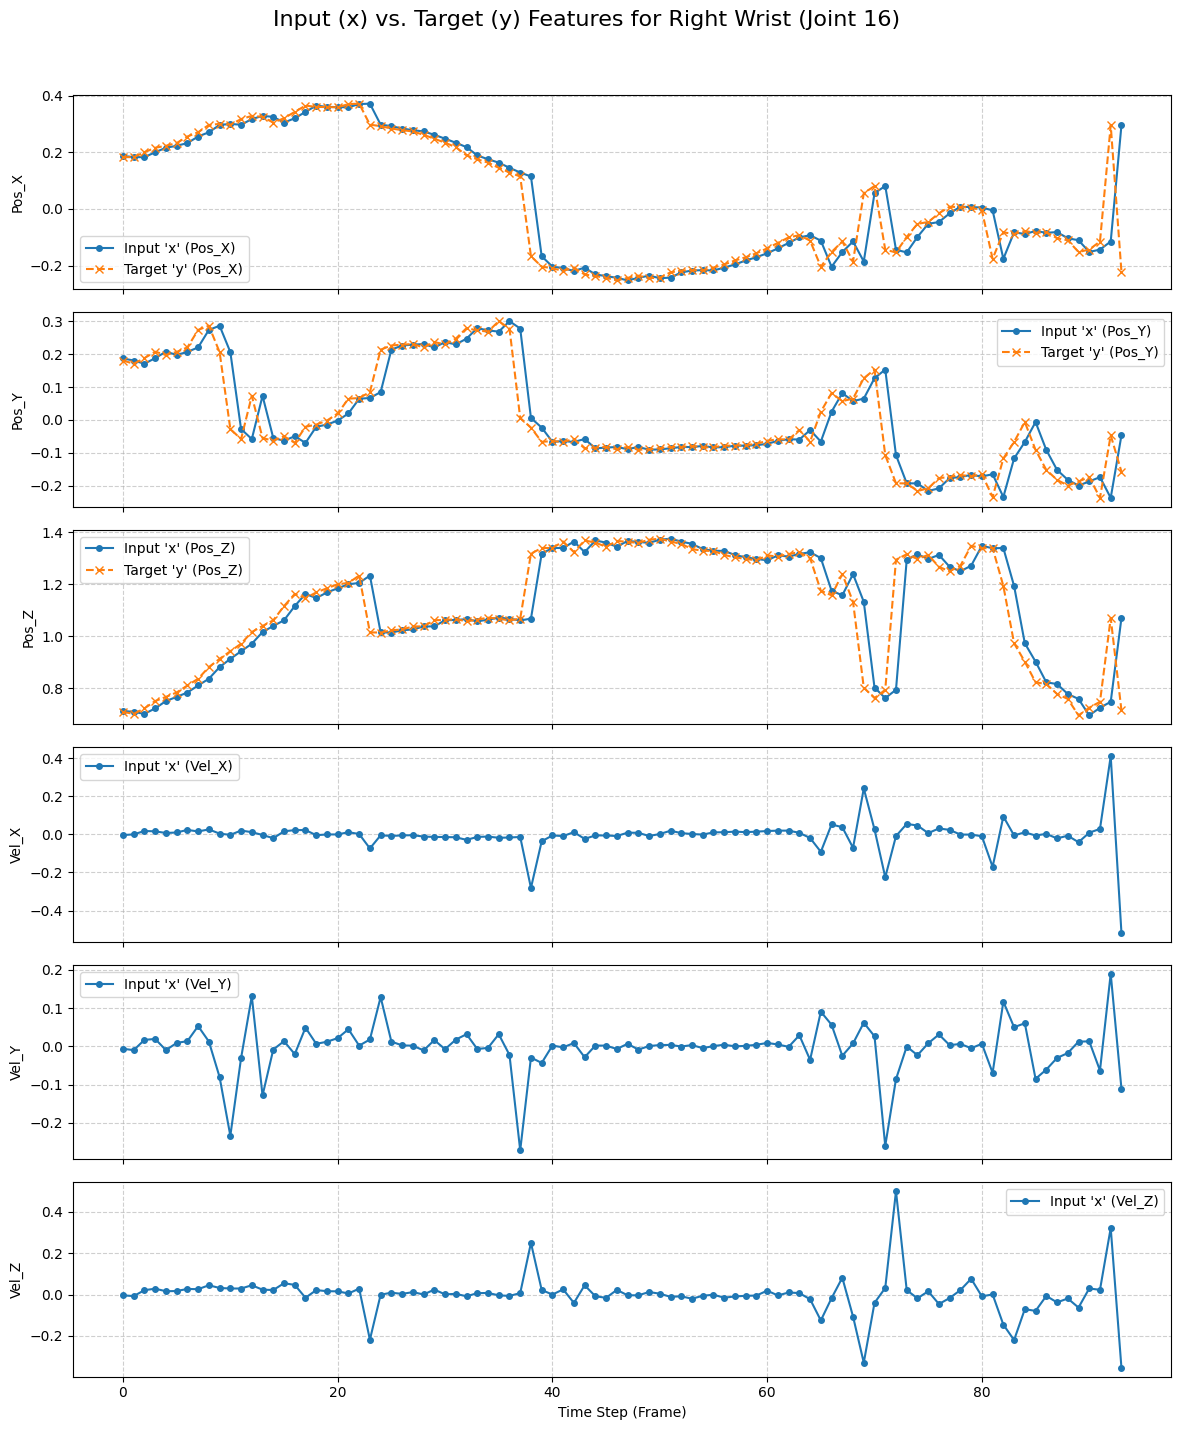

In [15]:
#!/usr/bin/env python3
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import json

def inspect_and_visualize_serve(file_path: Path, joint_index: int = 16):
    """
    Loads a processed serve sequence, prints its structure (including global
    parameters), and visualizes features for a specific joint.
    """
    if not file_path.exists():
        print(f"❌ Error: File not found at {file_path}")
        return

    # Try to load the player mapping file if it exists
    player_mapping_path = file_path.parent / 'player_mapping.json'
    id_to_player = None
    if player_mapping_path.exists():
        with open(player_mapping_path, 'r') as f:
            player_to_id = json.load(f)
            id_to_player = {v: k for k, v in player_to_id.items()}
            print(f"✅ Loaded player name mapping.")

    print(f"🔍 Inspecting file: {file_path.name}")
    serve_sequence = torch.load(file_path, weights_only=False)

    if not serve_sequence or not isinstance(serve_sequence, list):
        print("❌ Error: File does not contain a valid sequence.")
        return
        
    # --- 1. Data Structure Inspection ---
    print("\n" + "="*50)
    print("DATA STRUCTURE OVERVIEW")
    print("="*50)
    print(f"Total frames (timesteps) in sequence: {len(serve_sequence)}")
    
    sample_frame = serve_sequence[0]
    print("\nStructure of a single frame (Data object):")
    print(f"  - data.x (Input Features):      {list(sample_frame.x.shape)}")
    print(f"  - data.y (Target Features):     {list(sample_frame.y.shape)}")
    print(f"  - data.pos (3D Positions):      {list(sample_frame.pos.shape)}")

    # --- Global Parameter Inspection ---
    print("\n🌍 Global Parameters (from first frame):")
    known_keys = {'x', 'y', 'pos', 'edge_index'}
    
    # --- FIX: Call .keys() as a method ---
    global_params = {key: getattr(sample_frame, key) for key in sample_frame.keys() if key not in known_keys}
    
    if not global_params:
        print("  - No global parameters found.")
    else:
        for key, value in global_params.items():
            if key == 'server_id' and id_to_player:
                player_name = id_to_player.get(value.item(), "Unknown")
                print(f"  - {key}: {value.item()} ({player_name})")
            else:
                # Use .item() to extract the scalar value from the tensor
                print(f"  - {key}: {value.item()}" if value.numel() == 1 else value)

    # --- 2. Feature Visualization ---
    # (The rest of the script is the same)
    num_input_features = sample_frame.num_features
    num_target_features = sample_frame.y.shape[1]
    input_features = torch.stack([frame.x[joint_index] for frame in serve_sequence])
    target_features = torch.stack([frame.y[joint_index] for frame in serve_sequence])
    timesteps = torch.arange(len(serve_sequence))

    print("\n" + "="*50)
    print(f"FEATURE VISUALIZATION for Right Wrist (Joint {joint_index})")
    print("="*50)
    
    feature_labels = ['Pos_X', 'Pos_Y', 'Pos_Z', 'Vel_X', 'Vel_Y', 'Vel_Z']
    
    fig, axes = plt.subplots(num_input_features, 1, figsize=(12, 2.5 * num_input_features), sharex=True)
    fig.suptitle(f'Input (x) vs. Target (y) Features for Right Wrist (Joint {joint_index})', fontsize=16)

    for i in range(num_input_features):
        ax = axes[i] if num_input_features > 1 else axes
        ax.plot(timesteps, input_features[:, i], 'o-', label=f"Input 'x' ({feature_labels[i]})", markersize=4)
        if i < num_target_features:
            ax.plot(timesteps, target_features[:, i], 'x--', label=f"Target 'y' ({feature_labels[i]})")
        ax.set_ylabel(feature_labels[i])
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    (axes[-1] if num_input_features > 1 else axes).set_xlabel("Time Step (Frame)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    save_path = f"{file_path.stem}_feature_plot.png"
    plt.savefig(save_path)
    print(f"\n✅ Plot saved to '{save_path}'")
    plt.show()


if __name__ == '__main__':
    PROCESSED_SERVE_FILE = Path("/project/vil_baek/psaap/tennis/seq_tennis_data/2024-usopen-2311_pt0117_srv1.pt")
    JOINT_TO_INSPECT = 16 # Right Wrist

    inspect_and_visualize_serve(PROCESSED_SERVE_FILE, JOINT_TO_INSPECT)